In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import bartlett
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrix
from linearmodels.panel import PanelOLS
from scipy.stats import normaltest
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans

## Data Load

In [3]:
# Read the data
wm_data = pd.read_csv("../postcode_gi_proportion_West_Midlands.csv")
gm_data = pd.read_csv("../postcode_gi_proportion_Greater_Manchester.csv")
gl_data = pd.read_csv("../postcode_gi_proportion_Greater_London.csv")

# Combine the datasets
gi_data = pd.concat([wm_data, gm_data, gl_data], ignore_index=True)

# Define buffer radii
buffer_radii = [482, 965, 1890, 2816]

## EDA for GI proportion

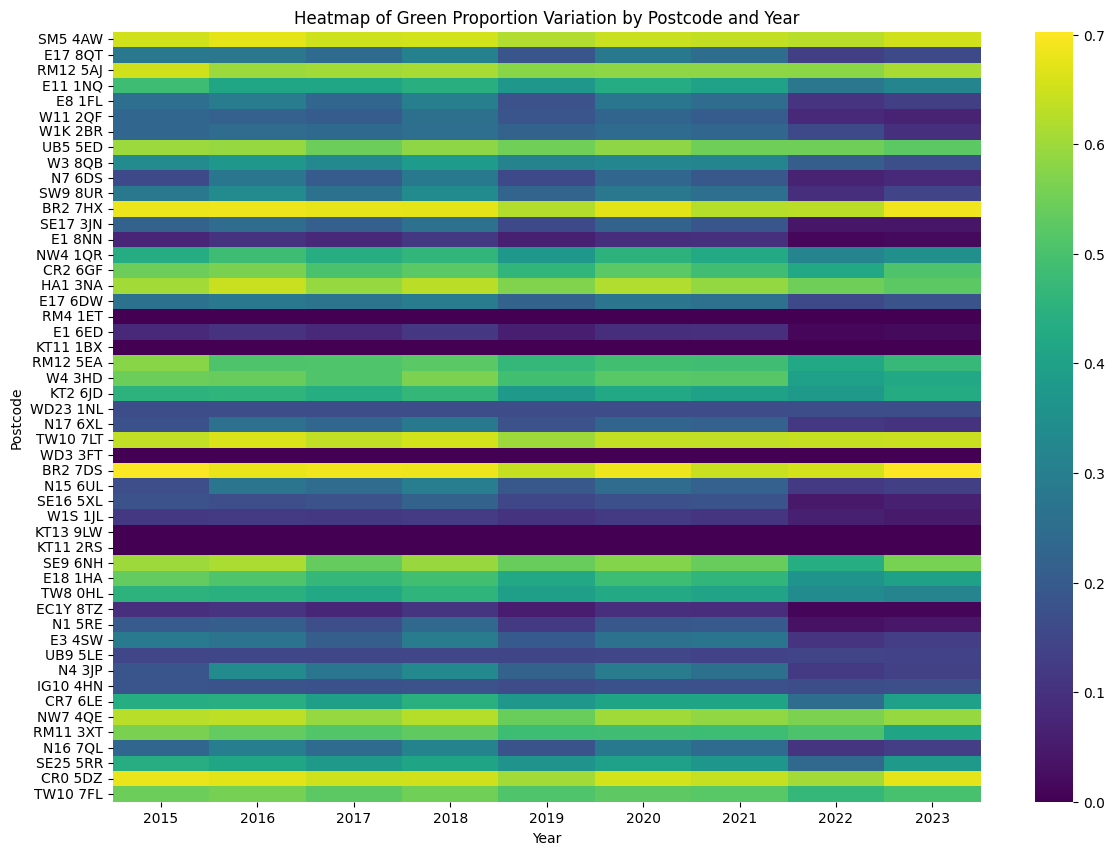

In [84]:
tmp_df = gi_data[gi_data['city']=='Greater_London']

pivot_df = tmp_df[['green_proportion','year','postcode']].pivot_table(index='postcode', columns='year', values='green_proportion', aggfunc='mean')

# Select a sample of postcodes if the full set is too large
sampled_pivot_df = pivot_df.sample(n=50, random_state=1)  # Adjust n as needed

plt.figure(figsize=(14, 10))
sns.heatmap(sampled_pivot_df, cmap='viridis', annot=False, cbar=True)
plt.title('Heatmap of Green Proportion Variation by Postcode and Year')
plt.xlabel('Year')
plt.ylabel('Postcode')
plt.show()

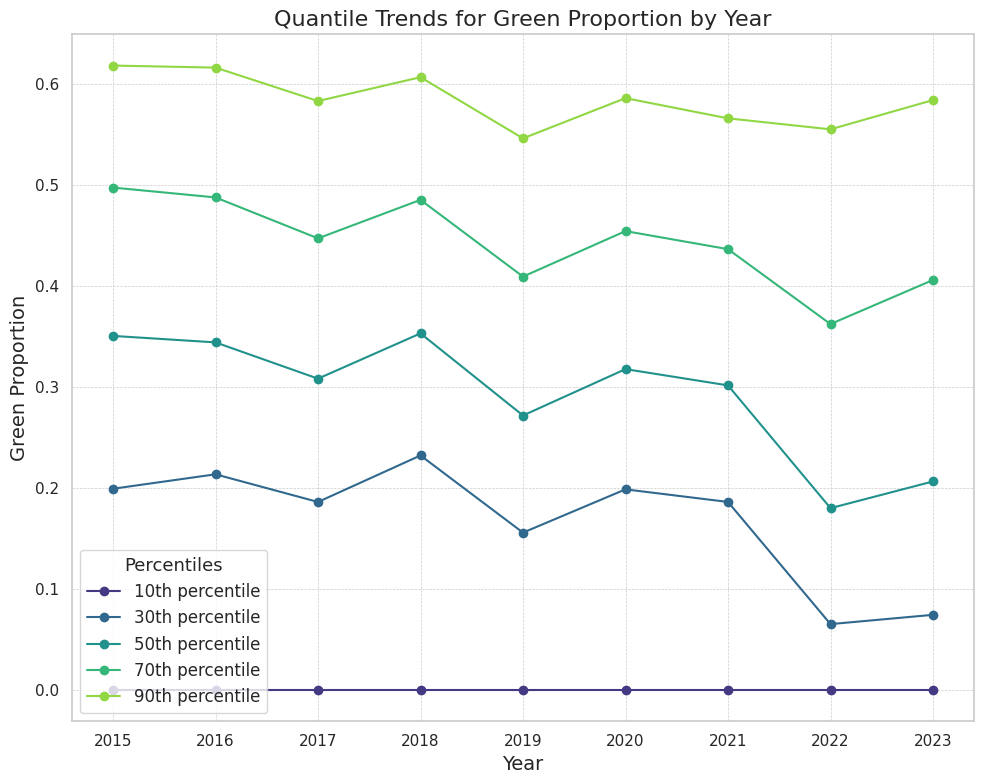

In [90]:
tmp_df = gi_data[gi_data['city']=='Greater_London']
sns.set(style="whitegrid")

# Sample data creation and plotting as you've outlined
quantiles = tmp_df[['green_proportion', 'year', 'postcode']].groupby('year')['green_proportion'].quantile([0.1, 0.3, 0.5, 0.7, 0.9]).unstack()

# Define a color palette
palette = sns.color_palette("viridis", n_colors=5)  # Using a color palette that is clear and visually appealing

# Start the plot
plt.figure(figsize=(10, 8))
for i, quantile in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
    plt.plot(quantiles.index, quantiles[quantile], marker='o', linestyle='-', color=palette[i], label=f'{int(quantile * 100)}th percentile')

plt.title('Quantile Trends for Green Proportion by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Green Proportion', fontsize=14)
plt.legend(title='Percentiles', title_fontsize='13', fontsize='12', loc='lower left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

In [13]:
file_path = '../urban_greenspace_classification/Sample_image/LA_Manchester_2018.tif'
with rasterio.open(file_path) as src:
    print(f"Number of bands: {src.count}")
    for i in range(1, src.count + 1):
        data = src.read(i)
        print(f"Band {i} stats:")
        print(f"  Min: {np.nanmin(data)}")
        print(f"  Max: {np.nanmax(data)}")
        print(f"  Mean: {np.nanmean(data)}")
        print(f"  NaN count: {np.isnan(data).sum()}")
        print(f"  Total count: {data.size}")


Number of bands: 10
Band 1 stats:
  Min: -0.26123127341270447
  Max: 0.43478259444236755
  Mean: 0.23822109401226044
  NaN count: 9247823
  Total count: 21947097
Band 2 stats:
  Min: -0.26693251729011536
  Max: 0.46997085213661194
  Mean: 0.1298389881849289
  NaN count: 9247823
  Total count: 21947097
Band 3 stats:
  Min: -0.3506600558757782
  Max: 0.795480489730835
  Mean: 0.37868553400039673
  NaN count: 9247823
  Total count: 21947097
Band 4 stats:
  Min: -0.6759300231933594
  Max: 0.3655495047569275
  Mean: -0.3181370198726654
  NaN count: 9247823
  Total count: 21947097
Band 5 stats:
  Min: -0.6250460743904114
  Max: 0.6819280385971069
  Mean: -0.22760702669620514
  NaN count: 9247823
  Total count: 21947097
Band 6 stats:
  Min: 17.467044830322266
  Max: 2252207.0
  Mean: 78658.59375
  NaN count: 9247823
  Total count: 21947097
Band 7 stats:
  Min: 810.0
  Max: 6242.5
  Mean: 1190.3914794921875
  NaN count: 9247823
  Total count: 21947097
Band 8 stats:
  Min: 560.5
  Max: 6531.0
 

In [14]:
# Define the path where your TIFF files are stored
data_folder = '../urban_greenspace_classification/Sample_image/'

# Define the years of interest
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Define the bands to analyze
bands = ['NDTI', 'NDRE', 'NDVI', 'NDWI', 'MNDWI', 'glcm', 'B2', 'B3', 'B4', 'B8']
cities = ['Manchester', 'Westmidlands', 'London']

# Initialize a dictionary to store results
data_stats = {(city, band): [] for city in cities for band in bands}

def calculate_band_statistics(src, band_index):
    """Calculate mean, median, and std for a specific band index."""
    band_data = src.read(band_index)
    # Mask no-data values if they are defined, assuming -32768 as a no-data value
    nodata = src.nodatavals[band_index - 1]
    if nodata is not None:
        band_data = np.where(band_data == nodata, np.nan, band_data)
    
    # Handle case where entire band data might be NaN
    if np.isnan(band_data).all():
        return np.nan, np.nan, np.nan
    
    band_mean = np.nanmean(band_data)
    band_median = np.nanmedian(band_data)
    band_std = np.nanstd(band_data)
    return band_mean, band_median, band_std

# Iterate over cities, years, and bands
for city in cities:
    for year in years:
        # Adjust the file name according to city and year
        file_name = f"LA_{city}_{year}.tif"
        file_path = os.path.join(data_folder, file_name)
        
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                # Get the number of bands in the TIFF file
                num_bands = src.count
                print(f"Processing {file_name} with {num_bands} bands.")
                
                for i, band in enumerate(bands):
                    # Check if the band index is within the available range
                    if i + 1 <= num_bands:
                        band_mean, band_median, band_std = calculate_band_statistics(src, i+1)
                        data_stats[(city, band)].append({
                            'Year': year,
                            'Mean': band_mean,
                            'Median': band_median,
                            'Std': band_std
                        })
                    else:
                        print(f"Band index {i+1} for {band} in {file_name} is out of range.")
                        data_stats[(city, band)].append({
                            'Year': year,
                            'Mean': np.nan,
                            'Median': np.nan,
                            'Std': np.nan
                        })
        else:
            print(f"File {file_name} does not exist.")
            for band in bands:
                data_stats[(city, band)].append({
                    'Year': year,
                    'Mean': np.nan,
                    'Median': np.nan,
                    'Std': np.nan
                })

# Convert the dictionary to a pandas DataFrame for easier analysis
df_list = []
for (city, band), stats in data_stats.items():
    df = pd.DataFrame(stats)
    df['City'] = city
    df['Band'] = band
    df_list.append(df)

final_df = pd.concat(df_list, ignore_index=True)



Processing LA_Manchester_2015.tif with 10 bands.
Processing LA_Manchester_2016.tif with 10 bands.
Processing LA_Manchester_2017.tif with 10 bands.
Processing LA_Manchester_2018.tif with 10 bands.
Processing LA_Manchester_2019.tif with 10 bands.
Processing LA_Manchester_2020.tif with 10 bands.
Processing LA_Manchester_2021.tif with 10 bands.
Processing LA_Manchester_2022.tif with 10 bands.
Processing LA_Manchester_2023.tif with 10 bands.
Processing LA_Westmidlands_2015.tif with 10 bands.
Processing LA_Westmidlands_2016.tif with 10 bands.
Processing LA_Westmidlands_2017.tif with 10 bands.
Processing LA_Westmidlands_2018.tif with 10 bands.
Processing LA_Westmidlands_2019.tif with 10 bands.
Processing LA_Westmidlands_2020.tif with 10 bands.
Processing LA_Westmidlands_2021.tif with 10 bands.
Processing LA_Westmidlands_2022.tif with 10 bands.
Processing LA_Westmidlands_2023.tif with 10 bands.
Processing LA_London_2015.tif with 10 bands.
Processing LA_London_2016.tif with 10 bands.
Processing

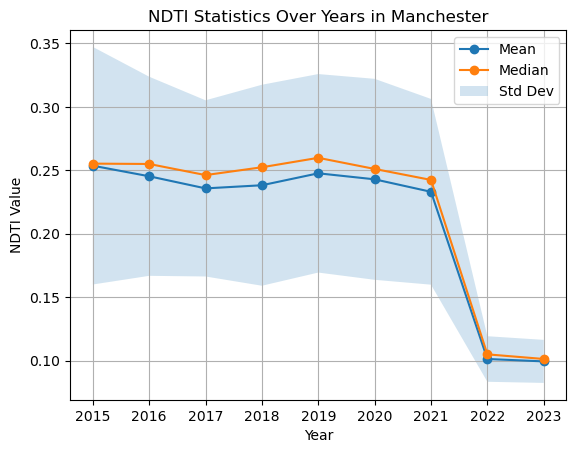

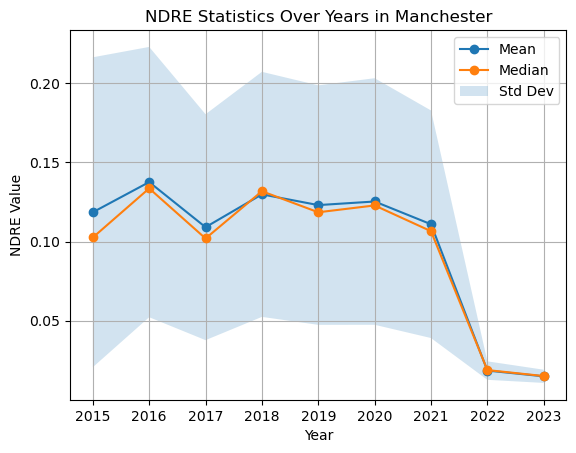

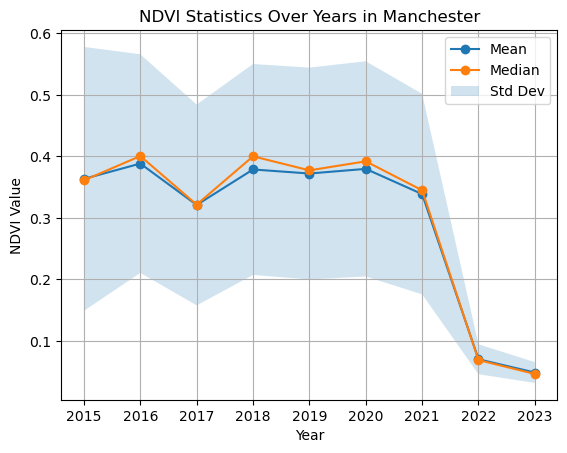

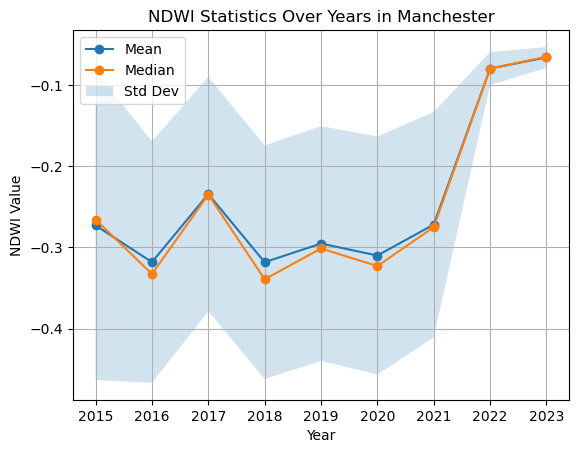

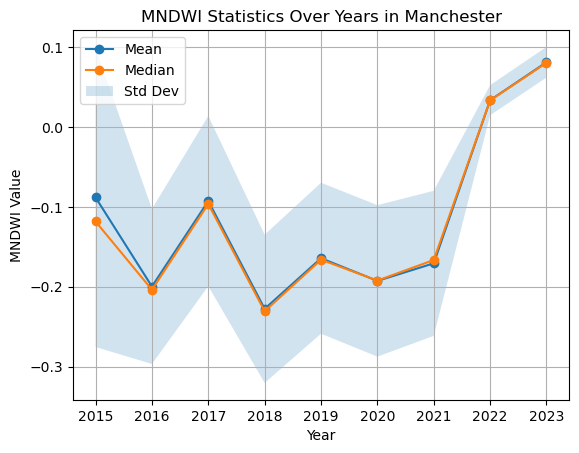

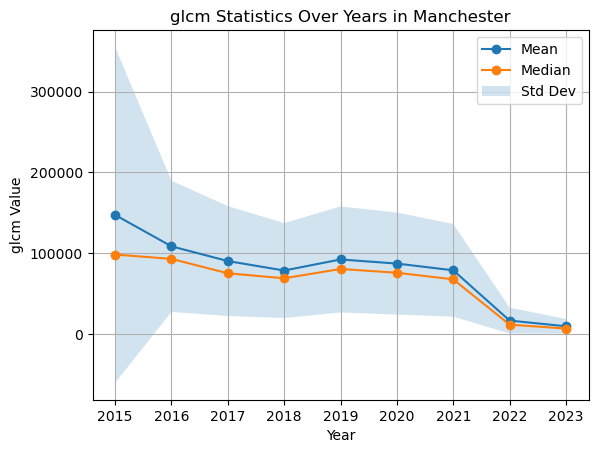

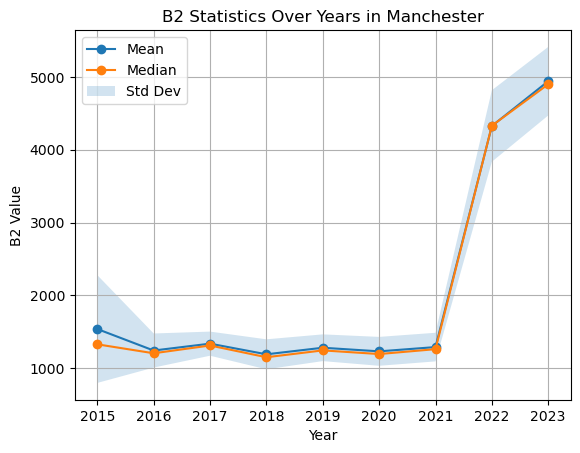

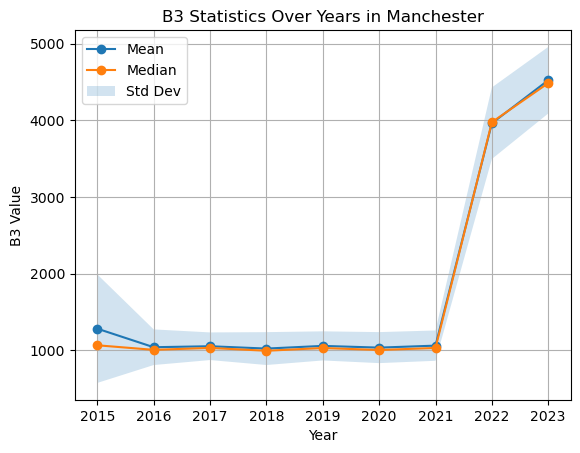

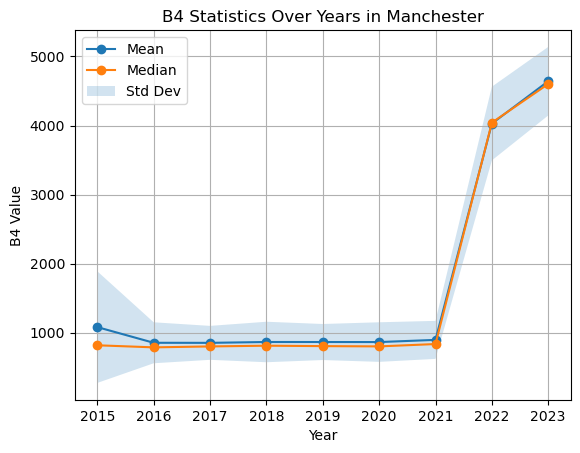

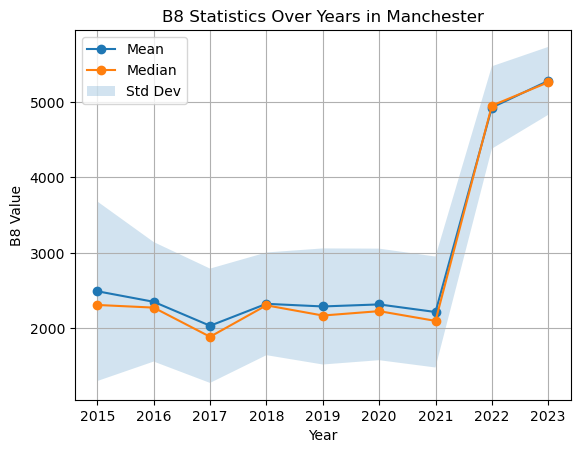

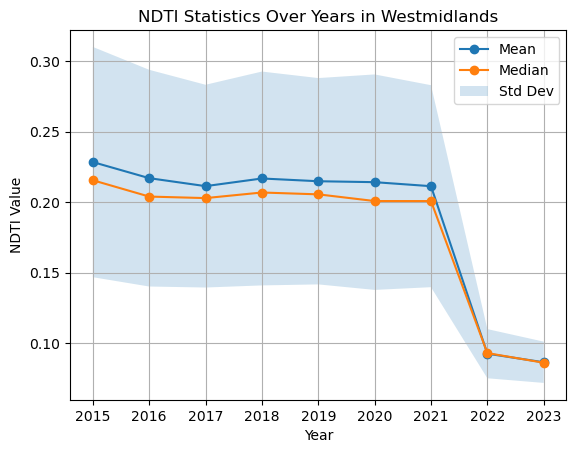

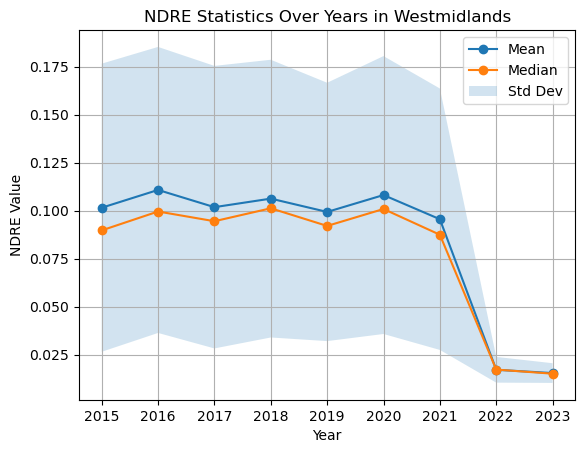

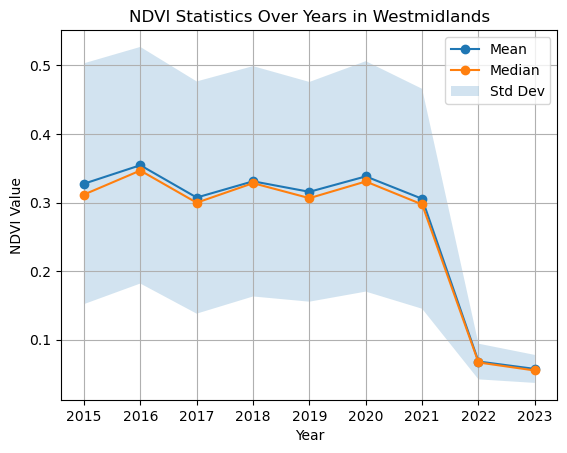

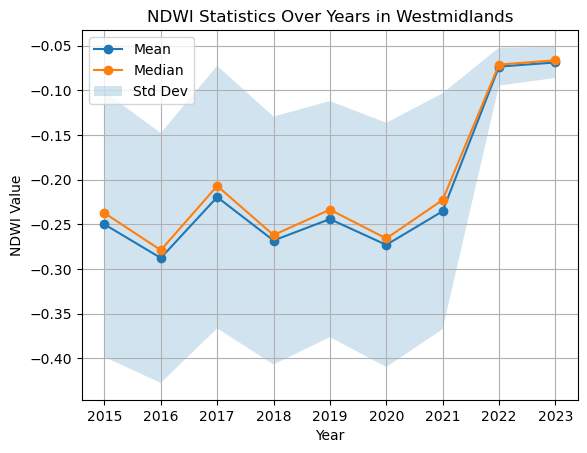

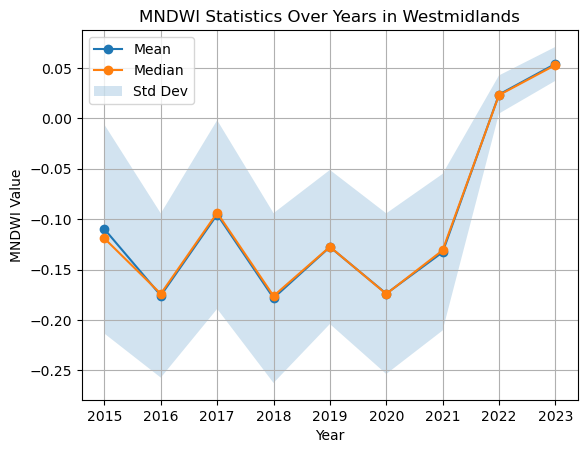

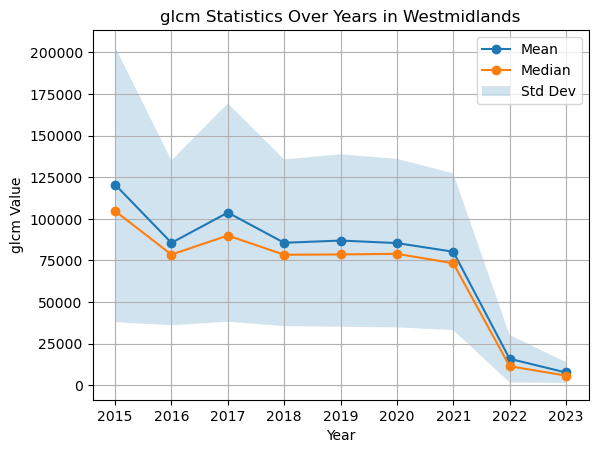

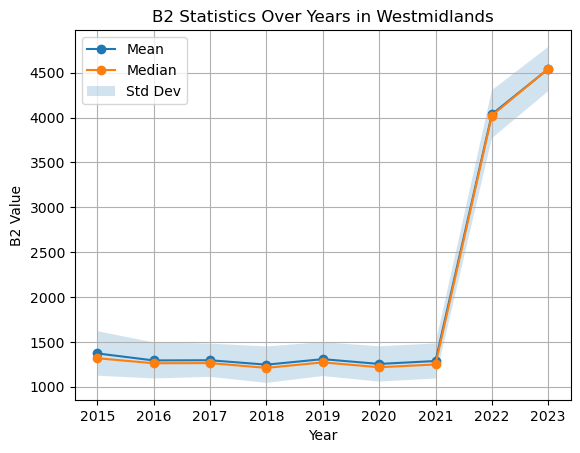

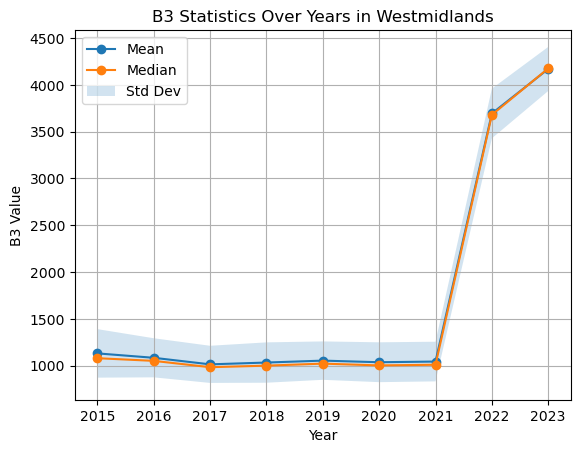

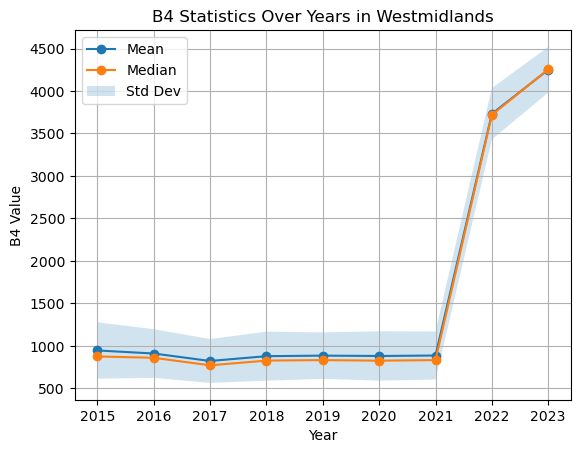

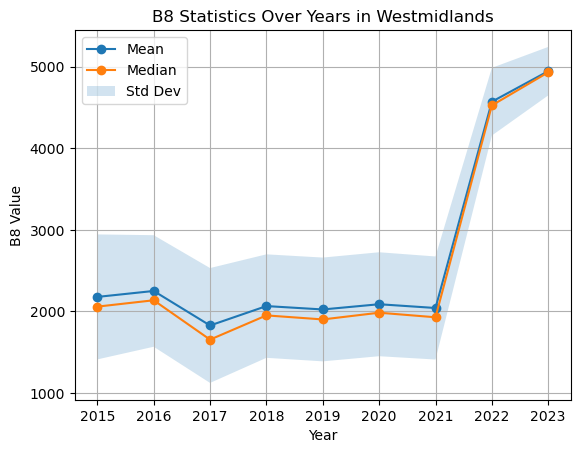

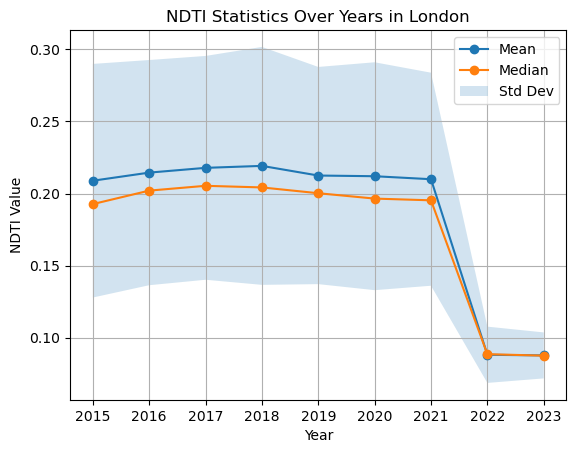

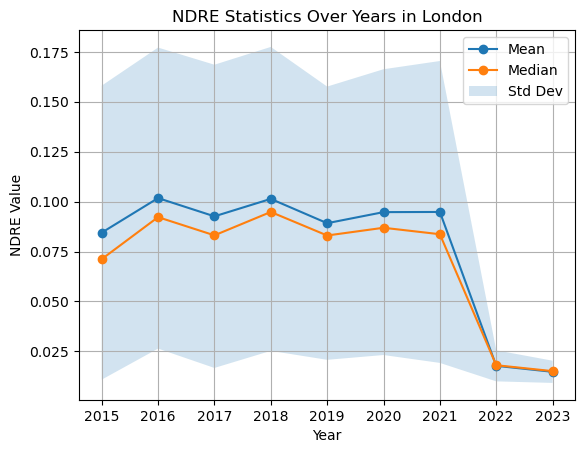

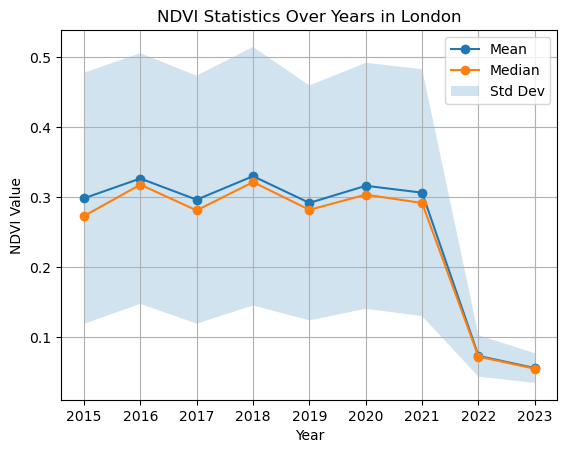

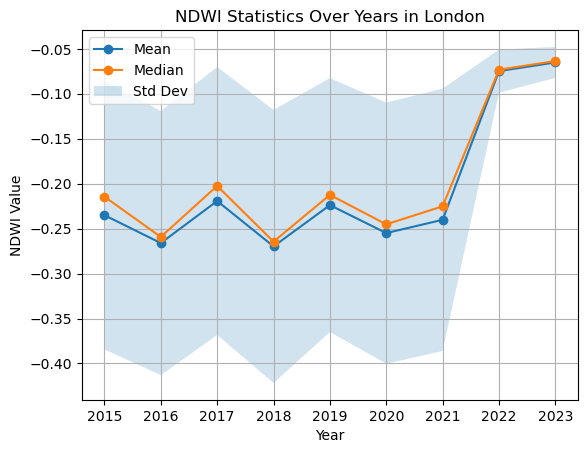

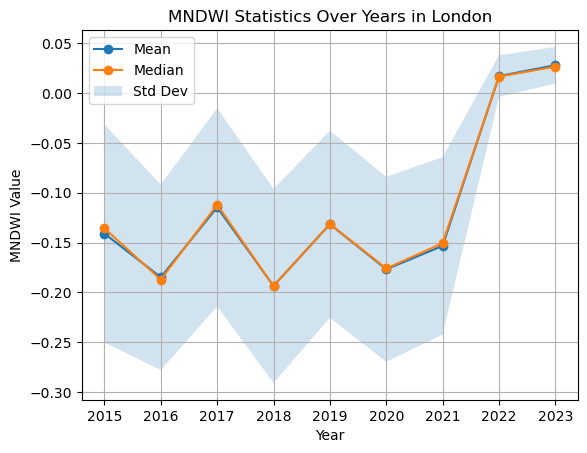

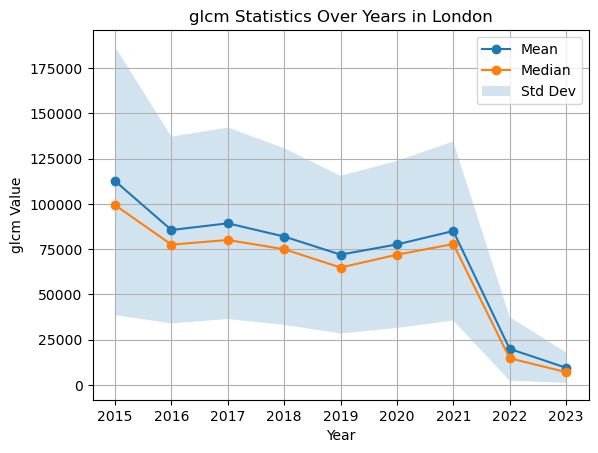

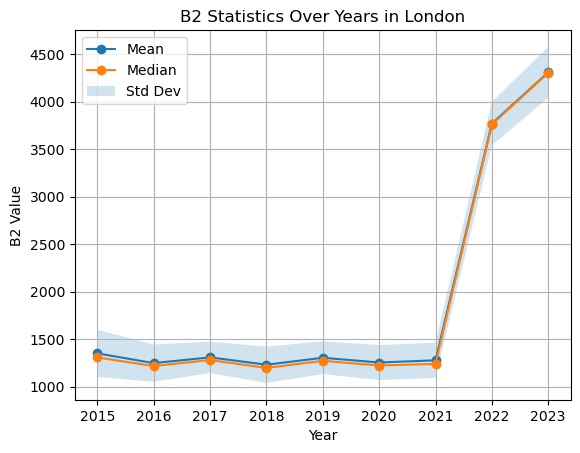

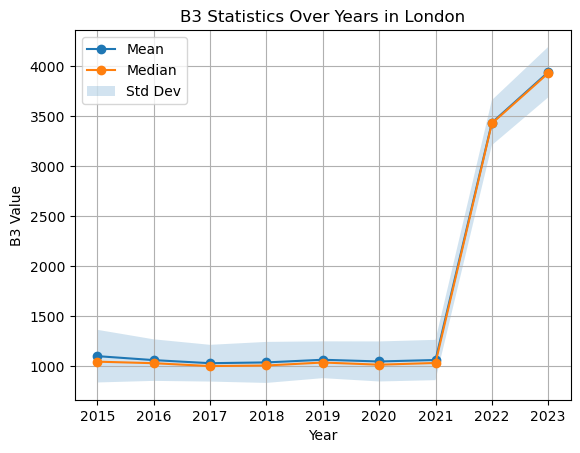

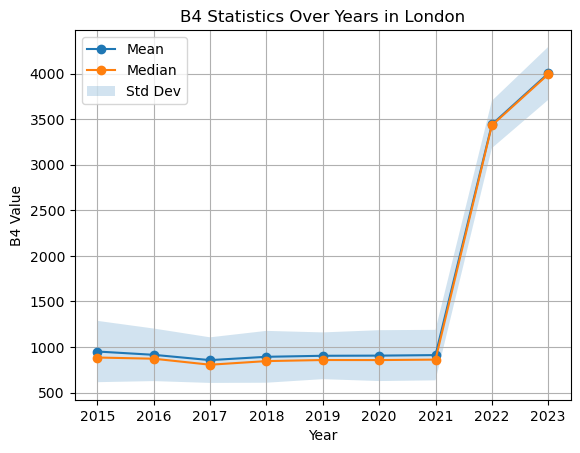

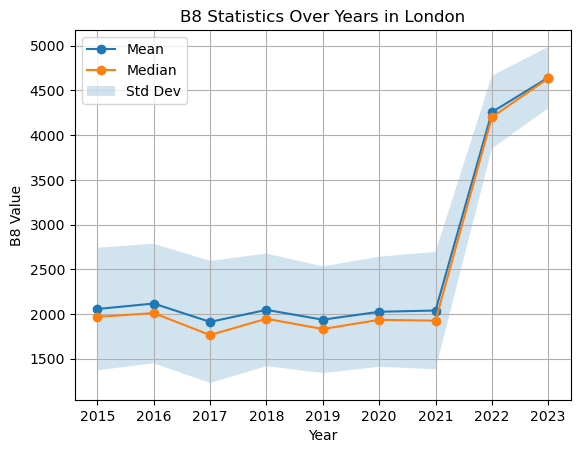

In [16]:
final_df.head()

# Plot the results for each city and band
for city in cities:
    for band in bands:
        plt.figure()
        subset_df = final_df[(final_df['City'] == city) & (final_df['Band'] == band)]
        plt.plot(subset_df['Year'], subset_df['Mean'], label='Mean', marker='o')
        plt.plot(subset_df['Year'], subset_df['Median'], label='Median', marker='o')
        plt.fill_between(subset_df['Year'], 
                         subset_df['Mean'] - subset_df['Std'], 
                         subset_df['Mean'] + subset_df['Std'], 
                         alpha=0.2, label='Std Dev')
        plt.title(f'{band} Statistics Over Years in {city}')
        plt.xlabel('Year')
        plt.ylabel(f'{band} Value')
        plt.legend()
        plt.grid(True)
        plt.show()


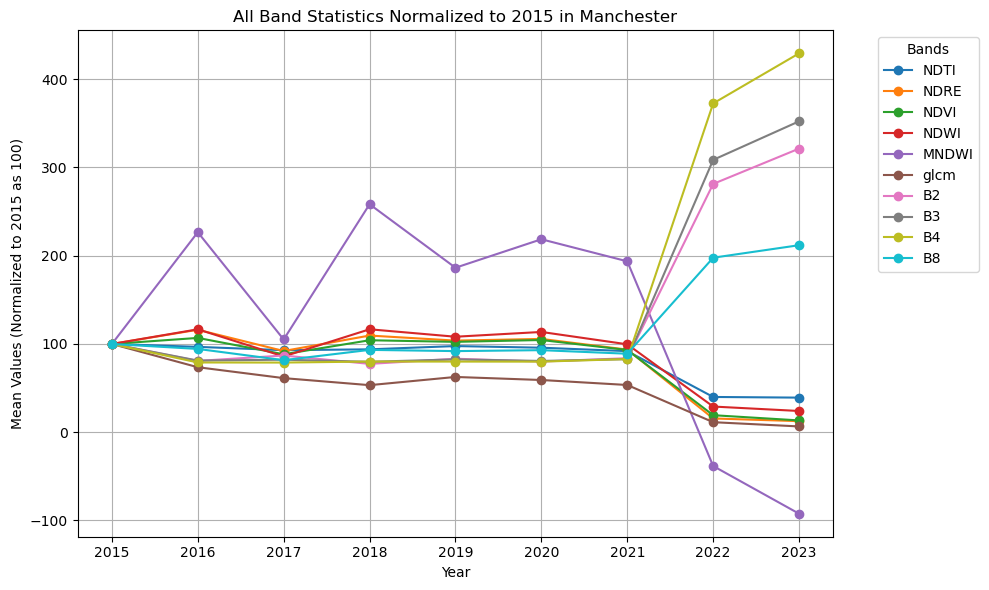

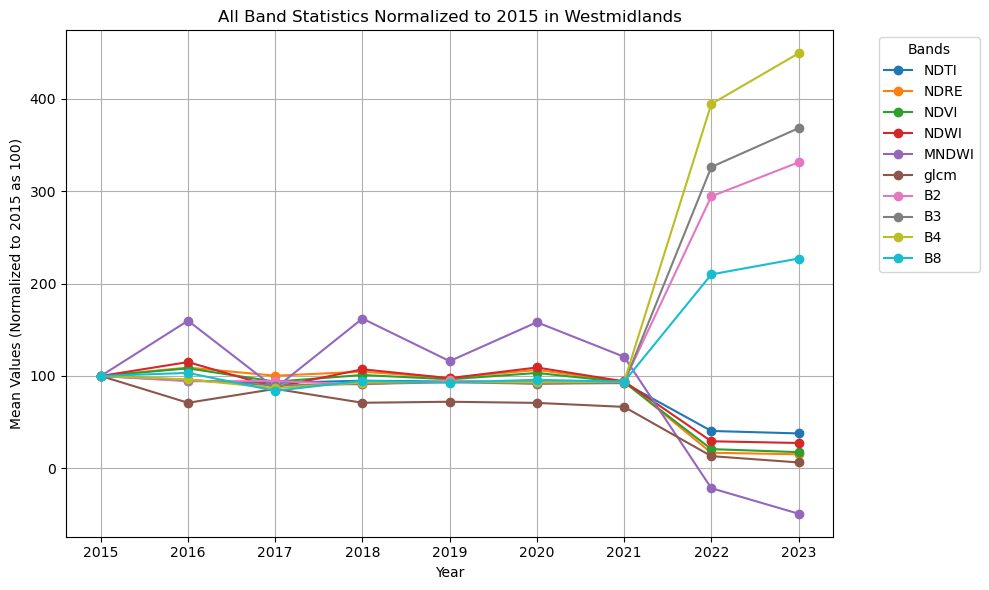

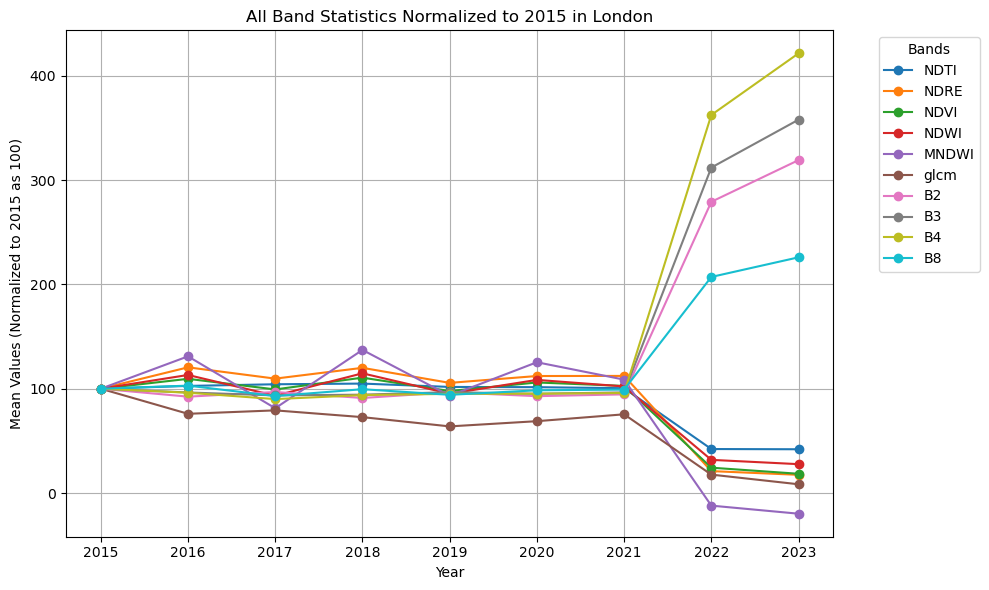

In [19]:
reference_year = 2015 

reference_values = {}

for city in cities:
    for band in bands:
        ref_df = final_df[(final_df['City'] == city) & (final_df['Band'] == band) & (final_df['Year'] == reference_year)]
        if not ref_df.empty:
            reference_values[(city, band)] = ref_df['Mean'].values[0]
        else:
            reference_values[(city, band)] = np.nan  # Handle cases where no data exists for the reference year

for city in cities:
    plt.figure(figsize=(10, 6))
    for band in bands:
        subset_df = final_df[(final_df['City'] == city) & (final_df['Band'] == band)]
        if reference_values[(city, band)] != 0 and not np.isnan(reference_values[(city, band)]):
            normalized_means = 100 * subset_df['Mean'] / reference_values[(city, band)]
            plt.plot(subset_df['Year'], normalized_means, label=band, marker='o')
        else:
            plt.plot(subset_df['Year'], [np.nan] * len(subset_df['Year']), label=band, marker='o')  # Plot NaNs if reference is zero or NaN

    plt.title(f'All Band Statistics Normalized to {reference_year} in {city}')
    plt.xlabel('Year')
    plt.ylabel(f'Mean Values (Normalized to {reference_year} as 100)')
    plt.legend(title="Bands", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Surface Temperature

In [3]:
# Read temperature data
temp_data = pd.read_csv("temperature_data_B10_ver2.csv")

# Merge the dataframes on 'postcode' and 'year'
combined_data = pd.merge(gi_data, temp_data, on=["postcode", "year"], how="left")

# Convert columns to numeric and filter out rows with missing temperature values
combined_data['green_proportion'] = pd.to_numeric(combined_data['green_proportion'], errors='coerce')
combined_data['temperature'] = pd.to_numeric(combined_data['temperature'], errors='coerce')
combined_data = combined_data.dropna(subset=['temperature'])

## Simple multiple linear regression

In [16]:
for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = combined_data[combined_data['buffer_radius'] == radius]

    # Convert 'city' and 'year' to categorical data types
    df_subset['city'] = df_subset['city'].astype('category')
    df_subset['year'] = df_subset['year'].astype('int')

    # Fit the linear model with fixed effects for 'city'
    formula = 'temperature ~ green_proportion + C(year) + C(city)'
    model = smf.ols(formula=formula, data=df_subset).fit()
    
    # Print summary of the model
    print(f"Results for buffer radius: {radius}")
    print(model.summary())

    # # Plot diagnostics: Checking for normality of residuals
    # sm.graphics.plot_regress_exog(model, 'green_proportion', fig=plt.figure(figsize=(12, 8)))

    # Checking for heteroscedasticity with Bartlett's test (equivalent to Breusch-Pagan test)
    _, p_value = bartlett(model.fittedvalues, model.resid)
    print(f"Bartlett's test p-value: {p_value}")


/tmp/ipykernel_24092/1830658374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_24092/1830658374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype('int')


Results for buffer radius: 482
                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                 1.671e+05
Date:                Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:00:46   Log-Likelihood:            -9.8237e+06
No. Observations:             2785109   AIC:                         1.965e+07
Df Residuals:                 2785097   BIC:                         1.965e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/tmp/ipykernel_24092/1830658374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_24092/1830658374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype('int')


Results for buffer radius: 965
                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                 1.667e+05
Date:                Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:00:53   Log-Likelihood:            -9.8250e+06
No. Observations:             2785109   AIC:                         1.965e+07
Df Residuals:                 2785097   BIC:                         1.965e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/tmp/ipykernel_24092/1830658374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_24092/1830658374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype('int')


Results for buffer radius: 1890
                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                 1.664e+05
Date:                Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:01:00   Log-Likelihood:            -9.8260e+06
No. Observations:             2785109   AIC:                         1.965e+07
Df Residuals:                 2785097   BIC:                         1.965e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

/tmp/ipykernel_24092/1830658374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_24092/1830658374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype('int')


Results for buffer radius: 2816
                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                 1.663e+05
Date:                Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:01:07   Log-Likelihood:            -9.8264e+06
No. Observations:             2785109   AIC:                         1.965e+07
Df Residuals:                 2785097   BIC:                         1.965e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

## Fixed Effect regrssion

/tmp/ipykernel_7186/4065432041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_7186/4065432041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Results for buffer radius: 482
                          PanelOLS Estimation Summary                           
Dep. Variable:            temperature   R-squared:                        0.0033
Estimator:                   PanelOLS   R-squared (Between):             -0.1521
No. Observations:             2785109   R-squared (Within):               0.0006
Date:                Sat, Aug 03 2024   R-squared (Overall):              0.0100
Time:                        19:52:55   Log-likelihood                -9.824e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      9300.3
Entities:                           3   P-value                           0.0000
Avg Obs:                    9.284e+05   Distribution:               F(1,2785097)
Min Obs:                    5.218e+05                                           
Max Obs:                    1.627e+06   F-statistic (robust):             11.9

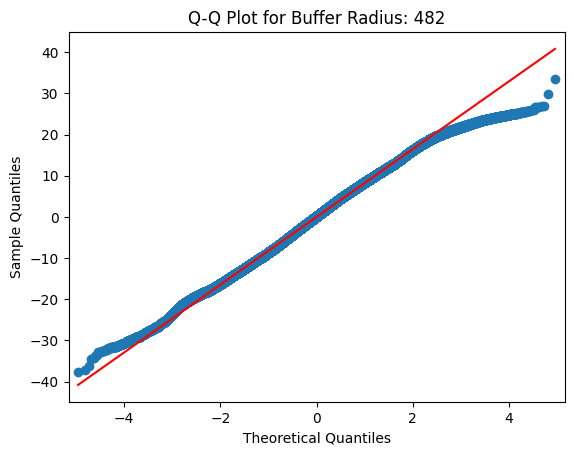

Normality test p-value: 0.0


/tmp/ipykernel_7186/4065432041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_7186/4065432041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Results for buffer radius: 965
                          PanelOLS Estimation Summary                           
Dep. Variable:            temperature   R-squared:                        0.0024
Estimator:                   PanelOLS   R-squared (Between):             -0.1622
No. Observations:             2785109   R-squared (Within):            9.431e-05
Date:                Sat, Aug 03 2024   R-squared (Overall):              0.0085
Time:                        19:53:01   Log-likelihood                -9.825e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6673.1
Entities:                           3   P-value                           0.0000
Avg Obs:                    9.284e+05   Distribution:               F(1,2785097)
Min Obs:                    5.218e+05                                           
Max Obs:                    1.627e+06   F-statistic (robust):             9.86

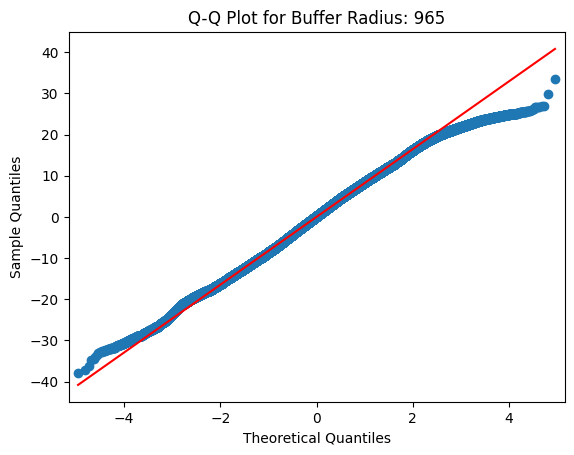

Normality test p-value: 0.0


/tmp/ipykernel_7186/4065432041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_7186/4065432041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Results for buffer radius: 1890
                          PanelOLS Estimation Summary                           
Dep. Variable:            temperature   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):             -0.1689
No. Observations:             2785109   R-squared (Within):              -0.0003
Date:                Sat, Aug 03 2024   R-squared (Overall):              0.0075
Time:                        19:53:07   Log-likelihood                -9.826e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4722.1
Entities:                           3   P-value                           0.0000
Avg Obs:                    9.284e+05   Distribution:               F(1,2785097)
Min Obs:                    5.218e+05                                           
Max Obs:                    1.627e+06   F-statistic (robust):             7.4

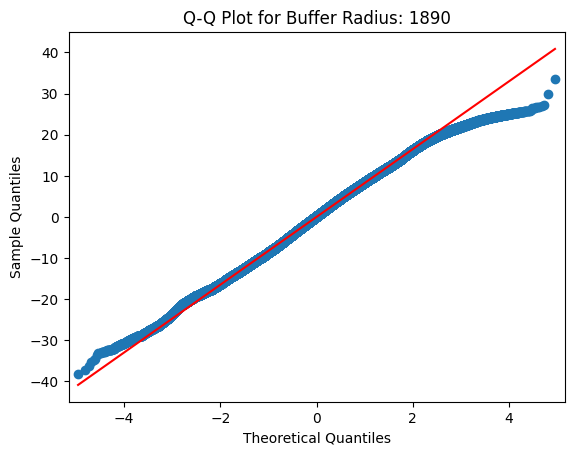

Normality test p-value: 0.0


/tmp/ipykernel_7186/4065432041.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_7186/4065432041.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

Results for buffer radius: 2816
                          PanelOLS Estimation Summary                           
Dep. Variable:            temperature   R-squared:                        0.0014
Estimator:                   PanelOLS   R-squared (Between):             -0.1687
No. Observations:             2785109   R-squared (Within):              -0.0005
Date:                Sat, Aug 03 2024   R-squared (Overall):              0.0074
Time:                        19:53:13   Log-likelihood                -9.826e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3969.5
Entities:                           3   P-value                           0.0000
Avg Obs:                    9.284e+05   Distribution:               F(1,2785097)
Min Obs:                    5.218e+05                                           
Max Obs:                    1.627e+06   F-statistic (robust):             6.3

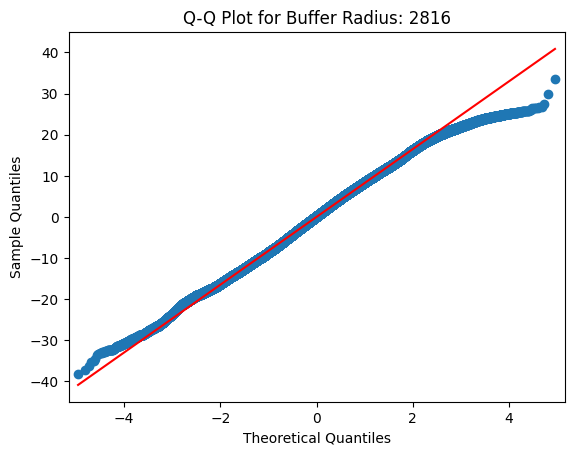

Normality test p-value: 0.0


In [13]:

for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = combined_data[combined_data['buffer_radius'] == radius]

    # Convert 'city' and 'year' to categorical data types for fixed effects
    df_subset['city'] = df_subset['city'].astype('category')
    df_subset['year'] = df_subset['year'].astype(int)

    # Set multi-index for PanelOLS
    df_subset = df_subset.set_index(['city', 'year'])

    # Fit the fixed effects model with fixed effects for 'city' and 'year'
    exog_vars = ['green_proportion']
    exog = sm.add_constant(df_subset[exog_vars])
    endog = df_subset['temperature']

    # PanelOLS with entity and time effects
    model = PanelOLS(endog, exog, entity_effects=True, time_effects=True, drop_absorbed=True)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    # Print summary of the model
    print(f"Results for buffer radius: {radius}")
    print(result.summary)

    # Diagnostics: Checking for normality of residuals
    sm.qqplot(result.resids, line='s')
    plt.title(f"Q-Q Plot for Buffer Radius: {radius}")
    plt.show()

    # Checking for heteroscedasticity using normality test (as an alternative diagnostic)
    _, p_value = normaltest(result.resids)
    print(f"Normality test p-value: {p_value}")

/tmp/ipykernel_7186/4178100021.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['postcode'].astype('category')
/tmp/ipykernel_7186/4178100021.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)


Results for buffer radius: 482
                          PanelOLS Estimation Summary                           
Dep. Variable:            temperature   R-squared:                        0.0008
Estimator:                   PanelOLS   R-squared (Between):              0.0985
No. Observations:             2785109   R-squared (Within):              -0.0027
Date:                Sat, Aug 03 2024   R-squared (Overall):              0.0144
Time:                        20:00:27   Log-likelihood                -9.732e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1893.3
Entities:                      309488   P-value                           0.0000
Avg Obs:                       8.9991   Distribution:               F(1,2475612)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             1929

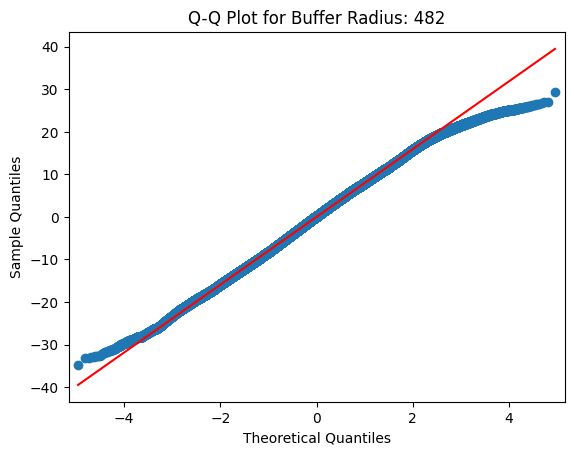

Normality test p-value: 0.0


/tmp/ipykernel_7186/4178100021.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['postcode'].astype('category')
/tmp/ipykernel_7186/4178100021.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)


Results for buffer radius: 965
                          PanelOLS Estimation Summary                           
Dep. Variable:            temperature   R-squared:                        0.0007
Estimator:                   PanelOLS   R-squared (Between):              0.0975
No. Observations:             2785109   R-squared (Within):              -0.0031
Date:                Sat, Aug 03 2024   R-squared (Overall):              0.0139
Time:                        20:00:44   Log-likelihood                -9.732e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1760.9
Entities:                      309488   P-value                           0.0000
Avg Obs:                       8.9991   Distribution:               F(1,2475612)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             1799

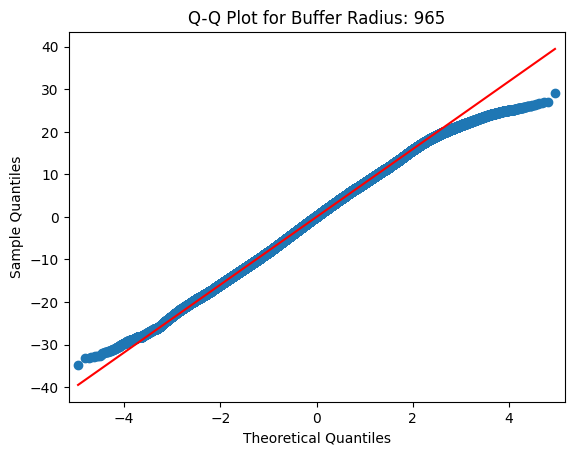

Normality test p-value: 0.0


/tmp/ipykernel_7186/4178100021.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['postcode'].astype('category')
/tmp/ipykernel_7186/4178100021.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)


Results for buffer radius: 1890
                          PanelOLS Estimation Summary                           
Dep. Variable:            temperature   R-squared:                        0.0008
Estimator:                   PanelOLS   R-squared (Between):              0.1050
No. Observations:             2785109   R-squared (Within):              -0.0039
Date:                Sat, Aug 03 2024   R-squared (Overall):              0.0145
Time:                        20:01:00   Log-likelihood                -9.732e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1950.7
Entities:                      309488   P-value                           0.0000
Avg Obs:                       8.9991   Distribution:               F(1,2475612)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             200

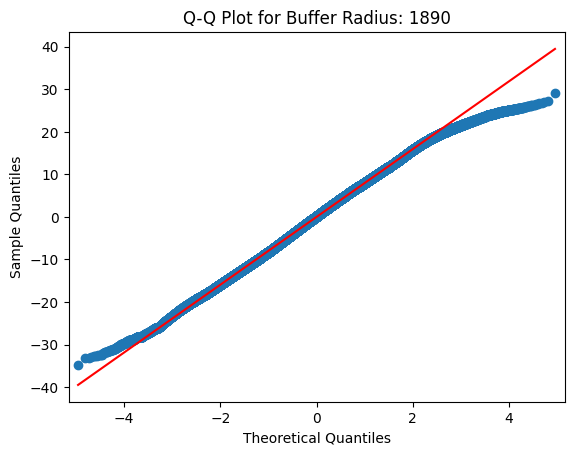

Normality test p-value: 0.0


/tmp/ipykernel_7186/4178100021.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['postcode'].astype('category')
/tmp/ipykernel_7186/4178100021.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)


Results for buffer radius: 2816
                          PanelOLS Estimation Summary                           
Dep. Variable:            temperature   R-squared:                        0.0009
Estimator:                   PanelOLS   R-squared (Between):              0.1166
No. Observations:             2785109   R-squared (Within):              -0.0045
Date:                Sat, Aug 03 2024   R-squared (Overall):              0.0160
Time:                        20:01:17   Log-likelihood                -9.732e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2184.6
Entities:                      309488   P-value                           0.0000
Avg Obs:                       8.9991   Distribution:               F(1,2475612)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             228

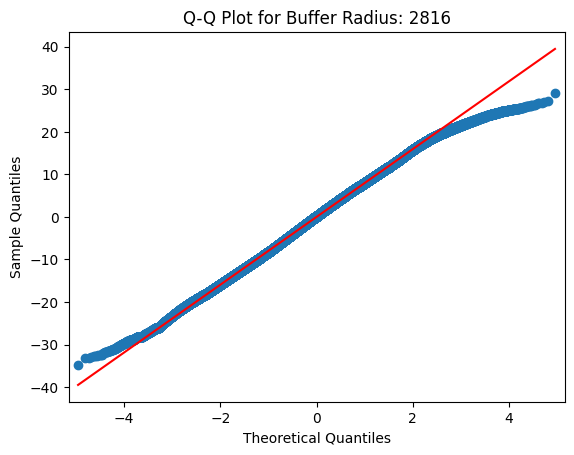

Normality test p-value: 0.0


In [14]:
for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = combined_data[combined_data['buffer_radius'] == radius]

    # Convert 'city' and 'year' to categorical data types for fixed effects
    df_subset['city'] = df_subset['postcode'].astype('category')
    df_subset['year'] = df_subset['year'].astype(int)

    # Set multi-index for PanelOLS
    df_subset = df_subset.set_index(['postcode', 'year'])

    # Fit the fixed effects model with fixed effects for 'city' and 'year'
    exog_vars = ['green_proportion']
    exog = sm.add_constant(df_subset[exog_vars])
    endog = df_subset['temperature']

    # PanelOLS with entity and time effects
    model = PanelOLS(endog, exog, entity_effects=True, time_effects=True, drop_absorbed=True)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    # Print summary of the model
    print(f"Results for buffer radius: {radius}")
    print(result.summary)

    # Diagnostics: Checking for normality of residuals
    sm.qqplot(result.resids, line='s')
    plt.title(f"Q-Q Plot for Buffer Radius: {radius}")
    plt.show()

    # Checking for heteroscedasticity using normality test (as an alternative diagnostic)
    _, p_value = normaltest(result.resids)
    print(f"Normality test p-value: {p_value}")

## Quantile Regression: Are the impacts of green infrastructure on temperature more significant in regions that are already experiencing higher temperatures?

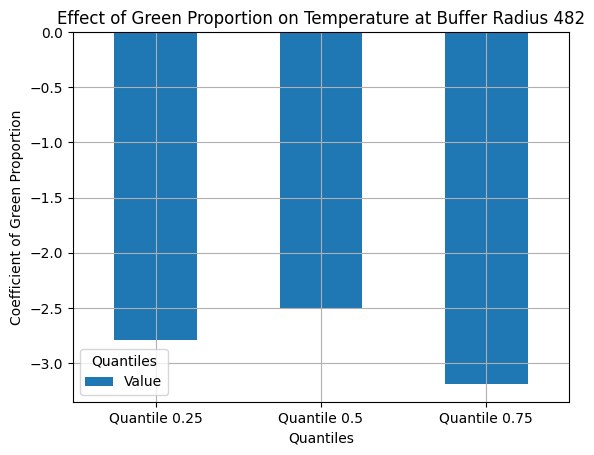

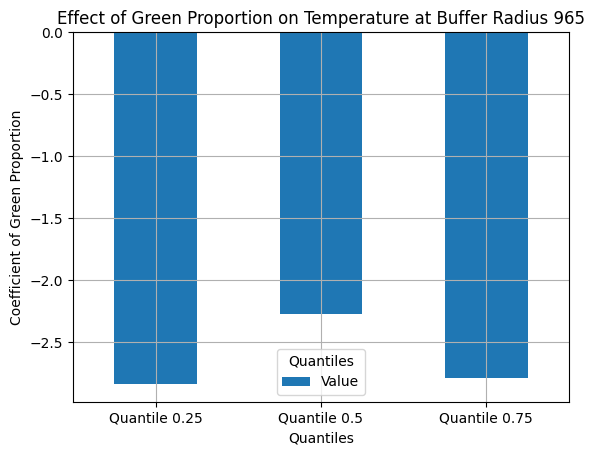

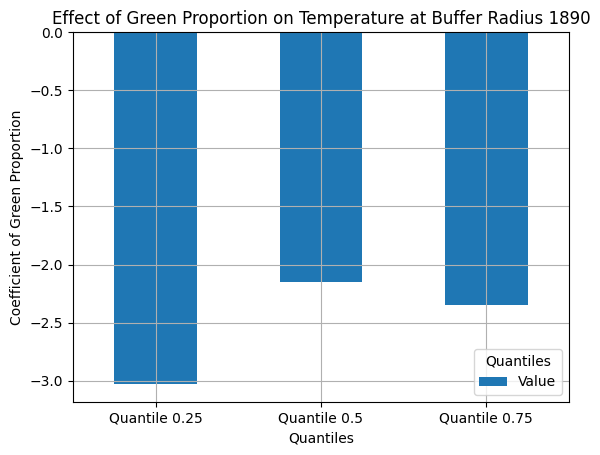

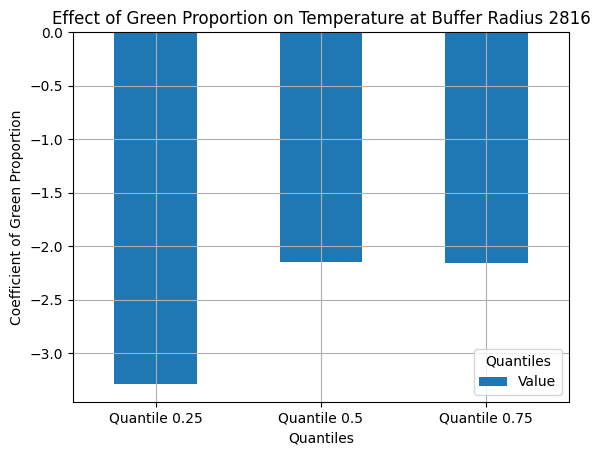

In [11]:
def quantile_regression(df, quantile):
    formula = 'temperature ~ green_proportion + C(year) + C(city)'
    model_quant = smf.quantreg(formula, data=df).fit(q=quantile)
    return model_quant

quantiles = [0.25, 0.50, 0.75]
buffer_radii = [482, 965, 1890, 2816]

# Enhanced plotting within the loop
for radius in buffer_radii:
    df_subset = combined_data[combined_data['buffer_radius'] == radius]
    results = {q: quantile_regression(df_subset, q) for q in quantiles}

    # Creating DataFrame with an index
    coefs = pd.DataFrame({f'Quantile {q}': results[q].params['green_proportion'] for q in quantiles}, index=['Value'])
    
    # Using a bar chart instead of line plot
    coefs.T.plot(kind='bar', title=f'Effect of Green Proportion on Temperature at Buffer Radius {radius}')
    plt.xlabel('Quantiles')
    plt.ylabel('Coefficient of Green Proportion')
    plt.grid(True)
    plt.legend(title='Quantiles')
    plt.xticks(rotation=0)  # Keeps the quantile labels horizontal
    plt.show()

In [19]:
np.linspace(0.1, 0.9, 9)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

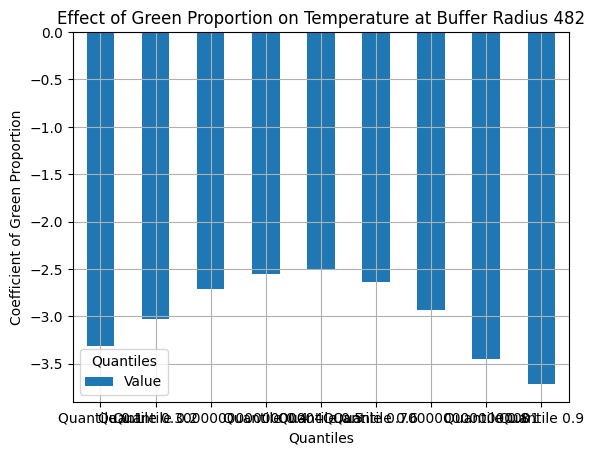

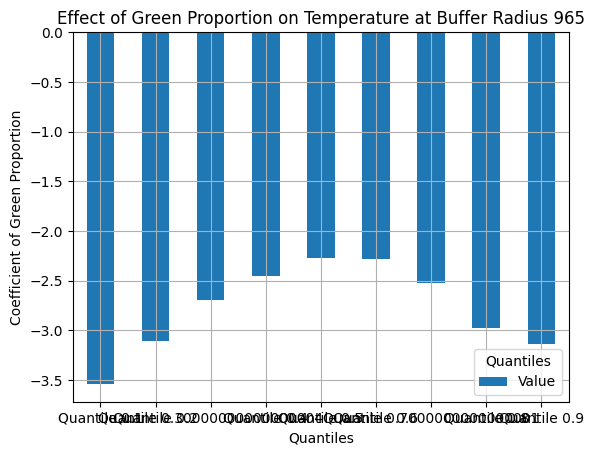

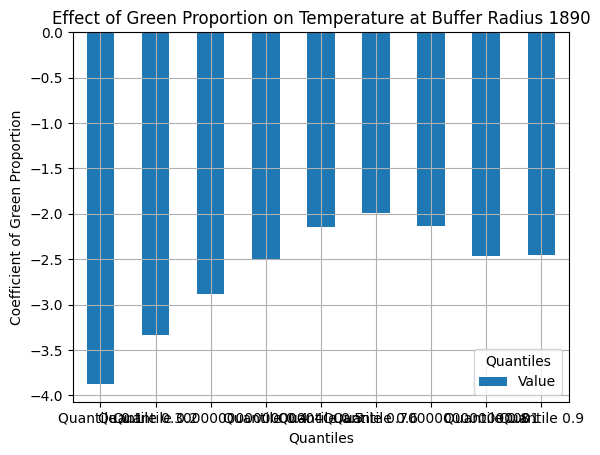

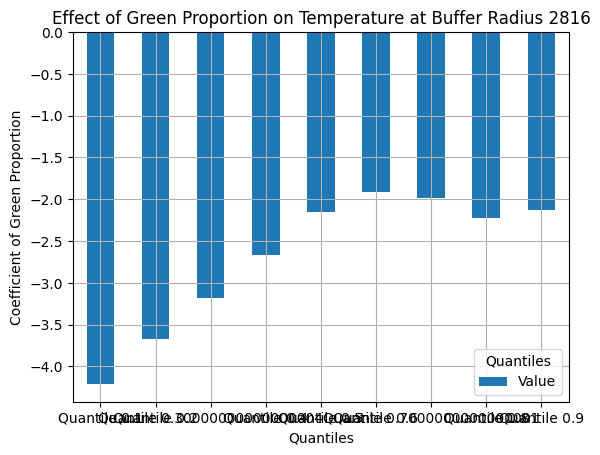

In [20]:
def quantile_regression(df, quantile):
    formula = 'temperature ~ green_proportion + C(year) + C(city)'
    model_quant = smf.quantreg(formula, data=df).fit(q=quantile)
    return model_quant

quantiles = np.linspace(0.1, 0.9, 9)
buffer_radii = [482, 965, 1890, 2816]

# Enhanced plotting within the loop
for radius in buffer_radii:
    df_subset = combined_data[combined_data['buffer_radius'] == radius]
    results = {q: quantile_regression(df_subset, q) for q in quantiles}

    # Creating DataFrame with an index
    coefs = pd.DataFrame({f'Quantile {q}': results[q].params['green_proportion'] for q in quantiles}, index=['Value'])
    
    # Using a bar chart instead of line plot
    coefs.T.plot(kind='bar', title=f'Effect of Green Proportion on Temperature at Buffer Radius {radius}')
    plt.xlabel('Quantiles')
    plt.ylabel('Coefficient of Green Proportion')
    plt.grid(True)
    plt.legend(title='Quantiles')
    plt.xticks(rotation=0)  # Keeps the quantile labels horizontal
    plt.show()

## spline regression: Does specific percentage of GI is more impactful?

In [26]:
model_spline = smf.ols('temperature ~ bs(green_proportion, knots=(0.25, 0.5, 0.75), degree=3, include_intercept=True) +  C(year) + C(city)', data=combined_data).fit()

print(model_spline.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                 4.359e+05
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:22:41   Log-Likelihood:            -3.9277e+07
No. Observations:            11140436   AIC:                         7.855e+07
Df Residuals:                11140418   BIC:                         7.855e+07
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [30]:
model_spline = smf.ols('temperature ~ bs(green_proportion, knots=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7), degree=1, include_intercept=True) +  C(year) + C(city)', data=combined_data).fit()

print(model_spline.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                 3.900e+05
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:33:23   Log-Likelihood:            -3.9277e+07
No. Observations:            11140436   AIC:                         7.855e+07
Df Residuals:                11140416   BIC:                         7.856e+07
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Threshold Regression: what proportion is the most impactful?

In [ ]:
combined_data[['green_proportion', 'segment_1', 'segment_2', 'segment_3', 'segment_4', 'segment_5', 'segment_6', 'segment_7']]

In [43]:
breakpoints = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
'temperature ~ ' + 'C(year) + C(city) + ' + ' + '.join([f'segment_{i}' for i in range(len(breakpoints) + 1)])

'temperature ~ C(year) + C(city) + segment_0 + segment_1 + segment_2 + segment_3 + segment_4 + segment_5 + segment_6 + segment_7 + segment_8 + segment_9'

In [44]:
def fit_segmented_model(df, breakpoints):
    # Ensure data is sorted by green_proportion if not already
    df = df.sort_values(by='green_proportion')

    # Adding columns for segmented regression
    # Create a base segment from 0 to the first breakpoint
    df['segment_0'] = df['green_proportion'].apply(lambda x: min(x, breakpoints[0]))

    # Create segments between each pair of breakpoints
    for i in range(1, len(breakpoints)):
        column_name = f'segment_{i}'
        lower_bound = breakpoints[i - 1]
        upper_bound = breakpoints[i]
        df[column_name] = df['green_proportion'].apply(lambda x: max(0, min(x - lower_bound, upper_bound - lower_bound)))

    # Add segment after the last breakpoint
    df[f'segment_{len(breakpoints)}'] = df['green_proportion'].apply(lambda x: max(0, x - breakpoints[-1]))

    # Build the formula for the OLS model
    formula = 'temperature ~ ' + 'C(year) + C(city) + ' + ' + '.join([f'segment_{i}' for i in range(len(breakpoints) + 1)])
    model = smf.ols(formula, data=df).fit()
    return model

breakpoints = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  # Define your breakpoints
seg_model = fit_segmented_model(combined_data, breakpoints)
print(seg_model.summary())

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                 4.117e+05
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:09:24   Log-Likelihood:            -3.9277e+07
No. Observations:            11140436   AIC:                         7.855e+07
Df Residuals:                11140417   BIC:                         7.856e+07
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['green_proportion'], combined_data['temperature'], color='gray', alpha=0.5)
plt.plot(combined_data['green_proportion'], seg_model.fittedvalues, color='red', label='Fitted values')
plt.xlabel('Green Proportion')
plt.ylabel('Temperature')
plt.title('Segmented Regression Fit')
plt.legend()
plt.show()

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                 3.138e+04
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        14:02:43   Log-Likelihood:            -4.1994e+07
No. Observations:            11140436   AIC:                         8.399e+07
Df Residuals:                11140427   BIC:                         8.399e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          289.5203      0.022  

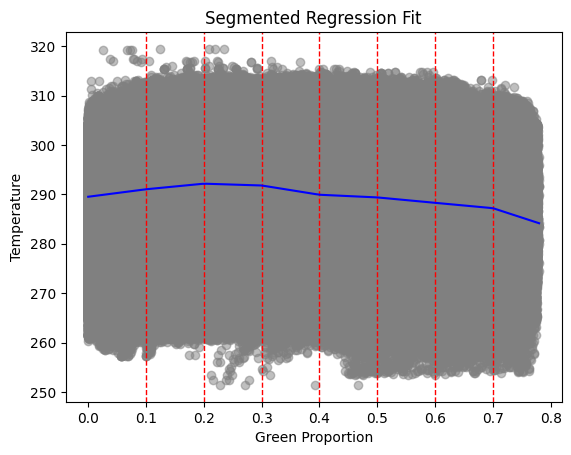

In [34]:
breakpoints = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]  
# Function to apply segmented regression
def segmented_regression(df, x_col, y_col, breakpoints):
    # Add a column for each segment
    for i, point in enumerate(breakpoints, start=1):
        df[f'segment_{i}'] = df[x_col].apply(lambda x: x - point if x > point else 0)

    # Model formula
    formula_parts = [y_col, x_col] + [f'segment_{i}' for i in range(1, len(breakpoints) + 1)]
    formula = ' ~ '.join([formula_parts[0], ' + '.join(formula_parts[1:])])

    # Fit the model
    model = sm.OLS.from_formula(formula, data=df).fit()
    return model

# Example usage
seg_model = segmented_regression(combined_data, 'green_proportion', 'temperature', breakpoints)

# Print the summary of the segmented model
print(seg_model.summary())

# Plot the data and the fitted model
plt.scatter(combined_data['green_proportion'], combined_data['temperature'], color='gray', alpha=0.5)
for point in breakpoints:
    plt.axvline(x=point, color='red', linestyle='--', linewidth=1)
    
# Prepare data for the prediction line
x_range = np.linspace(combined_data['green_proportion'].min(), combined_data['green_proportion'].max(), 100)
df_pred = pd.DataFrame(x_range, columns=['green_proportion'])
for i, point in enumerate(breakpoints, start=1):
    df_pred[f'segment_{i}'] = df_pred['green_proportion'].apply(lambda x: x - point if x > point else 0)

# Predict and plot
y_pred = seg_model.predict(df_pred)
plt.plot(x_range, y_pred, color='blue')
plt.xlabel('Green Proportion')
plt.ylabel('Temperature')
plt.title('Segmented Regression Fit')
plt.show()

## Polynomial Regression

In [53]:
combined_data['green_proportion_squared'] = combined_data['green_proportion'] ** 2
model_poly_squared = smf.ols('temperature ~ green_proportion + green_proportion_squared + C(year) + C(city)', data=combined_data).fit()
print(model_poly_squared.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                 6.149e+05
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:01:30   Log-Likelihood:            -3.9287e+07
No. Observations:            11140436   AIC:                         7.857e+07
Df Residuals:                11140423   BIC:                         7.857e+07
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [54]:
combined_data['green_proportion_cubed'] = combined_data['green_proportion'] ** 3
model_poly_cubed = smf.ols('temperature ~ green_proportion + green_proportion_squared + green_proportion_cubed + C(year) + C(city)', data=combined_data).fit()
print(model_poly_cubed.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                 5.693e+05
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:02:03   Log-Likelihood:            -3.9280e+07
No. Observations:            11140436   AIC:                         7.856e+07
Df Residuals:                11140422   BIC:                         7.856e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

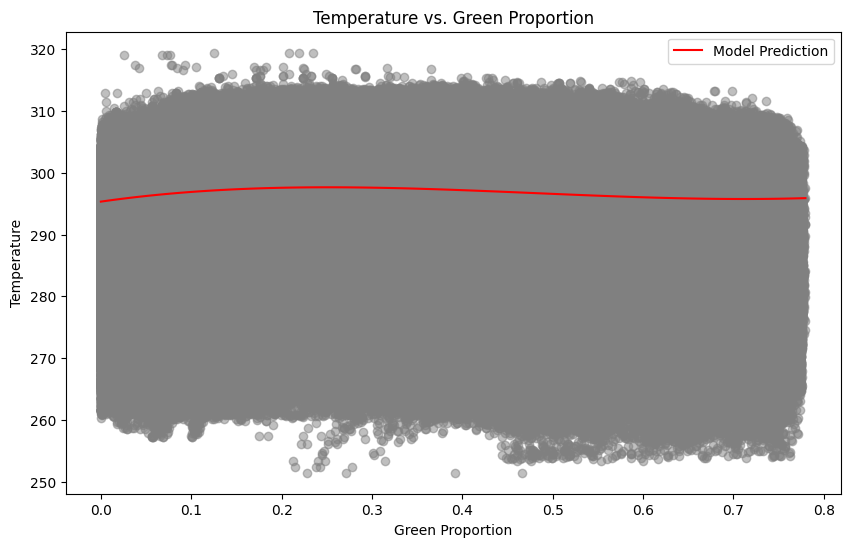

In [61]:
combined_data['year'] = combined_data['year'].astype('category')
combined_data['city'] = combined_data['city'].astype('category')

# Prepare data for prediction
x_range = np.linspace(combined_data['green_proportion'].min(), combined_data['green_proportion'].max(), 100)
df_plot = pd.DataFrame(x_range, columns=['green_proportion'])
df_plot['green_proportion_squared'] = df_plot['green_proportion']**2
df_plot['green_proportion_cubed'] = df_plot['green_proportion']**3

# Using modal values for categorical predictions
mode_year = combined_data['year'].mode()[0]
mode_city = combined_data['city'].mode()[0]
df_plot['year'] = mode_year
df_plot['city'] = mode_city

# Ensure categories are consistent
df_plot['year'] = pd.Categorical(df_plot['year'], categories=combined_data['year'].cat.categories)
df_plot['city'] = pd.Categorical(df_plot['city'], categories=combined_data['city'].cat.categories)

# Assume model_poly_cubed is already fitted
# Predict using the fitted model
predictions = model_poly_cubed.predict(df_plot)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['green_proportion'], combined_data['temperature'], color='gray', alpha=0.5)  # Actual data
plt.plot(x_range, predictions, color='red', label='Model Prediction')  # Model predictions
plt.xlabel('Green Proportion')
plt.ylabel('Temperature')
plt.title('Temperature vs. Green Proportion')
plt.legend()
plt.show()

## What percentage of GI is most impactful? >> Not valid approach

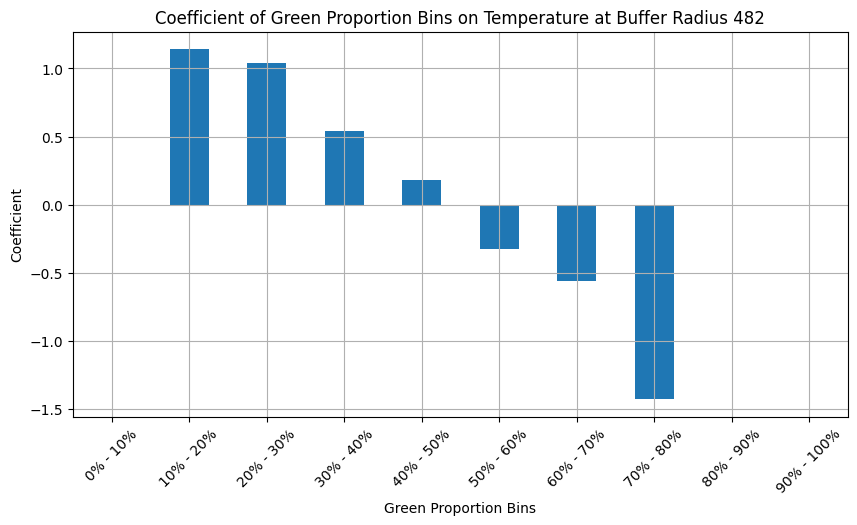

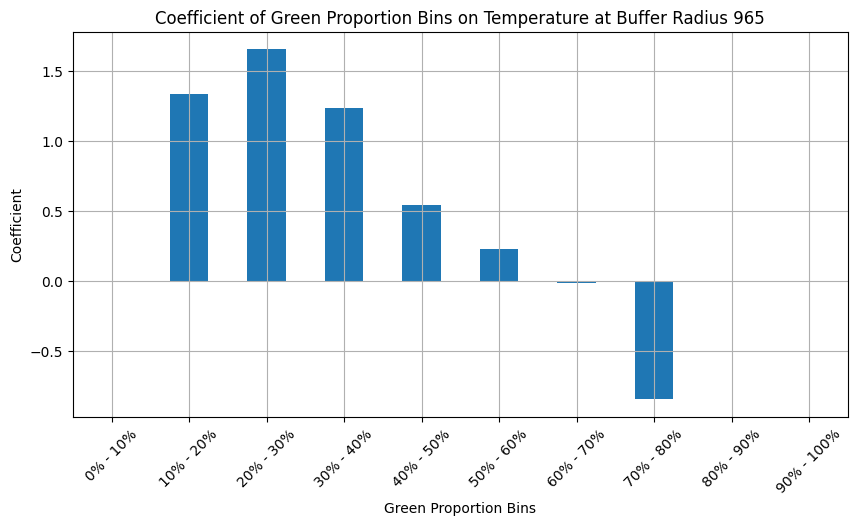

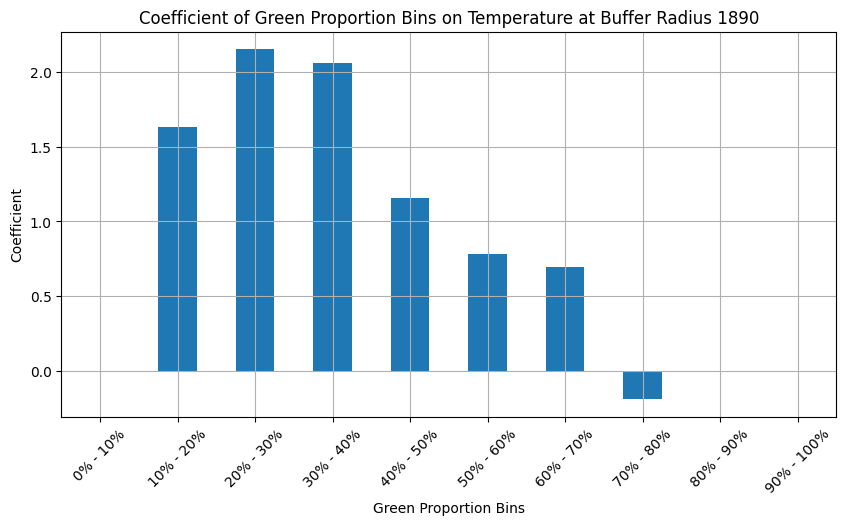

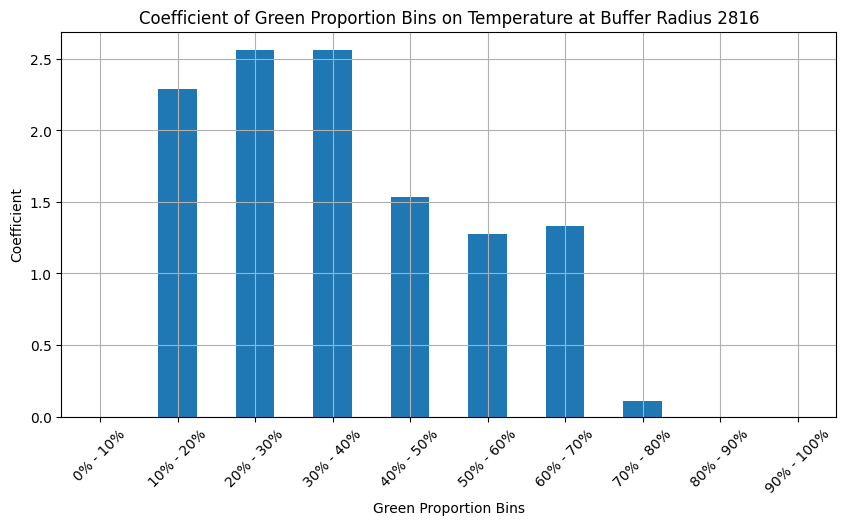

In [13]:

# Define bins for the green_proportion column to segment into deciles
bins = np.arange(0, 1.1, 0.1)  # Creates bins from 0 to 1 with a step of 0.1
labels = [f'{int(bins[i]*100)}% - {int(bins[i+1]*100)}%' for i in range(len(bins)-1)]
combined_data['green_proportion_bins'] = pd.cut(combined_data['green_proportion'], bins=bins, labels=labels, include_lowest=True, right=False)

def linear_regression(df):
    formula = 'temperature ~ C(green_proportion_bins) + C(year) + C(city)'
    model_lin = smf.ols(formula, data=df).fit()
    return model_lin

buffer_radii = [482, 965, 1890, 2816]

# Collect results for each buffer radius and plot
for radius in buffer_radii:
    df_subset = combined_data[combined_data['buffer_radius'] == radius]
    result = linear_regression(df_subset)

    # Extract coefficients for green_proportion_bins
    coef_series = pd.Series({label: result.params.get(f'C(green_proportion_bins)[T.{label}]', np.nan)
                             for label in labels})
    coef_series.plot(kind='bar', figsize=(10, 5), title=f'Coefficient of Green Proportion Bins on Temperature at Buffer Radius {radius}')
    plt.xlabel('Green Proportion Bins')
    plt.ylabel('Coefficient')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

# Real Estate

In [4]:
pp_data = pd.read_csv("../pp-complete.csv")
# pp_data.reset_index(drop=True, inplace=True)

# Define the correct column names
column_names = [
    "transaction_unique_identifier", "price", "date_of_transfer", "postcode", 
    "property_type", "old_new", "duration", "paon", "saon", "street", 
    "locality", "town_city", "district", "county", "ppd_category_type", "record_status"
]

pp_data.columns = column_names

In [5]:
pp_data['year'] = pd.to_datetime(pp_data['date_of_transfer']).dt.year

pp_combined_data = pd.merge(gi_data, pp_data, on=["postcode", "year"], how="left")

pp_combined_data['green_proportion'] = pd.to_numeric(pp_combined_data['green_proportion'], errors='coerce')
pp_combined_data['temperature'] = pd.to_numeric(pp_combined_data['price'], errors='coerce')
pp_combined_data = pp_combined_data.dropna(subset=['price','green_proportion'])

In [19]:
len(pp_combined_data)

8613996

In [5]:
pp_combined_data[['postcode',"green_proportion","city","year","buffer_radius", "date_of_transfer", "postcode", 
    "property_type", "old_new", "duration", "paon", "saon", "street", 
    "locality", "town_city", "district", "county", "ppd_category_type", "record_status"]]
pp_data=None

In [6]:
postcode_data = pd.read_csv("../ukpostcodes.csv")
postcode_data = gpd.GeoDataFrame(
    postcode_data,
    geometry=gpd.points_from_xy(postcode_data.longitude, postcode_data.latitude),
    crs="EPSG:4326"
).to_crs(epsg=27700)

# Load city boundaries and filter postcodes within these boundaries
boundaries = {
    'Greater_Manchester': gpd.read_file("../urban_greenspace_classification/Boundaries/LA_Manchester.shp"),
    'Greater_London': gpd.read_file("../urban_greenspace_classification/Boundaries/LA_London.shp"),
    'West_Midlands': gpd.read_file("../urban_greenspace_classification/Boundaries/LA_Westmindlands.shp")
}

# Define city centers (convert to EPSG:27700)
city_centers = {
    'Greater_Manchester': Point(-2.1578, 53.4576),
    'Greater_London': Point(-0.0910, 51.5123),
    'West_Midlands': Point(-1.8964, 52.4820)
}

# Convert city center points to the same CRS as the postcode data (EPSG:27700)
city_centers = {city: gpd.GeoSeries([center], crs="EPSG:4326").to_crs(epsg=27700).iloc[0] 
                for city, center in city_centers.items()}

def calculate_distance_to_center(row, city_name):
    city_center = city_centers[city_name]
    return row.geometry.distance(city_center)

all_city_postcodes = []

for city, city_boundaries in boundaries.items():
    city_boundaries = city_boundaries.to_crs(epsg=27700)
    city_postcodes = gpd.sjoin(postcode_data, city_boundaries, how='inner', predicate='intersects')
    city_postcodes['distance_to_center'] = city_postcodes.apply(lambda row: calculate_distance_to_center(row, city), axis=1)
    all_city_postcodes.append(city_postcodes)

final_postcodes = pd.concat(all_city_postcodes, ignore_index=True)

In [23]:
final_postcodes['postcode'].nunique()

310999

In [24]:
pp_combined_data['postcode'].nunique()

275680

/tmp/ipykernel_12881/3857496083.py:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


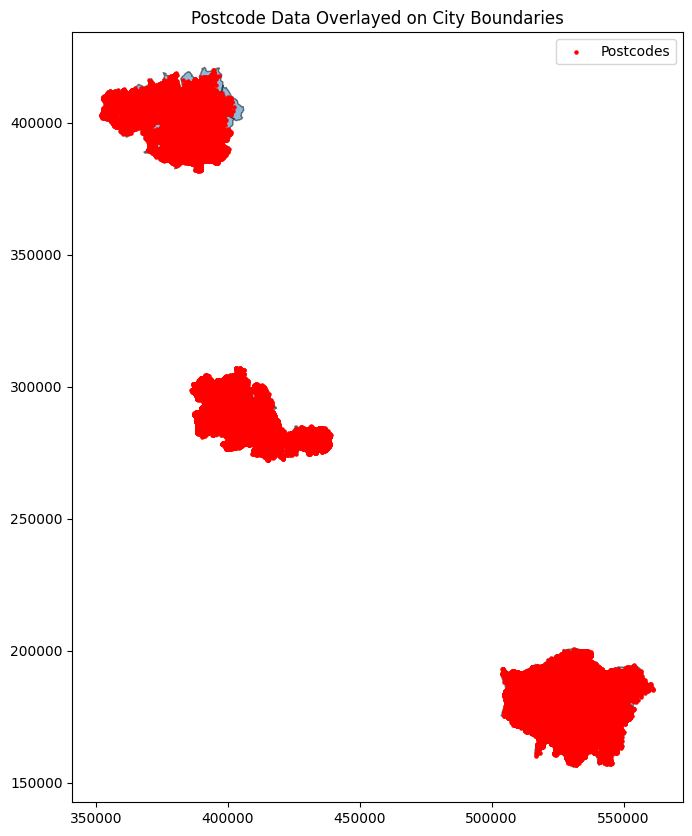

In [101]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each city's boundaries with a different color
for city, city_boundary in boundaries.items():
    city_boundary.to_crs(epsg=27700).plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.5, label=f'{city} Boundary')

# Plot the postcodes on top
final_postcodes.plot(ax=ax, color='red', markersize=5, label='Postcodes')


# city_centers = {
#     'Greater_Manchester': Point(-2.1578, 53.4576),
#     'Greater_London': Point(-0.0910, 51.5123),
#     'West_Midlands': Point(-1.8964, 52.4820)
# }

# city_centers_gdf = gpd.GeoDataFrame(
#     list(city_centers.items()), 
#     columns=['City', 'geometry'],
#     geometry='geometry',
#     crs="EPSG:4326"
# )

# city_centers_gdf = city_centers_gdf.to_crs(epsg=27700)

# city_centers_gdf.plot(ax=ax, color='blue', markersize=10000, marker='x', label='City Centers')

# Set plot title and legend
ax.set_title('Postcode Data Overlayed on City Boundaries')
ax.legend()

# Show the plot
plt.show()

In [25]:
final_postcodes['distance_to_center'].describe()

count    310999.000000
mean      12219.060920
std        7168.836504
min          32.973134
25%        6519.237773
50%       11256.079020
75%       16981.919331
max       39377.811748
Name: distance_to_center, dtype: float64

In [26]:
len(pp_combined_data)

8613996

In [7]:
pp_combined_data = pd.merge(pp_combined_data, final_postcodes[['postcode','distance_to_center']], on=["postcode"], how="left")

In [28]:
len(pp_combined_data)

8613996

In [42]:
pp_combined_data['postcode'].nunique()

275680

In [29]:
pp_combined_data[~pp_combined_data['distance_to_center'].isna()]['city'].value_counts()

city
Greater_London        4079548
Greater_Manchester    1687140
West_Midlands         1385780
Name: count, dtype: int64

## EDA

       green_proportion         price
count      8.613996e+06  8.613996e+06
mean       3.563520e-01  5.199534e+05
std        2.215983e-01  2.493930e+06
min        0.000000e+00  1.000000e+00
25%        1.758677e-01  1.800000e+05
50%        3.900521e-01  3.200000e+05
75%        5.378478e-01  5.100000e+05
max        7.797147e-01  5.943000e+08
Correlation between green_proportion and Price: -0.04676772003338769
Correlation between distance_to_center and price: -0.060196561167236304


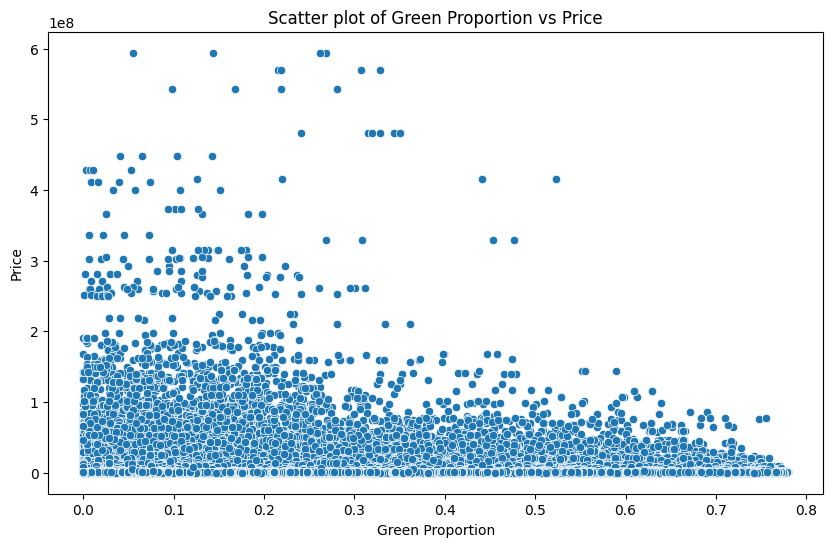

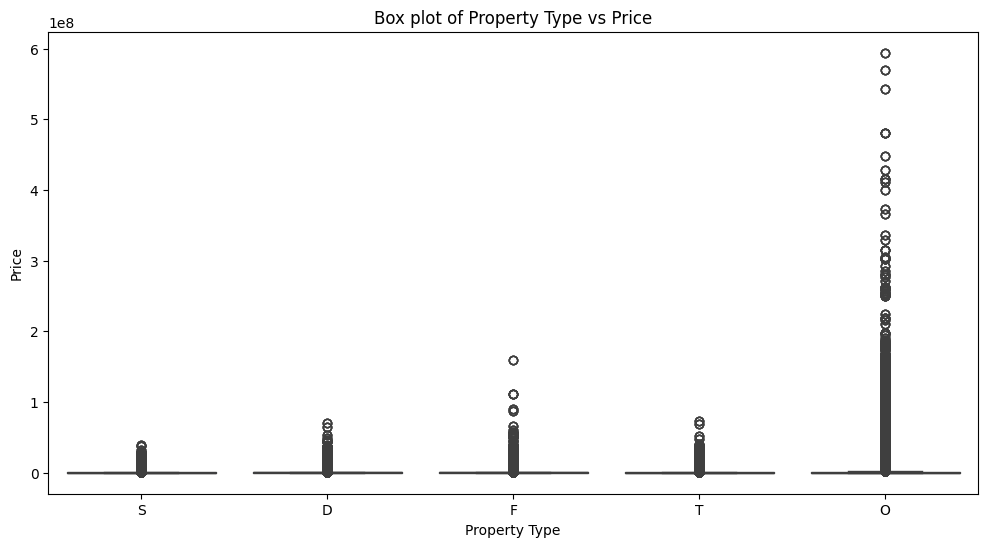

In [110]:
print(pp_combined_data[['green_proportion', 'price']].describe())

# Correlation analysis
correlation = pp_combined_data['green_proportion'].corr(pp_combined_data['price'])
print(f"Correlation between green_proportion and Price: {correlation}")

correlation = pp_combined_data['distance_to_center'].corr(pp_combined_data['price'])
print(f"Correlation between distance_to_center and price: {correlation}")

# Visualization
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='green_proportion', y='price', data=pp_combined_data)
plt.title('Scatter plot of Green Proportion vs Price')
plt.xlabel('Green Proportion')
plt.ylabel('Price')
plt.show()

# Box plot for property type vs Price
plt.figure(figsize=(12, 6))
sns.boxplot(x='property_type', y='price', data=pp_combined_data)
plt.title('Box plot of Property Type vs Price')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.show()

In [140]:
pp_combined_data['price'].describe()

count    8.613996e+06
mean     5.199534e+05
std      2.493930e+06
min      1.000000e+00
25%      1.800000e+05
50%      3.200000e+05
75%      5.100000e+05
max      5.943000e+08
Name: price, dtype: float64

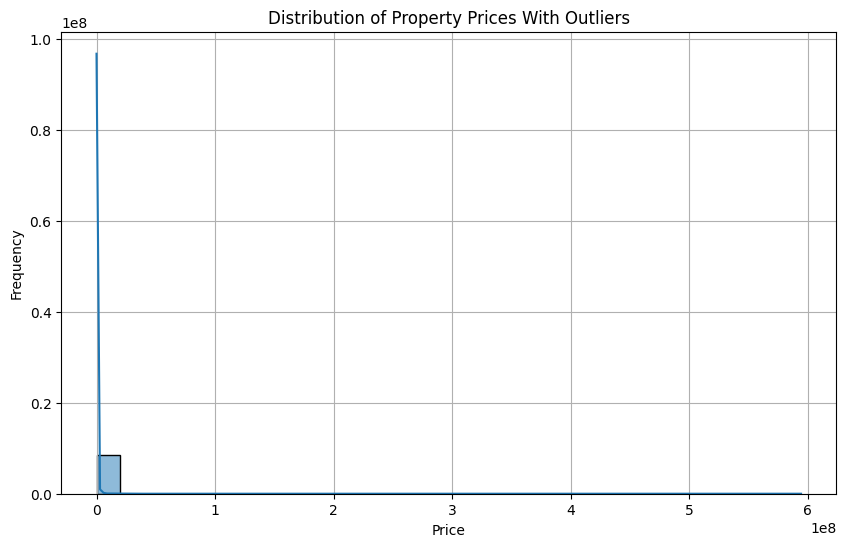

In [138]:
plt.figure(figsize=(10, 6))
sns.histplot(pp_combined_data['price'], bins=30, kde=True)
plt.title('Distribution of Property Prices With Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
# def remove_price_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1 * IQR
#     upper_bound = Q3 + 1 * IQR
#     # Filter out the outliers
#     filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
#     return filtered_df

# pp_combined_data_outlier_removed = remove_price_outliers(pp_combined_data, 'price')

def remove_price_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 0.75 * IQR
    upper_bound = Q3 + 0.75 * IQR
    # Filter out the outliers within each city's data
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

pp_combined_data_outlier_removed = pp_combined_data.groupby(['year','city']).apply(remove_price_outliers, 'price').reset_index(drop=True)


/tmp/ipykernel_26171/2618320600.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pp_combined_data_outlier_removed = pp_combined_data.groupby(['year','city']).apply(remove_price_outliers, 'price').reset_index(drop=True)


In [9]:
pp_combined_data_outlier_removed = pp_combined_data_outlier_removed[~((pp_combined_data_outlier_removed['city']=='Greater_Manchester')&(pp_combined_data_outlier_removed['year']==2015))]

In [10]:
len(pp_combined_data_outlier_removed)

7233256

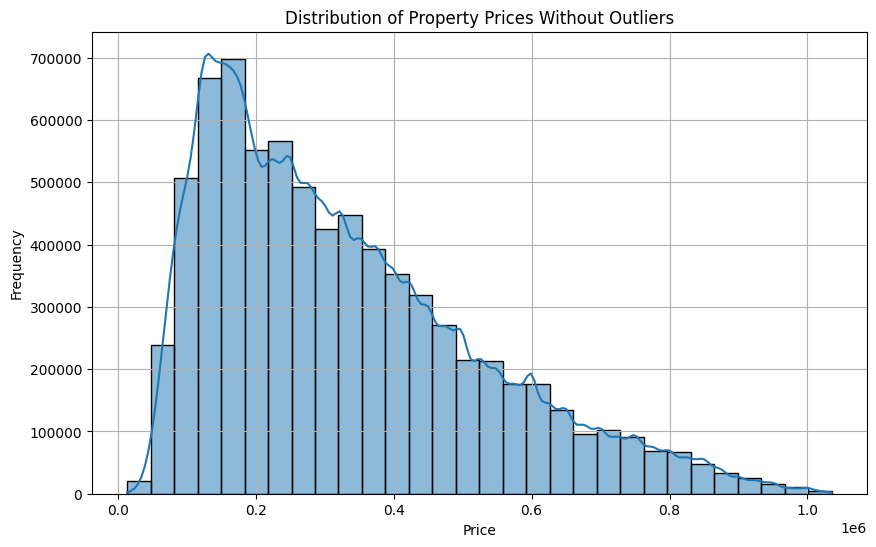

In [139]:
plt.figure(figsize=(10, 6))
sns.histplot(pp_combined_data_outlier_removed['price'], bins=30, kde=True)
plt.title('Distribution of Property Prices Without Outliers')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

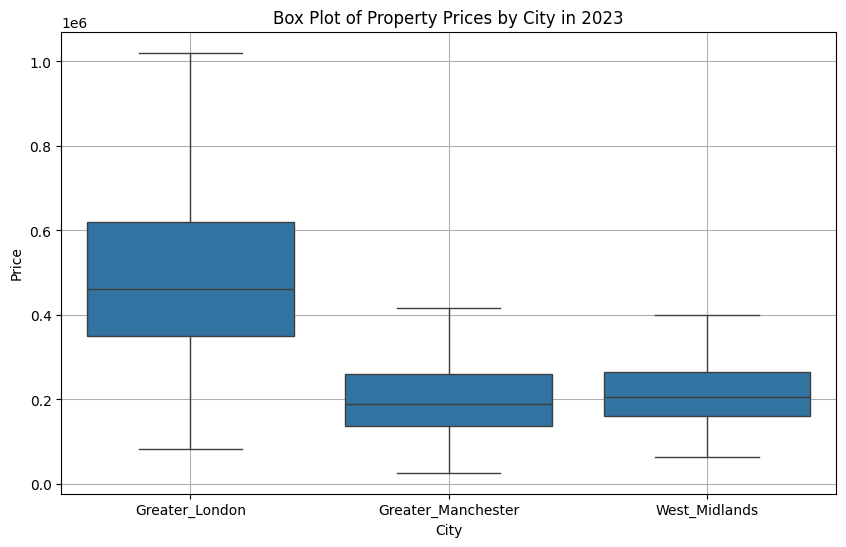

In [135]:
plt.figure(figsize=(10, 6))  # Set the figure size for the combined plot

# Create the boxplot with cities on the x-axis
sns.boxplot(x='city', y='price', data=pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['year']==2023])
plt.title('Box Plot of Property Prices by City in 2023')
plt.xlabel('City')
plt.ylabel('Price')
plt.grid(True)

plt.show()

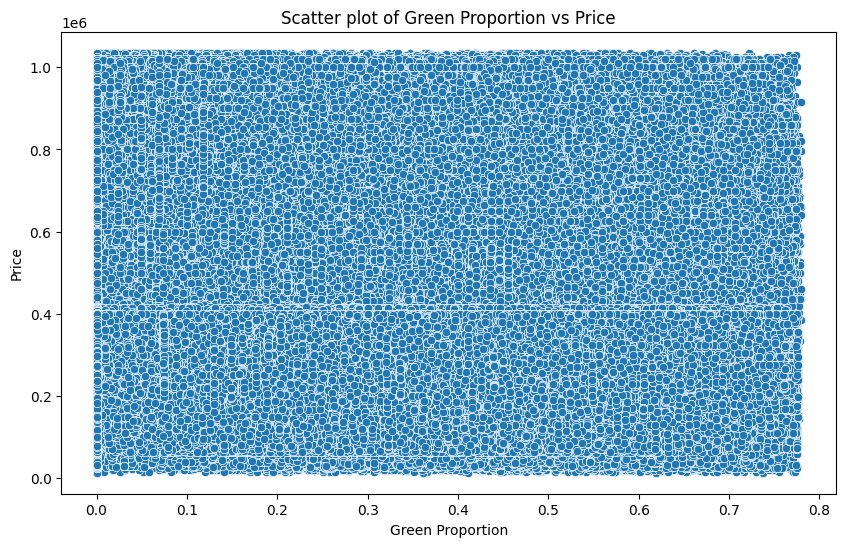

In [136]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='green_proportion', y='price', data=pp_combined_data_outlier_removed)
plt.title('Scatter plot of Green Proportion vs Price')
plt.xlabel('Green Proportion')
plt.ylabel('Price')
plt.show()

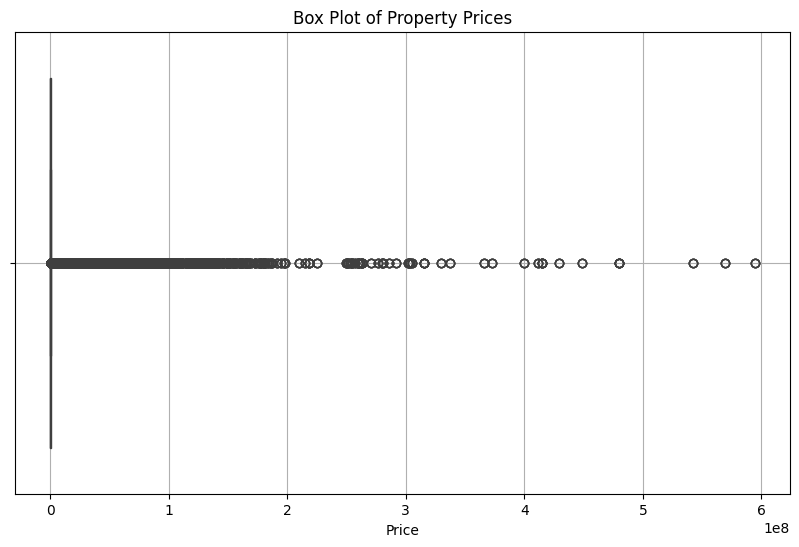

In [117]:
sns.set()
sns.set_theme()
sns.reset_defaults()
plt.rcdefaults() 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')

plt.figure(figsize=(10, 6))
sns.boxplot(x=pp_combined_data['price'])
plt.title('Box Plot of Property Prices')
plt.xlabel('Price')
plt.grid(True)
plt.show()

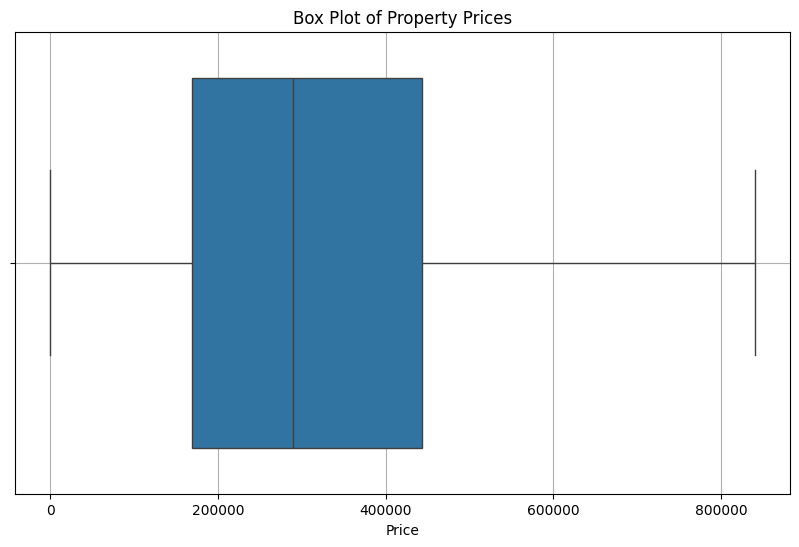

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=pp_combined_data_outlier_removed['price'])
plt.title('Box Plot of Property Prices')
plt.xlabel('Price')
plt.grid(True)
plt.show()

In [160]:
wcss = []
for i in range(120, 150, 10):  # Test different numbers of clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(coords)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS
    print(i)
    print(kmeans.inertia_)

# Correct the x-axis range to match the number of points in wcss
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o')  # range(1, 11) corresponds to the number of clusters from 1 to 10
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

110
1532.6210496636204
120
1393.2529227850446


KeyboardInterrupt: 

Elbow is at cluster count: 130


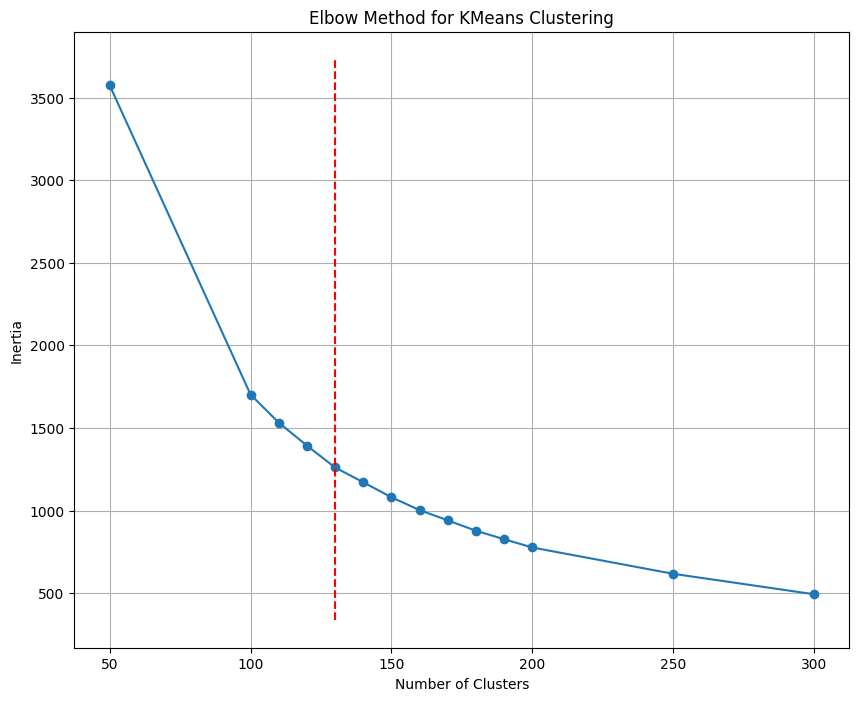

In [168]:
from kneed import  KneeLocator
import matplotlib.pyplot as plt

cluster_counts = [50, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 250, 300]
inertia_values = [3575.047321009839, 1702.1998021881602, 1532.6210496636204, 1393.2529227850446, 1260.811850715113, 1171.4029216668825, 1080.429760019319, 1002.9860650671021, 940.524960719432, 877.829779500354, 826.5467232872696, 776.5547217811633, 617.2552499226263, 493.4311007472501]

# Initialize KneeLocator to find the elbow
kn = KneeLocator(cluster_counts, inertia_values, curve='convex', direction='decreasing')

print("Elbow is at cluster count:", kn.knee)

plt.figure(figsize=(10, 8))
plt.plot(cluster_counts, inertia_values, marker='o')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',color='red')
plt.title('Elbow Method for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [33]:
tmpdf_for_kmeans = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == 482].copy()
coords = tmpdf_for_kmeans[['latitude', 'longitude']].dropna()
kmeans = KMeans(n_clusters=130, random_state=0).fit(coords)
tmpdf_for_kmeans['postcode_group'] = kmeans.labels_

In [34]:
tmpdf_for_kmeans.groupby("postcode_group").size().describe()

count      130.000000
mean     13910.107692
std       5708.042514
min       2939.000000
25%      10012.000000
50%      13532.000000
75%      16994.500000
max      31872.000000
dtype: float64

In [41]:
pp_combined_data_outlier_removed['postcode'].nunique()

245181

In [46]:
print(tmpdf_for_kmeans[['postcode','postcode_group']].duplicated().sum())

1563133


In [48]:
len(tmpdf_for_kmeans[['postcode', 'postcode_group']].drop_duplicates())

245181

In [35]:
len(pp_combined_data_outlier_removed)

7233256

In [49]:
tmp = pd.merge(pp_combined_data_outlier_removed, tmpdf_for_kmeans[['postcode', 'postcode_group']].drop_duplicates(), on="postcode", how="left")

In [52]:
tmp

postcode   latitude  longitude  green_proportion            city  \
0        WD7 9EX  51.693553  -0.292090           0.00000  Greater_London   
1        WD7 9EY  51.694201  -0.291487           0.00000  Greater_London   
2        WD7 9EY  51.694201  -0.291487           0.00000  Greater_London   
3        WD7 9EY  51.694201  -0.291487           0.00000  Greater_London   
4        WD7 9EZ  51.692141  -0.292071           0.00000  Greater_London   
...          ...        ...        ...               ...             ...   
7233251  WV5 8BF  52.533638  -2.200900           0.00000   West_Midlands   
7233252  WV5 8BF  52.533638  -2.200900           0.00000   West_Midlands   
7233253  WV8 2BH  52.620459  -2.192052           0.15782   West_Midlands   
7233254  WV8 2BH  52.620459  -2.192052           0.15782   West_Midlands   
7233255  WV8 2BH  52.620459  -2.192052           0.15782   West_Midlands   

         year  buffer_radius           transaction_unique_identifier  \
0        2015            482  {ED18A55C-B758-4FFC-8F82-2BB981052601}   
1        2015            482  {5A4BC678-FDE6-4D19-BF9F-630FAEC88447}   
2        2015            482  {54BD9C1C-77FC-4704-9004-848F21ADCB10}   
3        2015            482  {CA3419B6-A692-44BD-9533-1AB07FE9D0CF}   
4        2015            482  {288DCE29-2726-E510-E050-A8C06205480E}   
...       ...            ...                                     ...   
7233251  2023           2816  {1061746E-5E63-3C34-E063-4804A8C0F9E7}   
7233252  2023           2816  {FFA361DB-2128-8A03-E053-4804A8C01F61}   
7233253  2023           2816  {09266DDC-08FD-AF90-E063-4704A8C02087}   
7233254  2023           2816  {09266DDC-08FE-AF90-E063-4704A8C02087}   
7233255  2023           2816  {09266DDC-090C-AF90-E063-4704A8C02087}   

            price  date_of_transfer  ...         street   locality  \
0        540000.0  2015-03-16 00:00  ...    WICKETS END    SHENLEY   
1        380000.0  2015-07-31 00:00  ...   FIELDERS WAY    SHENLEY   
2        465000.0  2015-03-16 00:00  ...   FIELDERS WAY    SHENLEY   
3        410000.0  2015-08-14 00:00  ...   FIELDERS WAY    SHENLEY   
4        779950.0  2015-12-03 00:00  ...      THE LAWNS    SHENLEY   
...           ...               ...  ...            ...        ...   
7233251  372500.0  2023-09-15 00:00  ...  WOOTTON DRIVE  WOMBOURNE   
7233252  150000.0  2023-01-31 00:00  ...  WOOTTON DRIVE  WOMBOURNE   
7233253  252000.0  2023-01-31 00:00  ...   POACHERS WAY    CODSALL   
7233254  252500.0  2023-01-31 00:00  ...   POACHERS WAY    CODSALL   
7233255  253500.0  2023-01-31 00:00  ...   POACHERS WAY    CODSALL   

             town_city             district         county ppd_category_type  \
0              RADLETT            HERTSMERE  HERTFORDSHIRE                 A   
1              RADLETT            HERTSMERE  HERTFORDSHIRE                 A   
2              RADLETT            HERTSMERE  HERTFORDSHIRE                 A   
3              RADLETT            HERTSMERE  HERTFORDSHIRE                 A   
4              RADLETT            HERTSMERE  HERTFORDSHIRE                 A   
...                ...                  ...            ...               ...   
7233251  WOLVERHAMPTON  SOUTH STAFFORDSHIRE  STAFFORDSHIRE                 A   
7233252  WOLVERHAMPTON  SOUTH STAFFORDSHIRE  STAFFORDSHIRE                 A   
7233253  WOLVERHAMPTON  SOUTH STAFFORDSHIRE  STAFFORDSHIRE                 A   
7233254  WOLVERHAMPTON  SOUTH STAFFORDSHIRE  STAFFORDSHIRE                 A   
7233255  WOLVERHAMPTON  SOUTH STAFFORDSHIRE  STAFFORDSHIRE                 A   

        record_status temperature distance_to_center postcode_group  
0                   A    540000.0                NaN             68  
1                   A    380000.0                NaN             68  
2                   A    465000.0                NaN             68  
3                   A    410000.0                NaN             68  
4                   A    779950.0                NaN             68  
...     

In [97]:
postcode_group_df = tmp[['longitude','latitude','city','postcode_group','postcode']].drop_duplicates()
len(postcode_group_df)

245181

In [98]:
postcode_group_df = pd.merge(postcode_group_df,final_postcodes['postcode'],on='postcode',how='inner')
len(postcode_group_df)

204160

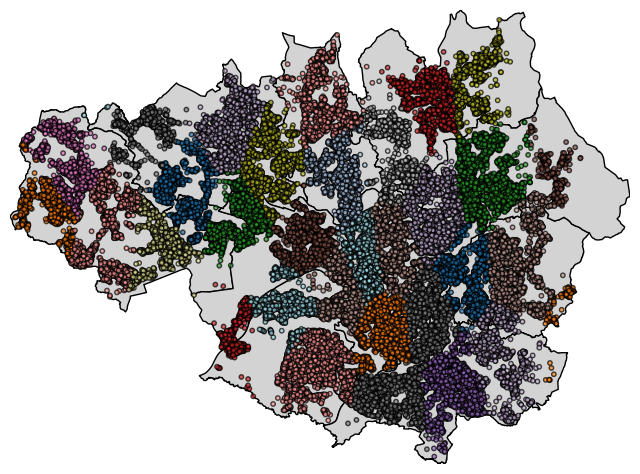

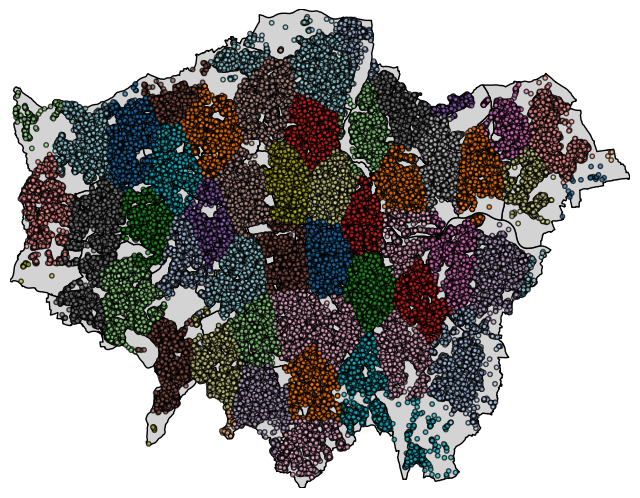

In [109]:
gdf = gpd.GeoDataFrame(
    postcode_group_df, 
    geometry=gpd.points_from_xy(postcode_group_df.longitude, postcode_group_df.latitude),
    crs="EPSG:4326"
).to_crs(epsg=27700)

for region, boundary in boundaries.items():
    if region == "West_Midlands": 
        continue
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the boundaries
    boundary.plot(ax=ax, color='lightgrey', edgecolor='black')
    
    # Filter the GeoDataFrame for the current region
    region_gdf = gdf[gdf['city'] == region]
    
    # Plot postcode groups with a color map, overlaying on the boundary
    region_gdf.plot(column='postcode_group', ax=ax, cmap='tab20', markersize=10, alpha=0.7, edgecolor='k')
    
    # ax.set_title(region.replace('_', ' '))
    
    # Remove the axis
    ax.axis('off')
    
    # Set the x and y limits to the boundary extents
    ax.set_xlim(boundary.total_bounds[[0, 2]])
    ax.set_ylim(boundary.total_bounds[[1, 3]])
    
    # Save each plot separately if needed
    plt.savefig(f"{region}_postcode_distribution.png", dpi=300, bbox_inches='tight')
    
    plt.show()

In [51]:
tmp.to_csv("pp_combined_data_outlier_removed.csv")

In [4]:
pp_combined_data_outlier_removed = pd.read_csv("pp_combined_data_outlier_removed.csv")

## Simple multiple linear regression

### WITHOUT OUTLIERS

In [123]:
# with removal of outliers
for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()

    # Convert 'city' to categorical and then to dummy variables
    df_subset.loc[:, 'city'] = df_subset['city'].astype('category')
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration', 'city'], drop_first=True)

    # Define independent variables and add a constant
    independent_vars = ['green_proportion', 'distance_to_center', 'year']
    independent_vars.extend(df_subset.columns[df_subset.columns.str.startswith(('property_type_', 'old_new_', 'duration_', 'city_'))])

    X = df_subset[independent_vars]

    # Convert all boolean columns to int64
    bool_columns = X.select_dtypes(include=['bool']).columns
    X[bool_columns] = X[bool_columns].astype(int)
    
    # Convert all data in X to numeric, coercing errors to NaN
    X = X.apply(pd.to_numeric, errors='coerce')
    
    # Add a constant
    X = sm.add_constant(X)
    
    # Drop rows with NaN values in X
    X.dropna(inplace=True)
    
    # Define dependent variable, ensuring y corresponds to X's indices
    y = df_subset['price'].loc[X.index]
    
    # Convert y to numeric
    y = pd.to_numeric(y, errors='coerce')
    
    # Drop NaN values from y (after conversion to numeric)
    y.dropna(inplace=True)
    
    # Ensure X and y have the same indices after dropping NaNs
    X = X.loc[y.index]
    
    # Fit the regression model
    try:
        model = sm.OLS(y, X).fit()
        # Summary of the regression model
        print(model.summary())
    except Exception as e:
        print(f"Error in fitting model for radius {radius}: {e}")
        continue

/tmp/ipykernel_12881/3869246846.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                 1.885e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:25:49   Log-Likelihood:            -1.9778e+07
No. Observations:             1499478   AIC:                         3.956e+07
Df Residuals:                 1499466   BIC:                         3.956e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/3869246846.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                 1.886e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:25:51   Log-Likelihood:            -1.9777e+07
No. Observations:             1499478   AIC:                         3.955e+07
Df Residuals:                 1499466   BIC:                         3.955e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/3869246846.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                 1.889e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:25:53   Log-Likelihood:            -1.9777e+07
No. Observations:             1499478   AIC:                         3.955e+07
Df Residuals:                 1499466   BIC:                         3.955e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/3869246846.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                 1.894e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:25:56   Log-Likelihood:            -1.9776e+07
No. Observations:             1499478   AIC:                         3.955e+07
Df Residuals:                 1499466   BIC:                         3.955e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

In [119]:
# with removal of outliers + gradual increase in control variables
for radius in buffer_radii:
    print(f"=========================Fitting radius {radius}=======================")
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()

    # Convert 'city' to categorical and then to dummy variables
    df_subset.loc[:, 'city'] = df_subset['city'].astype('category')
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration', 'city'], drop_first=True)
    independent_vars = ['green_proportion', 'year']
    independent_vars.extend(df_subset.columns[df_subset.columns.str.startswith(('city_'))])
    independent_vars_to_extend = ['dummy','distance_to_center','property_type_', 'old_new_', 'duration_']
    
    for var in independent_vars_to_extend:
        independent_vars.extend(df_subset.columns[df_subset.columns.str.startswith((var))])
        X = df_subset[independent_vars]
    
        # Convert all boolean columns to int64
        bool_columns = X.select_dtypes(include=['bool']).columns
        X[bool_columns] = X[bool_columns].astype(int)
        
        # Convert all data in X to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        
        # Add a constant
        X = sm.add_constant(X)
        
        # Drop rows with NaN values in X
        X.dropna(inplace=True)
        
        # Define dependent variable, ensuring y corresponds to X's indices
        y = df_subset['price'].loc[X.index]
        
        # Convert y to numeric
        y = pd.to_numeric(y, errors='coerce')
        
        # Drop NaN values from y (after conversion to numeric)
        y.dropna(inplace=True)
        
        # Ensure X and y have the same indices after dropping NaNs
        X = X.loc[y.index]
        
        # Fit the regression model
        try:
            model = sm.OLS(y, X).fit()
            # Summary of the regression model
            print(model.summary())
        except Exception as e:
            print(f"Error in fitting model for radius {radius}: {e}")
            continue

=========================Fitting radius 482=======================


/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                 4.203e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:32   Log-Likelihood:            -2.4015e+07
No. Observations:             1808314   AIC:                         4.803e+07
Df Residuals:                 1808309   BIC:                         4.803e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                 3.124e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:32   Log-Likelihood:            -1.9894e+07
No. Observations:             1499478   AIC:                         3.979e+07
Df Residuals:                 1499472   BIC:                         3.979e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 2.232e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:33   Log-Likelihood:            -1.9791e+07
No. Observations:             1499478   AIC:                         3.958e+07
Df Residuals:                 1499468   BIC:                         3.958e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                 2.059e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:33   Log-Likelihood:            -1.9781e+07
No. Observations:             1499478   AIC:                         3.956e+07
Df Residuals:                 1499467   BIC:                         3.956e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                 1.885e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:34   Log-Likelihood:            -1.9778e+07
No. Observations:             1499478   AIC:                         3.956e+07
Df Residuals:                 1499466   BIC:                         3.956e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                 4.203e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:36   Log-Likelihood:            -2.4015e+07
No. Observations:             1808314   AIC:                         4.803e+07
Df Residuals:                 1808309   BIC:                         4.803e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                 3.121e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:36   Log-Likelihood:            -1.9894e+07
No. Observations:             1499478   AIC:                         3.979e+07
Df Residuals:                 1499472   BIC:                         3.979e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 2.232e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:37   Log-Likelihood:            -1.9791e+07
No. Observations:             1499478   AIC:                         3.958e+07
Df Residuals:                 1499468   BIC:                         3.958e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                 2.060e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:38   Log-Likelihood:            -1.9780e+07
No. Observations:             1499478   AIC:                         3.956e+07
Df Residuals:                 1499467   BIC:                         3.956e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                 1.886e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:39   Log-Likelihood:            -1.9777e+07
No. Observations:             1499478   AIC:                         3.955e+07
Df Residuals:                 1499466   BIC:                         3.955e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                 4.202e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:41   Log-Likelihood:            -2.4015e+07
No. Observations:             1808314   AIC:                         4.803e+07
Df Residuals:                 1808309   BIC:                         4.803e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                 3.115e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:41   Log-Likelihood:            -1.9895e+07
No. Observations:             1499478   AIC:                         3.979e+07
Df Residuals:                 1499472   BIC:                         3.979e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                 2.236e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:42   Log-Likelihood:            -1.9791e+07
No. Observations:             1499478   AIC:                         3.958e+07
Df Residuals:                 1499468   BIC:                         3.958e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                 2.064e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:42   Log-Likelihood:            -1.9780e+07
No. Observations:             1499478   AIC:                         3.956e+07
Df Residuals:                 1499467   BIC:                         3.956e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                 1.889e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:43   Log-Likelihood:            -1.9777e+07
No. Observations:             1499478   AIC:                         3.955e+07
Df Residuals:                 1499466   BIC:                         3.955e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                 4.202e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:45   Log-Likelihood:            -2.4015e+07
No. Observations:             1808314   AIC:                         4.803e+07
Df Residuals:                 1808309   BIC:                         4.803e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                 3.114e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:45   Log-Likelihood:            -1.9895e+07
No. Observations:             1499478   AIC:                         3.979e+07
Df Residuals:                 1499472   BIC:                         3.979e+07
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                 2.243e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:46   Log-Likelihood:            -1.9789e+07
No. Observations:             1499478   AIC:                         3.958e+07
Df Residuals:                 1499468   BIC:                         3.958e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                 2.070e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:47   Log-Likelihood:            -1.9779e+07
No. Observations:             1499478   AIC:                         3.956e+07
Df Residuals:                 1499467   BIC:                         3.956e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

/tmp/ipykernel_12881/2694682174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                 1.894e+05
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:15:48   Log-Likelihood:            -1.9776e+07
No. Observations:             1499478   AIC:                         3.955e+07
Df Residuals:                 1499466   BIC:                         3.955e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2

## Final Multiple Regression Model

In [58]:
# with removal of outliers + gradual increase in control variables + postcode_group

def custom_summary(model, exclude_prefix='postcode_group'):
    # Gather all model parameters into a DataFrame
    results_df = pd.DataFrame({'Coefficient': model.params, 'P-value': model.pvalues})
    
    # Filter out variables to exclude based on prefix
    filtered_results = results_df[~results_df.index.str.startswith(exclude_prefix)]
    
    # Add other relevant stats if necessary, e.g., R-squared, number of observations
    additional_stats = {
        'R-squared': model.rsquared,
        'Adj. R-squared': model.rsquared_adj,
        'No. observations': model.nobs
    }
    
    significant_postcode_groups = results_df[results_df.index.str.startswith(exclude_prefix) & (results_df['P-value'] < 0.05)]
    num_significant = significant_postcode_groups.shape[0]

    # Print the filtered results and additional stats
    print(filtered_results)
    print("\nAdditional Stats:")
    for stat, value in additional_stats.items():
        print(f"{stat}: {value:.4f}")
    
    # Print the number of significant postcode_group coefficients
    print(f"\nNumber of significant {exclude_prefix} coefficients at the 0.05 level: {num_significant}")


# Example of using the custom_summary in your regression loop
for radius in buffer_radii:
    print(f"=========================Fitting radius {radius}=======================")
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration', 'city', 'postcode_group'], drop_first=True)
    
    independent_vars = ['green_proportion', 'distance_to_center', 'year']
    independent_vars.extend(df_subset.columns[df_subset.columns.str.startswith(('city_'))])
    independent_vars_to_extend = ['postcode_group','distance_to_center','property_type_', 'old_new_', 'duration_']
    
    for var in independent_vars_to_extend:
        independent_vars.extend(df_subset.columns[df_subset.columns.str.startswith((var))])
        X = df_subset[independent_vars]
    
        # Convert all boolean columns to int64
        bool_columns = X.select_dtypes(include=['bool']).columns
        X[bool_columns] = X[bool_columns].astype(int)
        
        # Convert all data in X to numeric, coercing errors to NaN
        X = X.apply(pd.to_numeric, errors='coerce')
        
        # Add a constant
        X = sm.add_constant(X)
        
        # Drop rows with NaN values in X
        X.dropna(inplace=True)
        
        # Define dependent variable, ensuring y corresponds to X's indices
        y = df_subset['price'].loc[X.index]
        
        # Convert y to numeric
        y = pd.to_numeric(y, errors='coerce')
        
        # Drop NaN values from y (after conversion to numeric)
        y.dropna(inplace=True)
        
        # Ensure X and y have the same indices after dropping NaNs
        X = X.loc[y.index]
        
        # Fit the regression model
        try:
            model = sm.OLS(y, X).fit()
            # Summary of the regression model
            custom_summary(model, exclude_prefix='postcode_group_')  # Use custom summary function
            # print(model.summary())
        except Exception as e:
            print(f"Error in fitting model for radius {radius}: {e}")
            continue

=========================Fitting radius 482=======================


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.545033e+07      0.0
green_proportion         8.907180e+04      0.0
distance_to_center      -3.653948e+00      0.0
year                     1.304866e+04      0.0
city_Greater_Manchester -6.858730e+05      0.0
city_West_Midlands      -6.823593e+05      0.0

Additional Stats:
R-squared: 0.5658
Adj. R-squared: 0.5658
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 125


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.545033e+07      0.0
green_proportion         8.907180e+04      0.0
distance_to_center      -1.652059e+00      0.0
year                     1.304866e+04      0.0
city_Greater_Manchester -6.858730e+05      0.0
city_West_Midlands      -6.823593e+05      0.0
distance_to_center      -2.001889e+00      0.0

Additional Stats:
R-squared: 0.5658
Adj. R-squared: 0.5658
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 124


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient       P-value
const                   -2.225059e+07  0.000000e+00
green_proportion         1.409595e+04  2.273651e-73
distance_to_center      -3.324822e+00  0.000000e+00
year                     1.155924e+04  0.000000e+00
city_Greater_Manchester -6.731134e+05  0.000000e+00
city_West_Midlands      -6.763786e+05  0.000000e+00
distance_to_center      -3.618653e+00  0.000000e+00
property_type_F         -2.405727e+05  0.000000e+00
property_type_O         -1.911164e+05  0.000000e+00
property_type_S         -8.296597e+04  0.000000e+00
property_type_T         -1.289822e+05  0.000000e+00

Additional Stats:
R-squared: 0.6572
Adj. R-squared: 0.6572
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 126


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.342491e+07      0.0
green_proportion         3.163579e+04      0.0
distance_to_center      -3.265649e+00      0.0
year                     1.214280e+04      0.0
city_Greater_Manchester -6.952558e+05      0.0
city_West_Midlands      -6.972763e+05      0.0
distance_to_center      -3.600510e+00      0.0
property_type_F         -2.442546e+05      0.0
property_type_O         -1.839250e+05      0.0
property_type_S         -7.822839e+04      0.0
property_type_T         -1.221415e+05      0.0
old_new_Y                5.942450e+04      0.0

Additional Stats:
R-squared: 0.6650
Adj. R-squared: 0.6649
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 124


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.320633e+07      0.0
green_proportion         2.963076e+04      0.0
distance_to_center      -3.253253e+00      0.0
year                     1.203407e+04      0.0
city_Greater_Manchester -6.785822e+05      0.0
city_West_Midlands      -6.937147e+05      0.0
distance_to_center      -3.578180e+00      0.0
property_type_F         -2.073366e+05      0.0
property_type_O         -1.733520e+05      0.0
property_type_S         -7.757075e+04      0.0
property_type_T         -1.213397e+05      0.0
old_new_Y                5.924865e+04      0.0
duration_L              -4.124306e+04      0.0

Additional Stats:
R-squared: 0.6679
Adj. R-squared: 0.6678
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 125
=========================Fitting radius 965=======================


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.561612e+07      0.0
green_proportion         9.962378e+04      0.0
distance_to_center      -3.772779e+00      0.0
year                     1.313029e+04      0.0
city_Greater_Manchester -6.903212e+05      0.0
city_West_Midlands      -6.856109e+05      0.0

Additional Stats:
R-squared: 0.5656
Adj. R-squared: 0.5655
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 127


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.561612e+07      0.0
green_proportion         9.962378e+04      0.0
distance_to_center      -1.835871e+00      0.0
year                     1.313029e+04      0.0
city_Greater_Manchester -6.903212e+05      0.0
city_West_Midlands      -6.856109e+05      0.0
distance_to_center      -1.936908e+00      0.0

Additional Stats:
R-squared: 0.5656
Adj. R-squared: 0.5655
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 122


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient        P-value
const                   -2.260857e+07   0.000000e+00
green_proportion         2.799029e+04  1.354234e-208
distance_to_center      -3.577682e+00   0.000000e+00
year                     1.173870e+04   0.000000e+00
city_Greater_Manchester -6.800545e+05   0.000000e+00
city_West_Midlands      -6.836723e+05   0.000000e+00
distance_to_center      -3.670562e+00   0.000000e+00
property_type_F         -2.401674e+05   0.000000e+00
property_type_O         -1.907102e+05   0.000000e+00
property_type_S         -8.284934e+04   0.000000e+00
property_type_T         -1.286830e+05   0.000000e+00

Additional Stats:
R-squared: 0.6574
Adj. R-squared: 0.6574
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 124


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.368295e+07      0.0
green_proportion         4.284861e+04      0.0
distance_to_center      -3.502188e+00      0.0
year                     1.227201e+04      0.0
city_Greater_Manchester -7.006411e+05      0.0
city_West_Midlands      -7.026027e+05      0.0
distance_to_center      -3.591505e+00      0.0
property_type_F         -2.443678e+05      0.0
property_type_O         -1.843273e+05      0.0
property_type_S         -7.826982e+04      0.0
property_type_T         -1.223109e+05      0.0
old_new_Y                5.917911e+04      0.0

Additional Stats:
R-squared: 0.6651
Adj. R-squared: 0.6651
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 125


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.347019e+07      0.0
green_proportion         4.093996e+04      0.0
distance_to_center      -3.498205e+00      0.0
year                     1.216621e+04      0.0
city_Greater_Manchester -6.840381e+05      0.0
city_West_Midlands      -6.991520e+05      0.0
distance_to_center      -3.564661e+00      0.0
property_type_F         -2.073946e+05      0.0
property_type_O         -1.736721e+05      0.0
property_type_S         -7.759602e+04      0.0
property_type_T         -1.214627e+05      0.0
old_new_Y                5.904406e+04      0.0
duration_L              -4.125197e+04      0.0

Additional Stats:
R-squared: 0.6680
Adj. R-squared: 0.6680
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 124
=========================Fitting radius 1890=======================


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.547693e+07      0.0
green_proportion         9.921698e+04      0.0
distance_to_center      -3.225321e+00      0.0
year                     1.305621e+04      0.0
city_Greater_Manchester -6.898065e+05      0.0
city_West_Midlands      -6.815730e+05      0.0

Additional Stats:
R-squared: 0.5647
Adj. R-squared: 0.5646
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 122


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.547693e+07      0.0
green_proportion         9.921698e+04      0.0
distance_to_center      -1.669449e+00      0.0
year                     1.305621e+04      0.0
city_Greater_Manchester -6.898065e+05      0.0
city_West_Midlands      -6.815730e+05      0.0
distance_to_center      -1.555872e+00      0.0

Additional Stats:
R-squared: 0.5647
Adj. R-squared: 0.5646
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 122


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient        P-value
const                   -2.290516e+07   0.000000e+00
green_proportion         4.093465e+04  6.566155e-308
distance_to_center      -3.716402e+00   0.000000e+00
year                     1.188628e+04   0.000000e+00
city_Greater_Manchester -6.866177e+05   0.000000e+00
city_West_Midlands      -6.894026e+05   0.000000e+00
distance_to_center      -3.628107e+00   0.000000e+00
property_type_F         -2.404921e+05   0.000000e+00
property_type_O         -1.911753e+05   0.000000e+00
property_type_S         -8.299862e+04   0.000000e+00
property_type_T         -1.289908e+05   0.000000e+00

Additional Stats:
R-squared: 0.6575
Adj. R-squared: 0.6575
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 125


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.389925e+07      0.0
green_proportion         5.360944e+04      0.0
distance_to_center      -3.608472e+00      0.0
year                     1.237897e+04      0.0
city_Greater_Manchester -7.060173e+05      0.0
city_West_Midlands      -7.066348e+05      0.0
distance_to_center      -3.472019e+00      0.0
property_type_F         -2.450876e+05      0.0
property_type_O         -1.853684e+05      0.0
property_type_S         -7.857912e+04      0.0
property_type_T         -1.230009e+05      0.0
old_new_Y                5.883472e+04      0.0

Additional Stats:
R-squared: 0.6651
Adj. R-squared: 0.6651
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 126


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.370245e+07      0.0
green_proportion         5.222105e+04      0.0
distance_to_center      -3.612960e+00      0.0
year                     1.228121e+04      0.0
city_Greater_Manchester -6.896449e+05      0.0
city_West_Midlands      -7.035179e+05      0.0
distance_to_center      -3.455214e+00      0.0
property_type_F         -2.079581e+05      0.0
property_type_O         -1.746037e+05      0.0
property_type_S         -7.788219e+04      0.0
property_type_T         -1.220973e+05      0.0
old_new_Y                5.873341e+04      0.0
duration_L              -4.136094e+04      0.0

Additional Stats:
R-squared: 0.6681
Adj. R-squared: 0.6680
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 125
=========================Fitting radius 2816=======================


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient        P-value
const                   -2.512226e+07   0.000000e+00
green_proportion         8.819613e+04   0.000000e+00
distance_to_center      -2.568329e+00  4.713382e-256
year                     1.287518e+04   0.000000e+00
city_Greater_Manchester -6.842078e+05   0.000000e+00
city_West_Midlands      -6.731107e+05   0.000000e+00

Additional Stats:
R-squared: 0.5639
Adj. R-squared: 0.5639
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 124


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient        P-value
const                   -2.512226e+07   0.000000e+00
green_proportion         8.819613e+04   0.000000e+00
distance_to_center      -1.150138e+00  3.146528e-206
year                     1.287518e+04   0.000000e+00
city_Greater_Manchester -6.842078e+05   0.000000e+00
city_West_Midlands      -6.731107e+05   0.000000e+00
distance_to_center      -1.418191e+00   0.000000e+00

Additional Stats:
R-squared: 0.5639
Adj. R-squared: 0.5639
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 124


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient        P-value
const                   -2.289327e+07   0.000000e+00
green_proportion         4.180990e+04  1.845701e-253
distance_to_center      -3.456460e+00   0.000000e+00
year                     1.187903e+04   0.000000e+00
city_Greater_Manchester -6.871342e+05   0.000000e+00
city_West_Midlands      -6.886497e+05   0.000000e+00
distance_to_center      -3.699939e+00   0.000000e+00
property_type_F         -2.410263e+05   0.000000e+00
property_type_O         -1.918340e+05   0.000000e+00
property_type_S         -8.326652e+04   0.000000e+00
property_type_T         -1.294869e+05   0.000000e+00

Additional Stats:
R-squared: 0.6574
Adj. R-squared: 0.6574
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 125


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.383984e+07      0.0
green_proportion         5.313734e+04      0.0
distance_to_center      -3.291018e+00      0.0
year                     1.234761e+04      0.0
city_Greater_Manchester -7.058040e+05      0.0
city_West_Midlands      -7.048055e+05      0.0
distance_to_center      -3.524290e+00      0.0
property_type_F         -2.457854e+05      0.0
property_type_O         -1.862849e+05      0.0
property_type_S         -7.895125e+04      0.0
property_type_T         -1.236929e+05      0.0
old_new_Y                5.853712e+04      0.0

Additional Stats:
R-squared: 0.6650
Adj. R-squared: 0.6650
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 123


/tmp/ipykernel_24632/1148071406.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


                          Coefficient  P-value
const                   -2.366994e+07      0.0
green_proportion         5.279368e+04      0.0
distance_to_center      -3.292413e+00      0.0
year                     1.226333e+04      0.0
city_Greater_Manchester -6.899062e+05      0.0
city_West_Midlands      -7.022329e+05      0.0
distance_to_center      -3.530982e+00      0.0
property_type_F         -2.084824e+05      0.0
property_type_O         -1.754370e+05      0.0
property_type_S         -7.824142e+04      0.0
property_type_T         -1.227580e+05      0.0
old_new_Y                5.845682e+04      0.0
duration_L              -4.151874e+04      0.0

Additional Stats:
R-squared: 0.6680
Adj. R-squared: 0.6679
No. observations: 1499478.0000

Number of significant postcode_group_ coefficients at the 0.05 level: 125


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset.loc[:, 'city'] = df_subset['city'].astype('category')
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration', 'city', 'postcode_gruop'], drop_first=True)
    independent_vars = ['green_proportion', 'distance_to_center', 'year']
    independent_vars.extend(df_subset.columns[df_subset.columns.str.startswith(('property_type_', 'old_new_', 'duration_', 'city_'))])

    X = df_subset[independent_vars]
    bool_columns = X.select_dtypes(include=['bool']).columns
    X[bool_columns] = X[bool_columns].astype(int)    
    X = X.apply(pd.to_numeric, errors='coerce')
    X = sm.add_constant(X)
    X.dropna(inplace=True)

    plt.figure(figsize=(12, 10))
    sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.show()

NameError: name 'buffer_radii' is not defined

In [117]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                    feature            VIF
0                     const  709118.191648
1          green_proportion       1.593381
2        distance_to_center       1.367391
3                      year       1.081554
4           property_type_F       7.981403
5           property_type_O       1.494432
6           property_type_S       3.715966
7           property_type_T       4.344289
8                 old_new_Y       1.105641
9                duration_L       3.362331
10  city_Greater_Manchester       1.527096
11       city_West_Midlands       1.248400


In [122]:
pp_combined_data_outlier_removed.groupby(["postcode", "year"]).size().describe()

count    964204.000000
mean          7.501790
std          11.323678
min           4.000000
25%           4.000000
50%           4.000000
75%           8.000000
max        1292.000000
dtype: float64

In [128]:
pp_combined_data_outlier_removed.groupby(['postcode', 'year','buffer_radius'])['green_proportion'].std().describe()

count    1558460.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: green_proportion, dtype: float64

### WITH outliers

In [137]:
# without removal of outliers
for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = pp_combined_data[pp_combined_data['buffer_radius'] == radius]

    # Convert 'city' and 'year' to categorical data types if needed
    df_subset['city'] = df_subset['city'].astype('category')
    
    # Create dummy variables for categorical features
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration', 'city'], drop_first=True)
    
    # Ensure that 'price' is numeric
    df_subset['price'] = pd.to_numeric(df_subset['price'], errors='coerce')
    
    # Drop rows with NaN values in the dependent variable or any independent variables
    df_subset.dropna(subset=['price', 'green_proportion'], inplace=True)
    
    # Define independent variables
    independent_vars = ['green_proportion', 'year', 'distance_to_center']
    
    # Include the dummy variables created by get_dummies
    independent_vars += [col for col in df_subset.columns if col.startswith(('property_type_', 'old_new_', 'duration_', 'city_'))]
    
    # Define independent variables and add a constant
    X = df_subset[independent_vars]
    X = sm.add_constant(X)
    
    # Convert all X data to float to avoid dtype issues with bool types
    X = X.astype('float64')
    
    # Define dependent variable
    y = df_subset['price'].astype('float64')
    
    # Drop rows with NaN values in independent variables
    X.dropna(inplace=True)
    y = y[X.index]  # Keep y aligned with X
    
    # Fit the regression model
    try:
        model = sm.OLS(y, X).fit()
        # Summary of the regression model
        print(f"Buffer Radius: {radius}")
        print(model.summary())
    except Exception as e:
        print(f"An error occurred for buffer radius {radius}: {e}")

/tmp/ipykernel_7213/678375255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')


Buffer Radius: 482
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     506.0
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:35:42   Log-Likelihood:            -5.4829e+06
No. Observations:              346445   AIC:                         1.097e+07
Df Residuals:                  346435   BIC:                         1.097e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const  

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/tmp/ipykernel_7213/678375255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')


Buffer Radius: 965
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     505.8
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:35:45   Log-Likelihood:            -5.4829e+06
No. Observations:              346445   AIC:                         1.097e+07
Df Residuals:                  346435   BIC:                         1.097e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const  

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/tmp/ipykernel_7213/678375255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')


Buffer Radius: 1890
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     506.3
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:35:48   Log-Likelihood:            -5.4829e+06
No. Observations:              346445   AIC:                         1.097e+07
Df Residuals:                  346435   BIC:                         1.097e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/tmp/ipykernel_7213/678375255.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')


Buffer Radius: 2816
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     507.7
Date:                Sun, 04 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:35:50   Log-Likelihood:            -5.4829e+06
No. Observations:              346445   AIC:                         1.097e+07
Df Residuals:                  346435   BIC:                         1.097e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


## Fixed Effect regrssion

### WITH OUTLIERS

/tmp/ipykernel_24092/1946239379.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_24092/1946239379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weigh

Results for buffer radius: 482
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.0126
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:              346445   R-squared (Within):               0.0127
Date:                Tue, Aug 13 2024   R-squared (Overall):              0.0127
Time:                        21:01:54   Log-likelihood                -5.483e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      553.78
Entities:                           1   P-value                           0.0000
Avg Obs:                    3.464e+05   Distribution:                F(8,346428)
Min Obs:                    3.464e+05                                           
Max Obs:                    3.464e+05   F-statistic (robust):          1.591e+

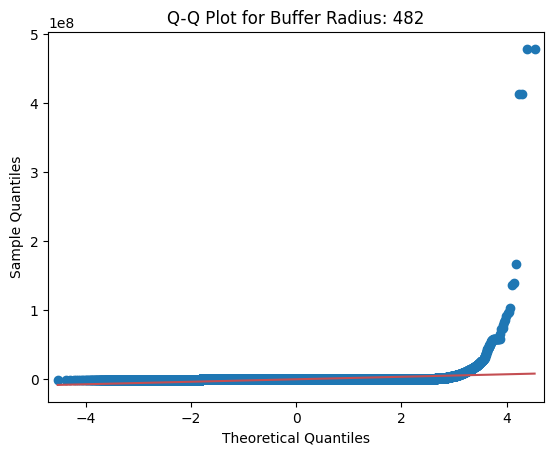

Normality test p-value: 0.0


/tmp/ipykernel_24092/1946239379.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_24092/1946239379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weigh

Results for buffer radius: 965
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.0126
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:              346445   R-squared (Within):               0.0127
Date:                Tue, Aug 13 2024   R-squared (Overall):              0.0127
Time:                        21:01:59   Log-likelihood                -5.483e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      553.42
Entities:                           1   P-value                           0.0000
Avg Obs:                    3.464e+05   Distribution:                F(8,346428)
Min Obs:                    3.464e+05                                           
Max Obs:                    3.464e+05   F-statistic (robust):          2.631e+

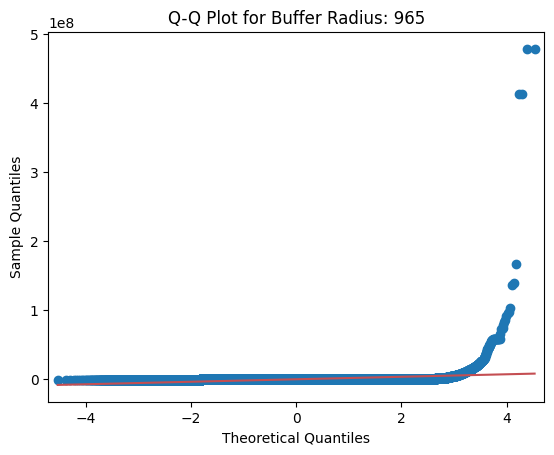

Normality test p-value: 0.0


/tmp/ipykernel_24092/1946239379.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_24092/1946239379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weigh

Results for buffer radius: 1890
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.0126
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:              346445   R-squared (Within):               0.0127
Date:                Tue, Aug 13 2024   R-squared (Overall):              0.0127
Time:                        21:02:03   Log-likelihood                -5.483e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      553.91
Entities:                           1   P-value                           0.0000
Avg Obs:                    3.464e+05   Distribution:                F(8,346428)
Min Obs:                    3.464e+05                                           
Max Obs:                    3.464e+05   F-statistic (robust):         -2.723e

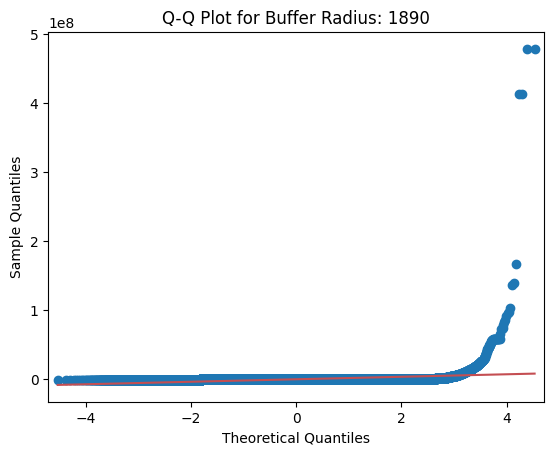

Normality test p-value: 0.0


/tmp/ipykernel_24092/1946239379.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['city'] = df_subset['city'].astype('category')
/tmp/ipykernel_24092/1946239379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weigh

Results for buffer radius: 2816
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.0127
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:              346445   R-squared (Within):               0.0127
Date:                Tue, Aug 13 2024   R-squared (Overall):              0.0127
Time:                        21:02:08   Log-likelihood                -5.483e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      555.47
Entities:                           1   P-value                           0.0000
Avg Obs:                    3.464e+05   Distribution:                F(8,346428)
Min Obs:                    3.464e+05                                           
Max Obs:                    3.464e+05   F-statistic (robust):         -1.743e

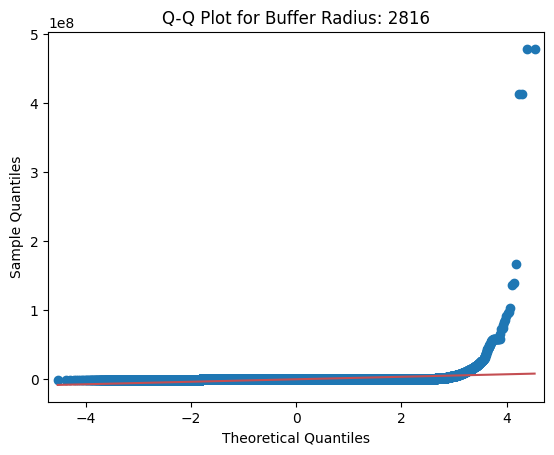

Normality test p-value: 0.0


In [143]:
for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = pp_combined_data[pp_combined_data['buffer_radius'] == radius]

    # Convert 'city' and 'year' to appropriate types
    df_subset['city'] = df_subset['city'].astype('category')
    df_subset['year'] = df_subset['year'].astype(int)

    # Set multi-index for PanelOLS using original columns
    df_subset = df_subset.set_index(['city', 'year'])

    # Convert 'property_type', 'old_new', and 'duration' to dummy variables
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration'], drop_first=True)
    
    # Dependent variable
    endog = df_subset['price']

    # Independent variables (including fixed effects dummies)
    exog_vars = ['green_proportion', 'distance_to_center']
    exog_vars += [col for col in df_subset.columns if col.startswith(('property_type_', 'old_new_', 'duration_'))]

    # Add constant to exogenous variables
    exog = sm.add_constant(df_subset[exog_vars])

    # PanelOLS with entity and time effects
    model = PanelOLS(endog, exog, entity_effects=True, time_effects=True, drop_absorbed=True)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    # Print summary of the model
    print(f"Results for buffer radius: {radius}")
    print(result.summary)

    # Diagnostics: Checking for normality of residuals
    sm.qqplot(result.resids, line='s')
    plt.title(f"Q-Q Plot for Buffer Radius: {radius}")
    plt.show()

    # Checking for heteroscedasticity using normality test
    _, p_value = normaltest(result.resids)
    print(f"Normality test p-value: {p_value}")

/tmp/ipykernel_7213/3777906721.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['postcode'] = df_subset['postcode'].astype('category')
/tmp/ipykernel_7213/3777906721.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights

Results for buffer radius: 482
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):              0.0063
No. Observations:              346445   R-squared (Within):               0.0017
Date:                Sun, Aug 04 2024   R-squared (Overall):              0.0059
Time:                        22:11:14   Log-likelihood                -5.321e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      65.707
Entities:                       45386   P-value                           0.0000
Avg Obs:                       7.6333   Distribution:                F(8,301043)
Min Obs:                       1.0000                                           
Max Obs:                       146.00   F-statistic (robust):         -1.132e+

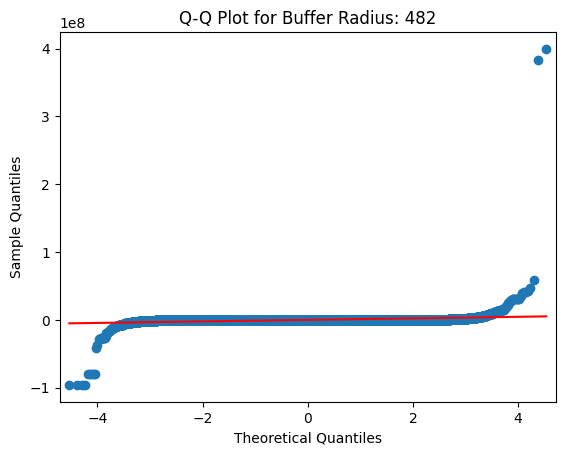

Normality test p-value: 0.0


/tmp/ipykernel_7213/3777906721.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['postcode'] = df_subset['postcode'].astype('category')
/tmp/ipykernel_7213/3777906721.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights

Results for buffer radius: 965
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):              0.0068
No. Observations:              346445   R-squared (Within):               0.0018
Date:                Sun, Aug 04 2024   R-squared (Overall):              0.0062
Time:                        22:11:19   Log-likelihood                -5.321e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      65.516
Entities:                       45386   P-value                           0.0000
Avg Obs:                       7.6333   Distribution:                F(8,301043)
Min Obs:                       1.0000                                           
Max Obs:                       146.00   F-statistic (robust):          -1.38e+

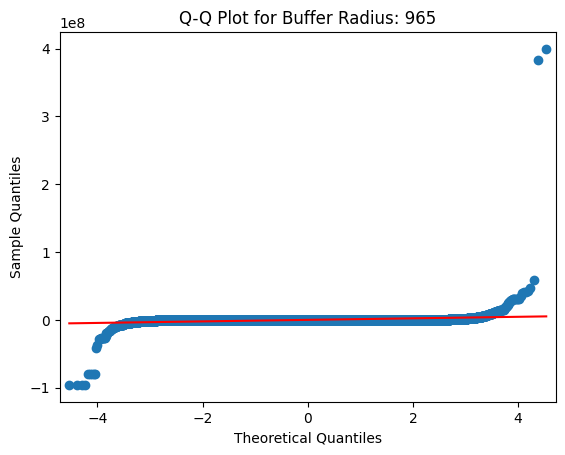

Normality test p-value: 0.0


/tmp/ipykernel_7213/3777906721.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['postcode'] = df_subset['postcode'].astype('category')
/tmp/ipykernel_7213/3777906721.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights

Results for buffer radius: 1890
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):              0.0069
No. Observations:              346445   R-squared (Within):               0.0018
Date:                Sun, Aug 04 2024   R-squared (Overall):              0.0062
Time:                        22:11:24   Log-likelihood                -5.321e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      65.579
Entities:                       45386   P-value                           0.0000
Avg Obs:                       7.6333   Distribution:                F(8,301043)
Min Obs:                       1.0000                                           
Max Obs:                       146.00   F-statistic (robust):          -4.13e

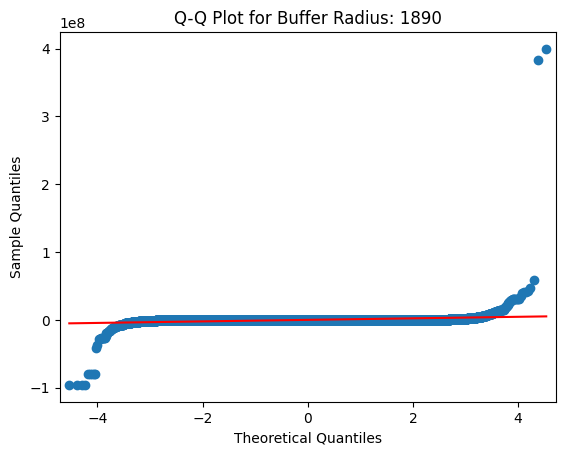

Normality test p-value: 0.0


/tmp/ipykernel_7213/3777906721.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['postcode'] = df_subset['postcode'].astype('category')
/tmp/ipykernel_7213/3777906721.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['year'] = df_subset['year'].astype(int)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights

Results for buffer radius: 2816
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.0017
Estimator:                   PanelOLS   R-squared (Between):              0.0067
No. Observations:              346445   R-squared (Within):               0.0018
Date:                Sun, Aug 04 2024   R-squared (Overall):              0.0061
Time:                        22:11:29   Log-likelihood                -5.321e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      65.512
Entities:                       45386   P-value                           0.0000
Avg Obs:                       7.6333   Distribution:                F(8,301043)
Min Obs:                       1.0000                                           
Max Obs:                       146.00   F-statistic (robust):         -2.889e

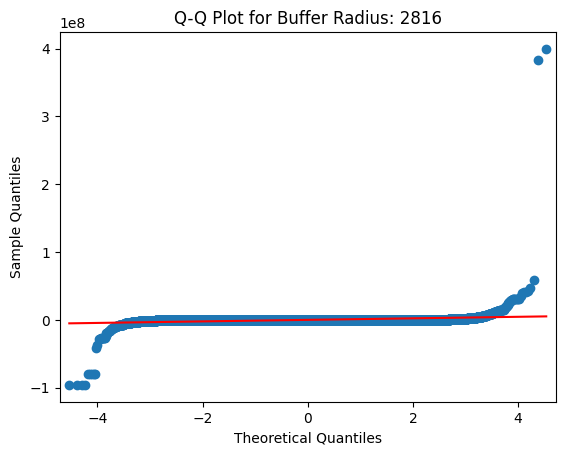

Normality test p-value: 0.0


In [110]:
for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = pp_combined_data[pp_combined_data['buffer_radius'] == radius]

    # Convert 'city' and 'year' to appropriate types
    df_subset['postcode'] = df_subset['postcode'].astype('category')
    df_subset['year'] = df_subset['year'].astype(int)

    # Set multi-index for PanelOLS using original columns
    df_subset = df_subset.set_index(['postcode', 'year'])

    # Convert 'property_type', 'old_new', and 'duration' to dummy variables
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration'], drop_first=True)
    
    # Dependent variable
    endog = df_subset['price']

    # Independent variables (including fixed effects dummies)
    exog_vars = ['green_proportion', 'distance_to_center']
    exog_vars += [col for col in df_subset.columns if col.startswith(('property_type_', 'old_new_', 'duration_'))]

    # Add constant to exogenous variables
    exog = sm.add_constant(df_subset[exog_vars])

    # PanelOLS with entity and time effects
    model = PanelOLS(endog, exog, entity_effects=True, time_effects=True, drop_absorbed=True)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    # Print summary of the model
    print(f"Results for buffer radius: {radius}")
    print(result.summary)

    # Diagnostics: Checking for normality of residuals
    sm.qqplot(result.resids, line='s')
    plt.title(f"Q-Q Plot for Buffer Radius: {radius}")
    plt.show()

    # Checking for heteroscedasticity using normality test
    _, p_value = normaltest(result.resids)
    print(f"Normality test p-value: {p_value}")

### WITOUT OUTLIERS

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=

Results for buffer radius: 482
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.1622
Estimator:                   PanelOLS   R-squared (Between):             -0.6029
No. Observations:             1499478   R-squared (Within):               0.1582
Date:                Thu, Aug 15 2024   R-squared (Overall):             -0.0461
Time:                        13:20:44   Log-likelihood                -1.978e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.629e+04
Entities:                           3   P-value                           0.0000
Avg Obs:                    4.998e+05   Distribution:               F(8,1499459)
Min Obs:                    3.063e+05                                           
Max Obs:                     8.59e+05   F-statistic (robust):          1.886e+

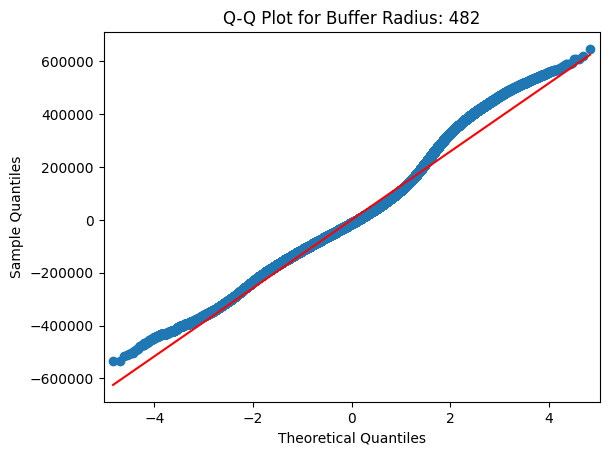

Normality test p-value: 0.0


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=

Results for buffer radius: 965
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.1625
Estimator:                   PanelOLS   R-squared (Between):             -0.5999
No. Observations:             1499478   R-squared (Within):               0.1589
Date:                Thu, Aug 15 2024   R-squared (Overall):             -0.0445
Time:                        13:20:51   Log-likelihood                -1.977e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.636e+04
Entities:                           3   P-value                           0.0000
Avg Obs:                    4.998e+05   Distribution:               F(8,1499459)
Min Obs:                    3.063e+05                                           
Max Obs:                     8.59e+05   F-statistic (robust):          2.487e+

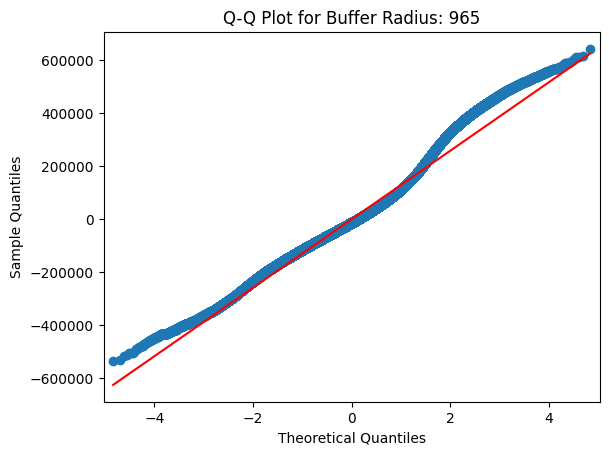

Normality test p-value: 0.0


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=

Results for buffer radius: 1890
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.1633
Estimator:                   PanelOLS   R-squared (Between):             -0.5941
No. Observations:             1499478   R-squared (Within):               0.1607
Date:                Thu, Aug 15 2024   R-squared (Overall):             -0.0412
Time:                        13:20:59   Log-likelihood                -1.977e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.658e+04
Entities:                           3   P-value                           0.0000
Avg Obs:                    4.998e+05   Distribution:               F(8,1499459)
Min Obs:                    3.063e+05                                           
Max Obs:                     8.59e+05   F-statistic (robust):          1.427e

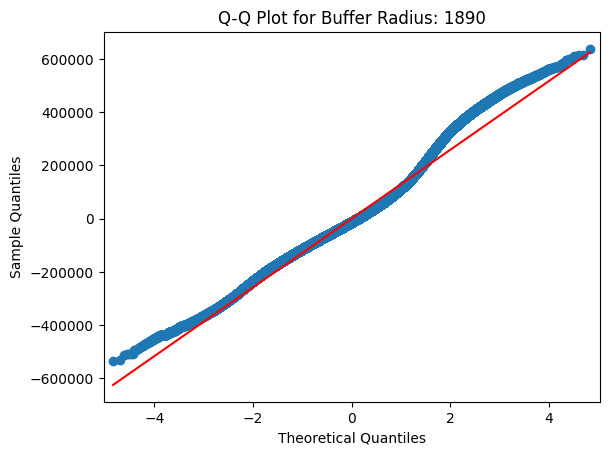

Normality test p-value: 0.0


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=level).mean()
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:681: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mu = self._frame.groupby(level=

Results for buffer radius: 2816
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.1646
Estimator:                   PanelOLS   R-squared (Between):             -0.5858
No. Observations:             1499478   R-squared (Within):               0.1632
Date:                Thu, Aug 15 2024   R-squared (Overall):             -0.0365
Time:                        13:21:06   Log-likelihood                -1.977e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.693e+04
Entities:                           3   P-value                           0.0000
Avg Obs:                    4.998e+05   Distribution:               F(8,1499459)
Min Obs:                    3.063e+05                                           
Max Obs:                     8.59e+05   F-statistic (robust):         -3.709e

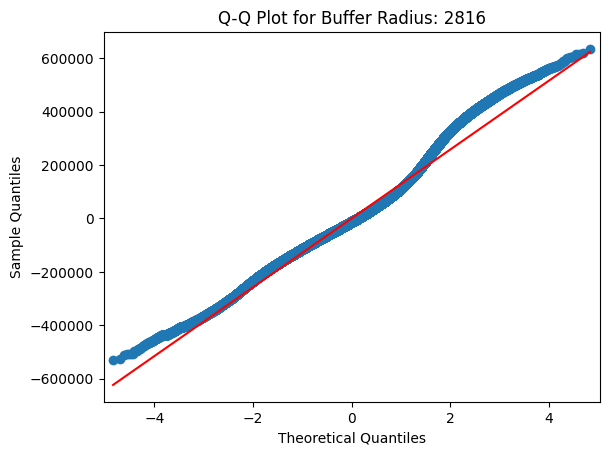

Normality test p-value: 0.0


In [120]:
for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()

    # Convert 'city' and 'year' to appropriate types
    df_subset['city'] = df_subset['city'].astype('category')
    df_subset['year'] = df_subset['year'].astype(int)

    # Set multi-index for PanelOLS using original columns
    df_subset = df_subset.set_index(['city', 'year'])

    # Convert 'property_type', 'old_new', and 'duration' to dummy variables
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration'], drop_first=True)
    
    # Dependent variable
    endog = df_subset['price']

    # Independent variables (including fixed effects dummies)
    exog_vars = ['green_proportion', 'distance_to_center']
    exog_vars += [col for col in df_subset.columns if col.startswith(('property_type_', 'old_new_', 'duration_'))]

    # Add constant to exogenous variables
    exog = sm.add_constant(df_subset[exog_vars])

    # PanelOLS with entity and time effects
    model = PanelOLS(endog, exog, entity_effects=True, time_effects=True, drop_absorbed=True)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    # Print summary of the model
    print(f"Results for buffer radius: {radius}")
    print(result.summary)

    # Diagnostics: Checking for normality of residuals
    sm.qqplot(result.resids, line='s')
    plt.title(f"Q-Q Plot for Buffer Radius: {radius}")
    plt.show()

    # Checking for heteroscedasticity using normality test
    _, p_value = normaltest(result.resids)
    print(f"Normality test p-value: {p_value}")

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = sel

Results for buffer radius: 482
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.1575
Estimator:                   PanelOLS   R-squared (Between):             -2.2374
No. Observations:             1499478   R-squared (Within):               0.1439
Date:                Thu, Aug 15 2024   R-squared (Overall):             -2.3114
Time:                        13:21:29   Log-likelihood                -1.892e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.027e+04
Entities:                      204160   P-value                           0.0000
Avg Obs:                       7.3446   Distribution:               F(8,1295302)
Min Obs:                       1.0000                                           
Max Obs:                       427.00   F-statistic (robust):          4.602e+

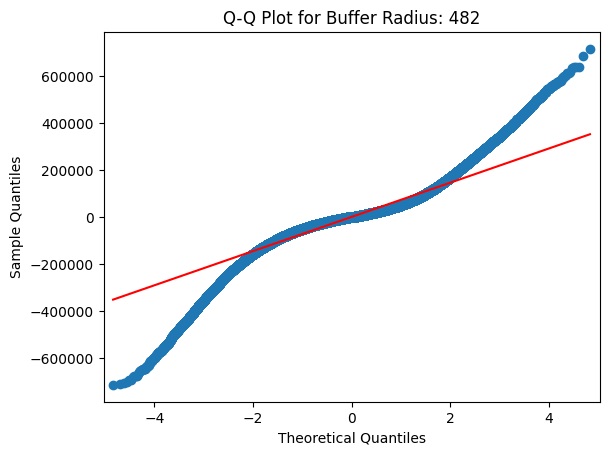

Normality test p-value: 0.0


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = sel

Results for buffer radius: 965
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.1575
Estimator:                   PanelOLS   R-squared (Between):             -2.2273
No. Observations:             1499478   R-squared (Within):               0.1428
Date:                Thu, Aug 15 2024   R-squared (Overall):             -2.3015
Time:                        13:21:38   Log-likelihood                -1.892e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.027e+04
Entities:                      204160   P-value                           0.0000
Avg Obs:                       7.3446   Distribution:               F(8,1295302)
Min Obs:                       1.0000                                           
Max Obs:                       427.00   F-statistic (robust):          3.338e+

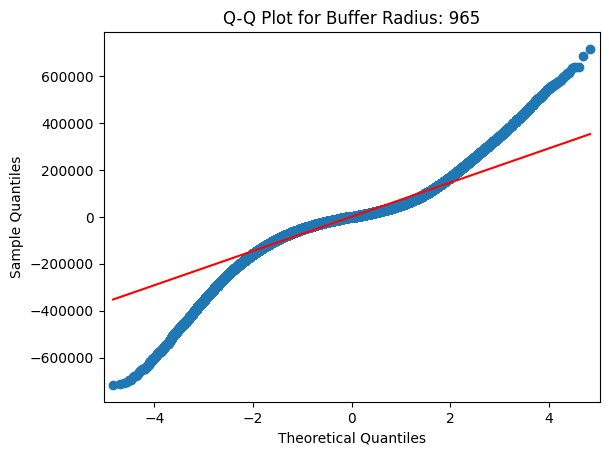

Normality test p-value: 0.0


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = sel

Results for buffer radius: 1890
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.1575
Estimator:                   PanelOLS   R-squared (Between):             -2.2138
No. Observations:             1499478   R-squared (Within):               0.1417
Date:                Thu, Aug 15 2024   R-squared (Overall):             -2.2880
Time:                        13:21:48   Log-likelihood                -1.892e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.028e+04
Entities:                      204160   P-value                           0.0000
Avg Obs:                       7.3446   Distribution:               F(8,1295302)
Min Obs:                       1.0000                                           
Max Obs:                       427.00   F-statistic (robust):         -2.601e

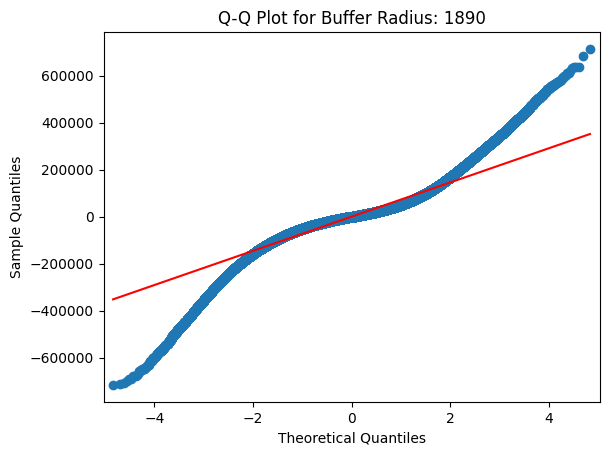

Normality test p-value: 0.0


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = sel

Results for buffer radius: 2816
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.1576
Estimator:                   PanelOLS   R-squared (Between):             -2.2042
No. Observations:             1499478   R-squared (Within):               0.1411
Date:                Thu, Aug 15 2024   R-squared (Overall):             -2.2779
Time:                        13:21:58   Log-likelihood                -1.892e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   3.028e+04
Entities:                      204160   P-value                           0.0000
Avg Obs:                       7.3446   Distribution:               F(8,1295302)
Min Obs:                       1.0000                                           
Max Obs:                       427.00   F-statistic (robust):         -2.204e

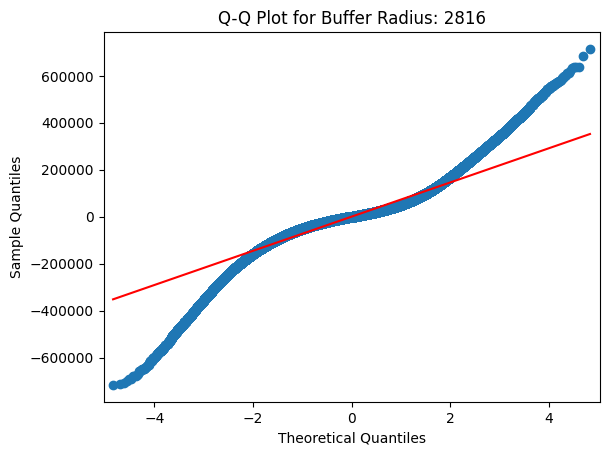

Normality test p-value: 0.0


In [121]:
for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()

    # Convert 'city' and 'year' to appropriate types
    df_subset['postcode'] = df_subset['postcode'].astype('category')
    df_subset['year'] = df_subset['year'].astype(int)

    # Set multi-index for PanelOLS using original columns
    df_subset = df_subset.set_index(['postcode', 'year'])

    # Convert 'property_type', 'old_new', and 'duration' to dummy variables
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration'], drop_first=True)
    
    # Dependent variable
    endog = df_subset['price']

    # Independent variables (including fixed effects dummies)
    exog_vars = ['green_proportion', 'distance_to_center']
    exog_vars += [col for col in df_subset.columns if col.startswith(('property_type_', 'old_new_', 'duration_'))]

    # Add constant to exogenous variables
    exog = sm.add_constant(df_subset[exog_vars])

    # PanelOLS with entity and time effects
    model = PanelOLS(endog, exog, entity_effects=True, time_effects=True, drop_absorbed=True)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    # Print summary of the model
    print(f"Results for buffer radius: {radius}")
    print(result.summary)

    # Diagnostics: Checking for normality of residuals
    sm.qqplot(result.resids, line='s')
    plt.title(f"Q-Q Plot for Buffer Radius: {radius}")
    plt.show()

    # Checking for heteroscedasticity using normality test
    _, p_value = normaltest(result.resids)
    print(f"Normality test p-value: {p_value}")

## Final Fixed effect model

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = sel

Results for buffer radius: 482
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.2419
Estimator:                   PanelOLS   R-squared (Between):             -0.4184
No. Observations:             1499478   R-squared (Within):               0.2268
Date:                Thu, Aug 15 2024   R-squared (Overall):             -0.1403
Time:                        22:17:24   Log-likelihood                 -1.96e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   5.979e+04
Entities:                         115   P-value                           0.0000
Avg Obs:                    1.304e+04   Distribution:               F(8,1499347)
Min Obs:                       8.0000                                           
Max Obs:                    3.187e+04   F-statistic (robust):             85.7

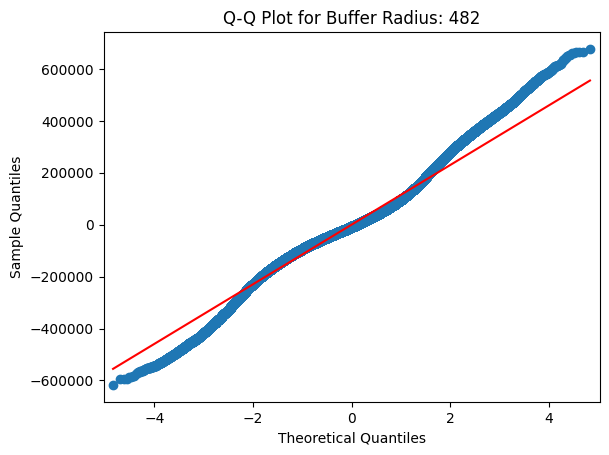

Normality test p-value: 0.0


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = sel

Results for buffer radius: 965
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.2422
Estimator:                   PanelOLS   R-squared (Between):             -0.4326
No. Observations:             1499478   R-squared (Within):               0.2258
Date:                Thu, Aug 15 2024   R-squared (Overall):             -0.1464
Time:                        22:17:30   Log-likelihood                 -1.96e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   5.991e+04
Entities:                         115   P-value                           0.0000
Avg Obs:                    1.304e+04   Distribution:               F(8,1499347)
Min Obs:                       8.0000                                           
Max Obs:                    3.187e+04   F-statistic (robust):             85.2

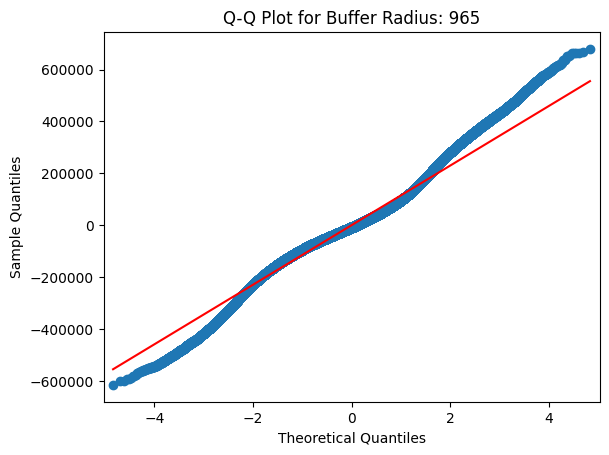

Normality test p-value: 0.0


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = sel

Results for buffer radius: 1890
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.2424
Estimator:                   PanelOLS   R-squared (Between):             -0.4466
No. Observations:             1499478   R-squared (Within):               0.2247
Date:                Thu, Aug 15 2024   R-squared (Overall):             -0.1523
Time:                        22:17:36   Log-likelihood                 -1.96e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   5.998e+04
Entities:                         115   P-value                           0.0000
Avg Obs:                    1.304e+04   Distribution:               F(8,1499347)
Min Obs:                       8.0000                                           
Max Obs:                    3.187e+04   F-statistic (robust):             85.

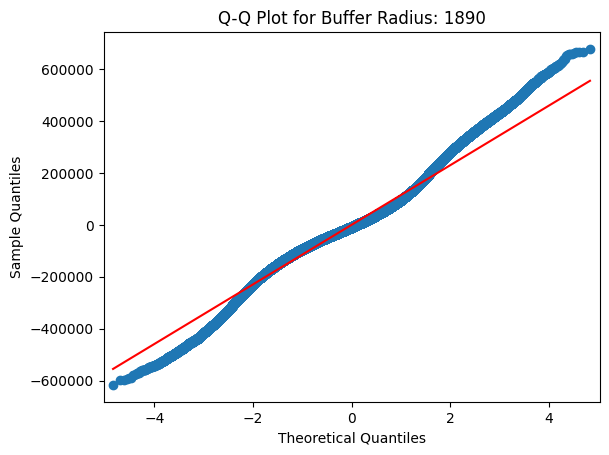

Normality test p-value: 0.0


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/model.py:1219: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = self._frame.groupby(level=level).transform("mean")
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/linearmodels/panel/data.py:591: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_mu = sel

Results for buffer radius: 2816
                          PanelOLS Estimation Summary                           
Dep. Variable:                  price   R-squared:                        0.2422
Estimator:                   PanelOLS   R-squared (Between):             -0.4467
No. Observations:             1499478   R-squared (Within):               0.2244
Date:                Thu, Aug 15 2024   R-squared (Overall):             -0.1531
Time:                        22:17:42   Log-likelihood                 -1.96e+07
Cov. Estimator:             Clustered                                           
                                        F-statistic:                    5.99e+04
Entities:                         115   P-value                           0.0000
Avg Obs:                    1.304e+04   Distribution:               F(8,1499347)
Min Obs:                       8.0000                                           
Max Obs:                    3.187e+04   F-statistic (robust):             86.

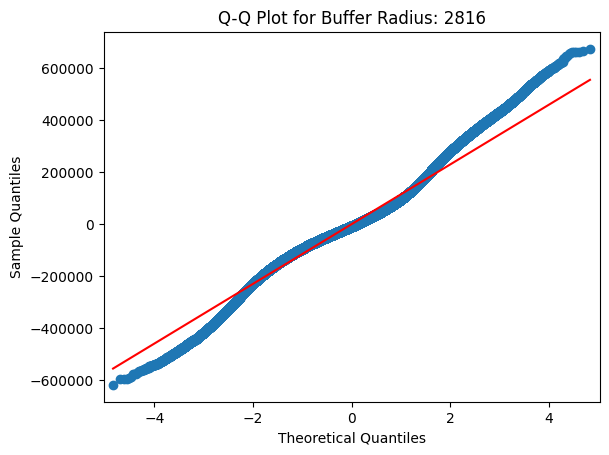

Normality test p-value: 0.0


In [59]:
for radius in buffer_radii:
    # Subset the data for the current buffer radius
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()

    # Convert 'city' and 'year' to appropriate types
    df_subset['postcode_group'] = df_subset['postcode_group'].astype('category')
    df_subset['year'] = df_subset['year'].astype(int)

    # Set multi-index for PanelOLS using original columns
    df_subset = df_subset.set_index(['postcode_group', 'year'])

    # Convert 'property_type', 'old_new', and 'duration' to dummy variables
    df_subset = pd.get_dummies(df_subset, columns=['property_type', 'old_new', 'duration'], drop_first=True)
    
    # Dependent variable
    endog = df_subset['price']

    # Independent variables (including fixed effects dummies)
    exog_vars = ['green_proportion', 'distance_to_center']
    exog_vars += [col for col in df_subset.columns if col.startswith(('property_type_', 'old_new_', 'duration_'))]

    # Add constant to exogenous variables
    exog = sm.add_constant(df_subset[exog_vars])

    # PanelOLS with entity and time effects
    model = PanelOLS(endog, exog, entity_effects=True, time_effects=True, drop_absorbed=True)
    result = model.fit(cov_type='clustered', cluster_entity=True)

    # Print summary of the model
    print(f"Results for buffer radius: {radius}")
    print(result.summary)

    # Diagnostics: Checking for normality of residuals
    sm.qqplot(result.resids, line='s')
    plt.title(f"Q-Q Plot for Buffer Radius: {radius}")
    plt.show()

    # Checking for heteroscedasticity using normality test
    _, p_value = normaltest(result.resids)
    print(f"Normality test p-value: {p_value}")

## Quantile Regression: Are the impacts of green infrastructure on temperature more significant in regions that are already experiencing higher price?

In [ ]:
def quantile_regression(df, quantile):
    formula = 'price ~ green_proportion + distance_to_center + C(year) + C(city) + C(property_type) + C(old_new) + C(duration)'
    model_quant = smf.quantreg(formula, data=df).fit(q=quantile)
    return model_quant

quantiles = [0.25, 0.50, 0.75]

# Enhanced plotting within the loop
for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()

    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])
    
    results = {q: quantile_regression(df_subset, q) for q in quantiles}
    
    data = {
        'Quantile': [],
        'Coefficient': [],
        'P-value': []
    }

    for q in quantiles:
        coef = results[q].params['green_proportion']
        pval = results[q].pvalues['green_proportion']
        data['Quantile'].append(q)
        data['Coefficient'].append(coef)
        data['P-value'].append(pval)
    
    summary_df = pd.DataFrame(data)
    
    print(f"Results for Buffer Radius {radius}:\n", summary_df)
    
    # Plotting the coefficients
    summary_df.set_index('Quantile')['Coefficient'].plot(kind='bar', title=f'Effect of Green Proportion on Price at Buffer Radius {radius}')
    plt.xlabel('Quantiles')
    plt.ylabel('Coefficient of Green Proportion')
    plt.grid(True)
    plt.xticks(rotation=0) 
    plt.show()

quantile: 0.25


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


quantile: 0.5


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


quantile: 0.75


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Results for Buffer Radius 482:
    Quantile   Coefficient  P-value
0      0.25  28493.469955      0.0
1      0.50  37000.975981      0.0
2      0.75  53948.897808      0.0


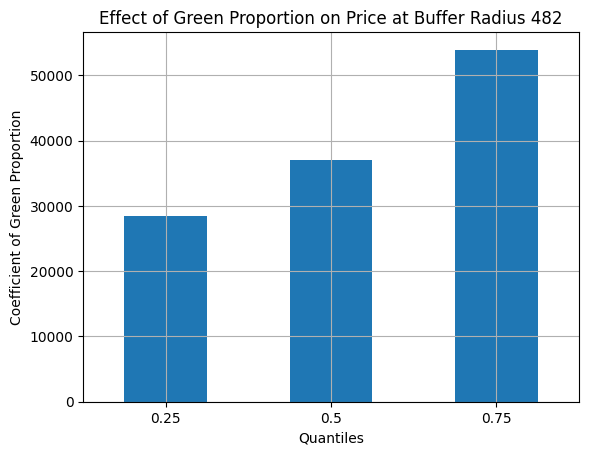

quantile: 0.25


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


quantile: 0.5


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


quantile: 0.75


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Results for Buffer Radius 965:
    Quantile   Coefficient  P-value
0      0.25  38215.797310      0.0
1      0.50  51416.132271      0.0
2      0.75  70916.939128      0.0


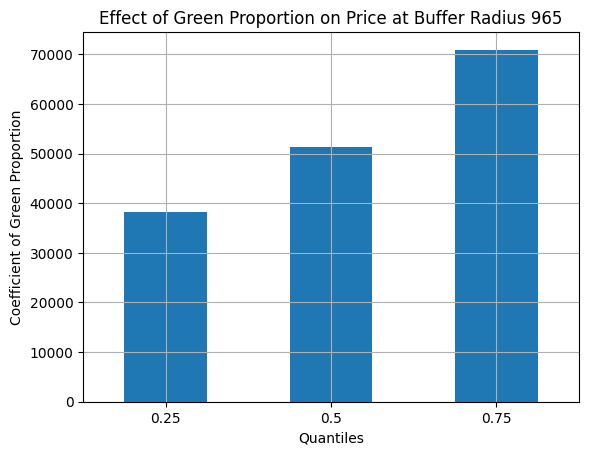

quantile: 0.25


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


quantile: 0.5


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


quantile: 0.75


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Results for Buffer Radius 1890:
    Quantile   Coefficient  P-value
0      0.25  48753.857866      0.0
1      0.50  64122.751006      0.0
2      0.75  86998.794720      0.0


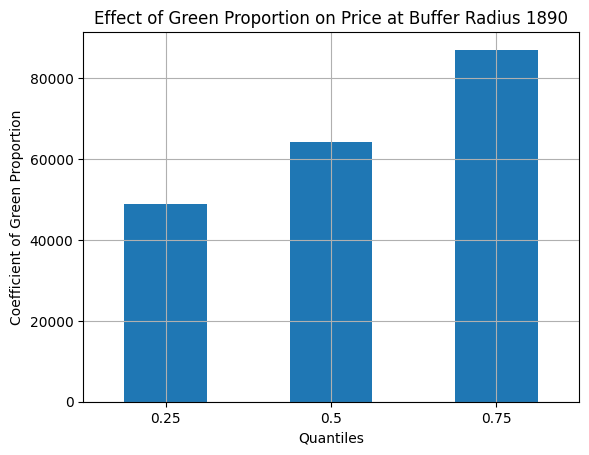

quantile: 0.25


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


quantile: 0.5


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


quantile: 0.75


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Results for Buffer Radius 2816:
    Quantile   Coefficient  P-value
0      0.25  49249.146278      0.0
1      0.50  63020.654924      0.0
2      0.75  69439.277330      0.0


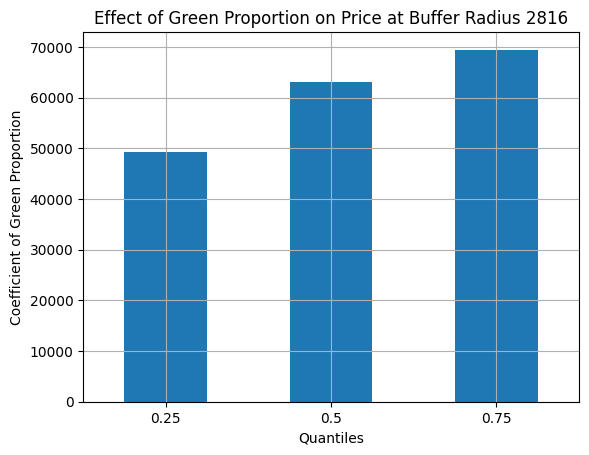

In [79]:

def quantile_regression(df, quantile):
    print("quantile:", quantile)
    formula = 'price ~ green_proportion + distance_to_center + C(year) + C(city) + C(postcode_group) + C(property_type) + C(old_new) + C(duration)'
    model_quant = smf.quantreg(formula, data=df).fit(q=quantile)
    return model_quant

quantiles = [0.25, 0.50, 0.75]

# Enhanced plotting within the loop
for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'postcode_group','property_type', 'old_new', 'duration'])
    
    results = {q: quantile_regression(df_subset, q) for q in quantiles}
    
    data = {
        'Quantile': [],
        'Coefficient': [],
        'P-value': []
    }

    for q in quantiles:
        coef = results[q].params['green_proportion']
        pval = results[q].pvalues['green_proportion']
        data['Quantile'].append(q)
        data['Coefficient'].append(coef)
        data['P-value'].append(pval)
    
    summary_df = pd.DataFrame(data)
    
    print(f"Results for Buffer Radius {radius}:\n", summary_df)
    
    # Plotting the coefficients
    summary_df.set_index('Quantile')['Coefficient'].plot(kind='bar', title=f'Effect of Green Proportion on Price at Buffer Radius {radius}')
    plt.xlabel('Quantiles')
    plt.ylabel('Coefficient of Green Proportion')
    plt.grid(True)
    plt.xticks(rotation=0) 
    plt.show()

In [144]:
wcss

[3575.047321009839,
 1702.1998021881602,
 1080.429760019319,
 776.5547217811633,
 617.2552499226263,
 493.4311007472501]

In [130]:
def quantile_regression(df, quantile):
    formula = 'price ~ green_proportion + distance_to_center + C(year) + C(city) + C(property_type) + C(old_new) + C(duration)'
    model_quant = smf.quantreg(formula, data=df).fit(q=quantile)
    return model_quant
quantiles = np.linspace(0.1, 0.9, 9)

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])
    
    results = {q: quantile_regression(df_subset, q) for q in quantiles}
    
    data = {
        'Quantile': [],
        'Coefficient': [],
        'P-value': []
    }

    for q in quantiles:
        coef = results[q].params['green_proportion']
        pval = results[q].pvalues['green_proportion']
        data['Quantile'].append(q)
        data['Coefficient'].append(coef)
        data['P-value'].append(pval)
    
    summary_df = pd.DataFrame(data)
    
    print(f"Results for Buffer Radius {radius}:\n", summary_df)
    
    # Plotting the coefficients
    summary_df.set_index('Quantile')['Coefficient'].plot(kind='bar', title=f'Effect of Green Proportion on Price at Buffer Radius {radius}')
    plt.xlabel('Quantiles')
    plt.ylabel('Coefficient of Green Proportion')
    plt.grid(True)
    plt.xticks(rotation=0) 
    plt.show()

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


KeyboardInterrupt: 

## Final quantile regression

processing:  0.1


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.2


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.30000000000000004


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.4


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.5


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.6


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.7000000000000001


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.8


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.9


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Results for Buffer Radius 482:
    Quantile   Coefficient        P-value
0       0.1  25879.001997  7.310694e-266
1       0.2  27047.606974   0.000000e+00
2       0.3  30203.777881   0.000000e+00
3       0.4  35146.095307   0.000000e+00
4       0.5  37000.975981   0.000000e+00
5       0.6  42995.807301   0.000000e+00
6       0.7  51614.135382   0.000000e+00
7       0.8  58727.586841   0.000000e+00
8       0.9  69870.837714   0.000000e+00


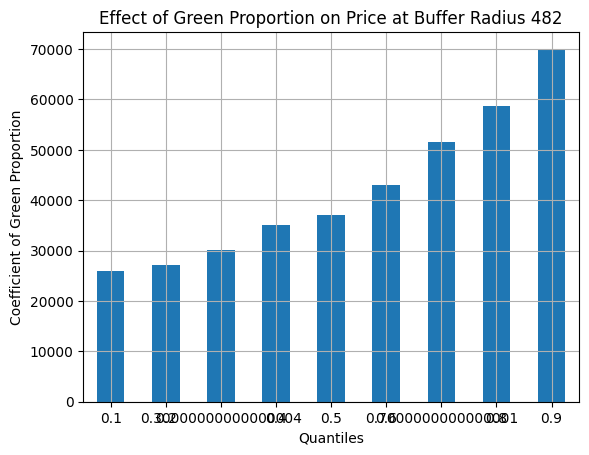

processing:  0.1


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.2


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.30000000000000004


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.4


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.5


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.6


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.7000000000000001


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.8


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.9


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Results for Buffer Radius 965:
    Quantile   Coefficient  P-value
0       0.1  32992.050397      0.0
1       0.2  36141.797161      0.0
2       0.3  41064.944525      0.0
3       0.4  46724.800949      0.0
4       0.5  51416.132271      0.0
5       0.6  58240.547813      0.0
6       0.7  65520.583966      0.0
7       0.8  74261.753192      0.0
8       0.9  85912.190006      0.0


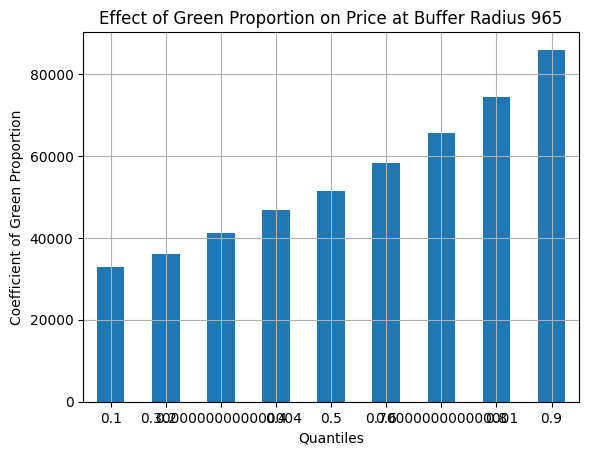

processing:  0.1


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.2


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.30000000000000004


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.4


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.5


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.6


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.7000000000000001


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.8


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.9


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Results for Buffer Radius 1890:
    Quantile   Coefficient        P-value
0       0.1  37810.603489  1.451642e-290
1       0.2  45660.996113   0.000000e+00
2       0.3  51403.308959   0.000000e+00
3       0.4  57339.123479   0.000000e+00
4       0.5  64122.751006   0.000000e+00
5       0.6  70925.796994   0.000000e+00
6       0.7  77687.719091   0.000000e+00
7       0.8  82562.847452   0.000000e+00
8       0.9  79385.290357   0.000000e+00


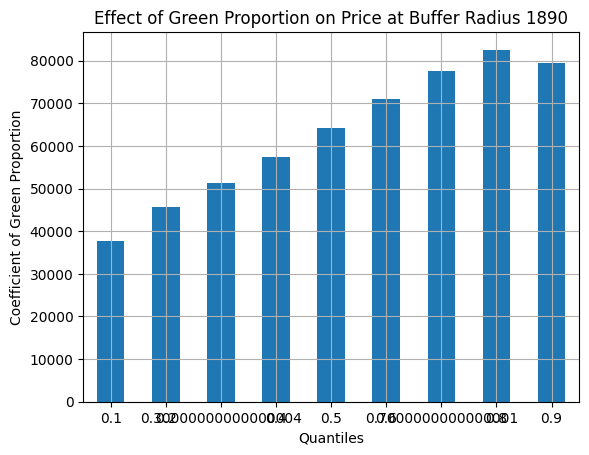

processing:  0.1


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.2


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.30000000000000004


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.4


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.5


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.6


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.7000000000000001


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.8


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


processing:  0.9


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Results for Buffer Radius 2816:
    Quantile   Coefficient        P-value
0       0.1  37516.954678  2.474334e-230
1       0.2  46415.815451   0.000000e+00
2       0.3  49498.074085   0.000000e+00
3       0.4  56802.775795   0.000000e+00
4       0.5  63020.654924   0.000000e+00
5       0.6  64183.771382   0.000000e+00
6       0.7  73122.267183   0.000000e+00
7       0.8  74771.735561   0.000000e+00
8       0.9  73949.370825  3.204316e-283


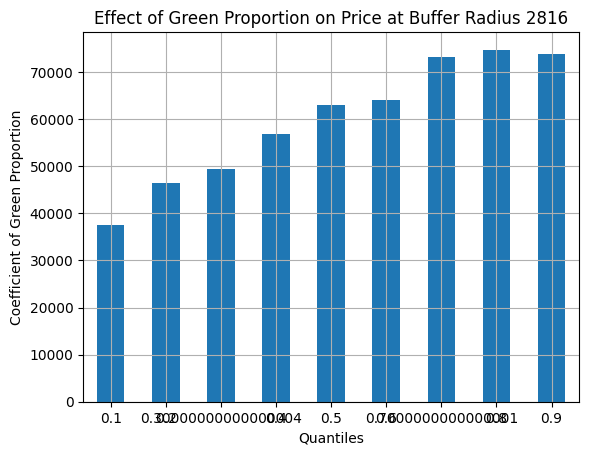

In [80]:
def quantile_regression(df, quantile):
    print("processing: ", quantile)
    formula = 'price ~ green_proportion + distance_to_center + C(year) + C(city) + C(postcode_group) + C(property_type) + C(old_new) + C(duration)'
    model_quant = smf.quantreg(formula, data=df).fit(q=quantile)
    return model_quant
quantiles = np.linspace(0.1, 0.9, 9)

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])
    
    results = {q: quantile_regression(df_subset, q) for q in quantiles}
    
    data = {
        'Quantile': [],
        'Coefficient': [],
        'P-value': []
    }

    for q in quantiles:
        coef = results[q].params['green_proportion']
        pval = results[q].pvalues['green_proportion']
        data['Quantile'].append(q)
        data['Coefficient'].append(coef)
        data['P-value'].append(pval)
    
    summary_df = pd.DataFrame(data)
    
    print(f"Results for Buffer Radius {radius}:\n", summary_df)
    
    # Plotting the coefficients
    summary_df.set_index('Quantile')['Coefficient'].plot(kind='bar', title=f'Effect of Green Proportion on Price at Buffer Radius {radius}')
    plt.xlabel('Quantiles')
    plt.ylabel('Coefficient of Green Proportion')
    plt.grid(True)
    plt.xticks(rotation=0) 
    plt.show()

## spline regression: Does specific percentage of GI is more impactful?

In [68]:
pp_combined_data_outlier_removed['distance_to_center'].isna().sum()

1235344

In [12]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy

# Define the formula
formula = (
    'price ~ bs(green_proportion, knots=(0.25, 0.5, 0.75), degree=3, include_intercept=True) + '
    'distance_to_center + C(year) + C(city) + C(postcode_group) +'
    'C(property_type) + C(old_new) + C(duration)'
)

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'postcode_group','property_type', 'old_new', 'duration'])
    
    # Generate the design matrix for the spline model
    y, X = patsy.dmatrices(formula, data=df_subset, return_type='dataframe')

    # Add constant
    X = sm.add_constant(X)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    print(f"VIF for Buffer Radius {radius}:\n", vif_data)

/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF for Buffer Radius 482:
                                                Feature        VIF
0                                            Intercept   0.000000
1                                      C(year)[T.2016]   2.034584
2                                      C(year)[T.2017]   2.032069
3                                      C(year)[T.2018]   1.988680
4                                      C(year)[T.2019]   1.998006
..                                                 ...        ...
134  bs(green_proportion, knots=(0.25, 0.5, 0.75), ...        inf
135  bs(green_proportion, knots=(0.25, 0.5, 0.75), ...        inf
136  bs(green_proportion, knots=(0.25, 0.5, 0.75), ...        inf
137  bs(green_proportion, knots=(0.25, 0.5, 0.75), ...        inf
138                                 distance_to_center  25.035287

[139 rows x 2 columns]


/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/users/songs16/.conda/envs/lse/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)

KeyboardInterrupt



In [13]:
formula = (
    'price ~ bs(green_proportion, knots=(0.25, 0.5, 0.75), degree=3, include_intercept=True) + '
    'distance_to_center + C(year) + C(city) + C(postcode_group) +'
    'C(property_type) + C(old_new) + C(duration)'
)

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])
    model_spline = smf.ols(formula, data=df_subset).fit()

    print(model_spline.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                 2.282e+04
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        15:40:08   Log-Likelihood:            -1.9592e+07
No. Observations:             1499478   AIC:                         3.918e+07
Df Residuals:                 1499342   BIC:                         3.918e+07
Df Model:                         135                                         
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [16]:
formula = (
    'price ~ bs(green_proportion, knots=(0.25, 0.5, 0.75), degree=3, include_intercept=True) + '
    'distance_to_center + C(year) + C(city) + '
    'C(property_type) + C(old_new) + C(duration)'
)

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])
    model_spline = smf.ols(formula, data=df_subset).fit()

    print(model_spline.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     8178.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:47:38   Log-Likelihood:            -3.7849e+06
No. Observations:              306283   AIC:                         7.570e+06
Df Residuals:                  306261   BIC:                         7.570e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [17]:
formula = (
    'price ~ bs(green_proportion, knots=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7), degree=3, include_intercept=True) + '
    'distance_to_center + C(year) + C(city) + '
    'C(property_type) + C(old_new) + C(duration)'
)
for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])
    model_spline = smf.ols(formula, data=df_subset).fit()
    
    print(model_spline.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     6880.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:47:52   Log-Likelihood:            -3.7848e+06
No. Observations:              306283   AIC:                         7.570e+06
Df Residuals:                  306257   BIC:                         7.570e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [18]:
formula = (
    'price ~ bs(green_proportion, knots=(0.25, 0.5, 0.75), degree=3, include_intercept=True) + '
    'distance_to_center + year + C(city) + '
    'C(property_type) + C(old_new) + C(duration)'
)

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])
    model_spline = smf.ols(formula, data=df_subset).fit()
    
    print(model_spline.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                 1.218e+04
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:48:06   Log-Likelihood:            -3.7853e+06
No. Observations:              306283   AIC:                         7.571e+06
Df Residuals:                  306268   BIC:                         7.571e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

In [19]:
formula = (
    'price ~ bs(green_proportion, knots=(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7), degree=3, include_intercept=True) + '
    'distance_to_center + year + C(city) + '
    'C(property_type) + C(old_new) + C(duration)'
)

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])
    model_spline = smf.ols(formula, data=df_subset).fit()
    
    print(model_spline.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     9489.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:48:17   Log-Likelihood:            -3.7852e+06
No. Observations:              306283   AIC:                         7.570e+06
Df Residuals:                  306264   BIC:                         7.571e+06
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

## Threshold Regression: what proportion is the most impactful?

In [41]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

def fit_segmented_model(df, breakpoints):
    # Ensure data is sorted by green_proportion if not already
    df = df.sort_values(by='green_proportion')

    # Adding columns for segmented regression
    # Create a base segment from 0 to the first breakpoint
    df['segment_0'] = df['green_proportion'].apply(lambda x: min(x, breakpoints[0]))

    # Create segments between each pair of breakpoints
    for i in range(1, len(breakpoints)):
        column_name = f'segment_{i}'
        lower_bound = breakpoints[i - 1]
        upper_bound = breakpoints[i]
        df[column_name] = df['green_proportion'].apply(lambda x: max(0, min(x - lower_bound, upper_bound - lower_bound)))

    # Add segment after the last breakpoint
    df[f'segment_{len(breakpoints)}'] = df['green_proportion'].apply(lambda x: max(0, x - breakpoints[-1]))

    # Build the formula for the OLS model
    segment_terms = ' + '.join([f'segment_{i}' for i in range(len(breakpoints) + 1)])
    formula = f'price ~ {segment_terms} + C(year) + C(city) + distance_to_center + C(property_type) + C(old_new) + C(duration)'
    
    # Fit the model
    model = smf.ols(formula, data=df).fit()
    return model, df, formula

def calculate_vif(model):
    # Extract exogenous variables (X)
    X = model.model.exog
    X = pd.DataFrame(X, columns=model.model.exog_names)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

# Define breakpoints
breakpoints = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])

    seg_model, df_segmented, formula = fit_segmented_model(df_subset, breakpoints)

    # Print the model summary
    print(seg_model.summary())
    
    # Calculate and print VIF using the fitted model
    vif_df = calculate_vif(seg_model)
    print(vif_df)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     7462.
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:30:28   Log-Likelihood:            -3.7849e+06
No. Observations:              306283   AIC:                         7.570e+06
Df Residuals:                  306259   BIC:                         7.570e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -2.293e+

/tmp/ipykernel_24092/4269002705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'segment_{i}'] = df[x_col].apply(lambda x: x - point if x > point else 0)
/tmp/ipykernel_24092/4269002705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'segment_{i}'] = df[x_col].apply(lambda x: x - point if x > point else 0)
/tmp/ipykernel_24092/4269002705.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                 4.099e+04
Date:                Tue, 13 Aug 2024   Prob (F-statistic):               0.00
Time:                        16:44:30   Log-Likelihood:            -1.7564e+07
No. Observations:             1368120   AIC:                         3.513e+07
Df Residuals:                 1368097   BIC:                         3.513e+07
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'distance_to_center' is not defined
    price ~ segment_1 + segment_2 + segment_3 + segment_4 + segment_5 + segment_6 + segment_7 + distance_to_center + C(property_type) + C(old_new) + C(duration) + C(year) + C(city)
                                                                                                ^^^^^^^^^^^^^^^^^^

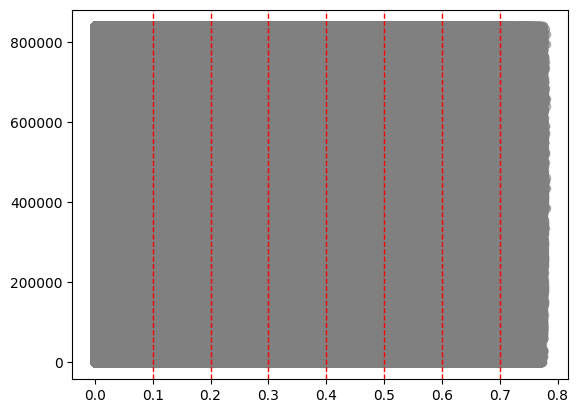

In [64]:
def segmented_regression(df, x_col, y_col, breakpoints):
    # Add a column for each segment
    for i, point in enumerate(breakpoints, start=1):
        df[f'segment_{i}'] = df[x_col].apply(lambda x: x - point if x > point else 0)

    # Additional predictors besides segmented green_proportion
    additional_predictors = ['distance_to_center', 'C(property_type)', 'C(old_new)', 'C(duration)', 'C(year)', 'C(city)']

    # Model formula
    formula_parts = [y_col] + [f'segment_{i}' for i in range(1, len(breakpoints) + 1)] + additional_predictors
    formula = ' ~ '.join([formula_parts[0], ' + '.join(formula_parts[1:])])

    # Fit the model
    model = sm.OLS.from_formula(formula, data=df).fit()
    return model

# Example usage
breakpoints = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
seg_model = segmented_regression(pp_combined_data_outlier_removed, 'green_proportion', 'price', breakpoints)

# Print the summary of the segmented model
print(seg_model.summary())

# Plot the data and the fitted model
plt.scatter(pp_combined_data_outlier_removed['green_proportion'], pp_combined_data_outlier_removed['price'], color='gray', alpha=0.5)
for point in breakpoints:
    plt.axvline(x=point, color='red', linestyle='--', linewidth=1)

# Prepare data for the prediction line
x_range = np.linspace(pp_combined_data_outlier_removed['green_proportion'].min(), pp_combined_data_outlier_removed['green_proportion'].max(), 100)
df_pred = pd.DataFrame(x_range, columns=['green_proportion'])
for i, point in enumerate(breakpoints, start=1):
    df_pred[f'segment_{i}'] = df_pred['green_proportion'].apply(lambda x: x - point if x > point else 0)

# Predict and plot
y_pred = seg_model.predict(df_pred)
plt.plot(x_range, y_pred, color='blue')
plt.xlabel('Green Proportion')
plt.ylabel('Price')
plt.title('Segmented Regression Fit')
plt.show()

## Final segmented regression

In [71]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

def fit_segmented_model(df, breakpoints):
    # Ensure data is sorted by green_proportion if not already
    df = df.sort_values(by='green_proportion')

    # Adding columns for segmented regression
    # Create a base segment from 0 to the first breakpoint
    df['segment_0'] = df['green_proportion'].apply(lambda x: min(x, breakpoints[0]))

    # Create segments between each pair of breakpoints
    for i in range(1, len(breakpoints)):
        column_name = f'segment_{i}'
        lower_bound = breakpoints[i - 1]
        upper_bound = breakpoints[i]
        df[column_name] = df['green_proportion'].apply(lambda x: max(0, min(x - lower_bound, upper_bound - lower_bound)))

    # Add segment after the last breakpoint
    df[f'segment_{len(breakpoints)}'] = df['green_proportion'].apply(lambda x: max(0, x - breakpoints[-1]))

    # Build the formula for the OLS model
    segment_terms = ' + '.join([f'segment_{i}' for i in range(len(breakpoints) + 1)])
    formula = f'price ~ {segment_terms} + C(year) + C(city) + C(postcode_group) + distance_to_center + C(property_type) + C(old_new) + C(duration)'
    
    # Fit the model
    model = smf.ols(formula, data=df).fit()
    return model, df, formula

def calculate_vif(model):
    # Extract exogenous variables (X)
    X = model.model.exog
    X = pd.DataFrame(X, columns=model.model.exog_names)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

# Define breakpoints
breakpoints = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])

    seg_model, df_segmented, formula = fit_segmented_model(df_subset, breakpoints)

    # Print the model summary
    print(seg_model.summary())
    
    # Calculate and print VIF using the fitted model
    # vif_df = calculate_vif(seg_model)
    # print(vif_df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                 2.249e+04
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        22:46:25   Log-Likelihood:            -1.9591e+07
No. Observations:             1499478   AIC:                         3.918e+07
Df Residuals:                 1499340   BIC:                         3.918e+07
Df Model:                         137                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [16]:
pp_combined_data_outlier_removed['green_proportion'].describe()

count    7.233256e+06
mean     3.591162e-01
std      2.189925e-01
min      0.000000e+00
25%      1.851462e-01
50%      3.971081e-01
75%      5.364261e-01
max      7.797147e-01
Name: green_proportion, dtype: float64

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations

def fit_segmented_model(df, breakpoints):
    # Ensure data is sorted by green_proportion if not already
    df = df.sort_values(by='green_proportion')

    # Adding columns for segmented regression
    # Create a base segment from 0 to the first breakpoint
    df['segment_0'] = df['green_proportion'].apply(lambda x: min(x, breakpoints[0]))

    # Create segments between each pair of breakpoints
    for i in range(1, len(breakpoints)):
        column_name = f'segment_{i}'
        lower_bound = breakpoints[i - 1]
        upper_bound = breakpoints[i]
        df[column_name] = df['green_proportion'].apply(lambda x: max(0, min(x - lower_bound, upper_bound - lower_bound)))

    # Add segment after the last breakpoint
    df[f'segment_{len(breakpoints)}'] = df['green_proportion'].apply(lambda x: max(0, x - breakpoints[-1]))

    # Build the formula for the OLS model
    segment_terms = ' + '.join([f'segment_{i}' for i in range(len(breakpoints) + 1)])
    formula = f'price ~ {segment_terms} + C(year) + C(city) + C(postcode_group) + distance_to_center + C(property_type) + C(old_new) + C(duration)'
    
    # Fit the model
    model = smf.ols(formula, data=df).fit()
    return model, df, formula

def calculate_vif(model):
    # Extract exogenous variables (X)
    X = model.model.exog
    X = pd.DataFrame(X, columns=model.model.exog_names)
    
    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

def find_optimal_breakpoints(df, candidate_breakpoints, num_thresholds=7):
    best_aic = float('inf')
    best_breakpoints = None
    best_model = None

    # Iterate over combinations of breakpoints
    for breakpoints in combinations(candidate_breakpoints, num_thresholds):
        model, _, _ = fit_segmented_model(df, sorted(breakpoints))
        if model.aic < best_aic:
            print(breakpoints)
            best_aic = model.aic
            best_breakpoints = breakpoints
            best_model = model

    return best_model, best_breakpoints

# Define candidate breakpoints
candidate_breakpoints = [0.05 * i for i in range(1, 15)]  # Example: breakpoints at intervals of 0.05 from 0.05 to 0.75

optimal_radius = 1890  # Replace this with the specific radius you want to use

# Find the optimal breakpoints for the specified radius
df_optimal = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == optimal_radius].copy()
df_optimal = df_optimal.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                       'year', 'city', 'property_type', 'old_new', 'duration'])

optimal_model, optimal_breakpoints = find_optimal_breakpoints(df_optimal, candidate_breakpoints, num_thresholds=7)

# Print the optimal breakpoints
print(f"Optimal breakpoints for radius {optimal_radius}: {optimal_breakpoints}")

# Fit and evaluate models for all radii using the same breakpoints
for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                         'year', 'city', 'property_type', 'old_new', 'duration'])

    # Fit the model using the optimal breakpoints
    seg_model, df_segmented, formula = fit_segmented_model(df_subset, optimal_breakpoints)
    
    # Print the radius and the model summary
    print(f"Model summary for radius {radius}:")
    print(seg_model.summary())
    
    # Calculate and print VIF using the fitted model
    vif_df = calculate_vif(seg_model)
    print(f"VIF for radius {radius}:")
    print(vif_df)

(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.35000000000000003)
(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.4)
(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.45)
(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.30000000000000004, 0.5)
(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.4, 0.65)
(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.45, 0.65)
(0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.5, 0.7000000000000001)
(0.05, 0.1, 0.15000000000000002, 0.2, 0.30000000000000004, 0.45, 0.65)
(0.05, 0.1, 0.15000000000000002, 0.2, 0.30000000000000004, 0.5, 0.65)
(0.05, 0.1, 0.15000000000000002, 0.2, 0.30000000000000004, 0.5, 0.7000000000000001)
(0.05, 0.1, 0.2, 0.30000000000000004, 0.5, 0.6000000000000001, 0.65)


In [46]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Function to fit the segmented model using identified breakpoints
def fit_segmented_model(df, breakpoints):
    # Ensure data is sorted by green_proportion if not already
    df = df.sort_values(by='green_proportion')

    # Adding columns for segmented regression
    df['segment_0'] = df['green_proportion'].apply(lambda x: min(x, breakpoints[0]))

    for i in range(1, len(breakpoints)):
        column_name = f'segment_{i}'
        lower_bound = breakpoints[i - 1]
        upper_bound = breakpoints[i]
        df[column_name] = df['green_proportion'].apply(lambda x: max(0, min(x - lower_bound, upper_bound - lower_bound)))

    df[f'segment_{len(breakpoints)}'] = df['green_proportion'].apply(lambda x: max(0, x - breakpoints[-1]))

    # Build the formula for the OLS model
    segment_terms = ' + '.join([f'segment_{i}' for i in range(len(breakpoints) + 1)])
    formula = f'price ~ {segment_terms} + C(year) + C(city) + C(postcode_group) + distance_to_center + C(property_type) + C(old_new) + C(duration)'

    # Fit the model
    model = smf.ols(formula, data=df).fit()
    return model, df, formula


optimal_radius = 1890  # Replace this with the specific radius you want to use

df_optimal = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == optimal_radius].copy()
df_optimal = df_optimal.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                       'year', 'city', 'property_type', 'old_new', 'duration'])

columns_to_drop = ['postcode', 'transaction_unique_identifier', 'date_of_transfer', 
                   'paon', 'saon', 'street', 'locality', 'town_city', 'district', 
                   'county', 'ppd_category_type', 'record_status']
df_optimal_cleaned = df_optimal.drop(columns=columns_to_drop, errors='ignore')

# One-hot encode the remaining categorical variables
categorical_vars = ['year', 'city', 'postcode_group', 'property_type', 'old_new', 'duration']
df_encoded = pd.get_dummies(df_optimal_cleaned, columns=categorical_vars, drop_first=True)

# Prepare the data for the decision tree
X = df_encoded.drop(['price'], axis=1)  # Exclude the target variable from features
y = df_encoded['price']


X_simple = df_optimal[['green_proportion']]
y_simple = df_optimal['price']

tree_model_simple = DecisionTreeRegressor(max_leaf_nodes=8, min_samples_leaf=100)
tree_model_simple.fit(X_simple, y_simple)

# Extract and print potential breakpoints
thresholds = sorted(set(tree_model_simple.tree_.threshold[(tree_model_simple.tree_.threshold > 0) & (tree_model_simple.tree_.threshold < 1)]))
print("Identified simple breakpoints from decision tree:", thresholds_simple)

# Check if any valid breakpoints were identified
if not thresholds:
    print("No valid breakpoints were identified.")
else:
    # Apply these breakpoints to fit the segmented regression model
    segmented_model, df_segmented, formula = fit_segmented_model(df_optimal, thresholds)

    # Print the model summary
    print(segmented_model.summary())

    # Calculate and print VIF for the model
    def calculate_vif(model):
        X = model.model.exog
        X = pd.DataFrame(X, columns=model.model.exog_names)

        vif_data = pd.DataFrame()
        vif_data["Feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        return vif_data

    # vif_df = calculate_vif(segmented_model)
    # print("VIF values for the segmented model:")
    # print(vif_df)

    # Now apply these breakpoints to all radii
    for radius in buffer_radii:
        df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
        df_subset = df_subset.dropna(subset=['price', 'green_proportion', 'distance_to_center', 
                                             'year', 'city', 'property_type', 'old_new', 'duration'])

        seg_model, df_segmented, formula = fit_segmented_model(df_subset, thresholds)

        print(f"Model summary for radius {radius}:")
        print(seg_model.summary())

        # vif_df = calculate_vif(seg_model)
        # print(f"VIF for radius {radius}:")
        # print(vif_df)

Identified simple breakpoints from decision tree: [0.1405065432190895, 0.17900530248880386, 0.31182949244976044, 0.36139054596424103, 0.39331039786338806, 0.4623784273862839, 0.6212327778339386]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                 2.239e+04
Date:                Wed, 21 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:03:59   Log-Likelihood:            -1.9594e+07
No. Observations:             1499478   AIC:                         3.919e+07
Df Residuals:                 1499340   BIC:                         3.919e+07
Df Model:                         137                                         
Covariance Type:            nonrobust                                         
               

In [23]:
tree_model_full = DecisionTreeRegressor(max_leaf_nodes=10, min_samples_leaf=20)
tree_model_full.fit(X, y)  # X includes more features
print("Feature importances:", tree_model_full.feature_importances_)

Feature importances: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
for depth in range(6, 30, 3):  # Test with increasing depth
    tree_model_test = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=20)
    tree_model_test.fit(X, y)
    print(f"Depth {depth}, Feature Importances:", tree_model_test.feature_importances_)

Depth 6, Feature Importances: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Depth 9, Feature Importances: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Depth 12, Feature Importances: [2.84997292e-10 1.02466101e-10 1.13113089e-10 7.72894293e-11
 0.00000000e

KeyboardInterrupt: 

In [43]:
X_simple = df_optimal[['green_proportion']]
y_simple = df_optimal['price']

tree_model_simple = DecisionTreeRegressor(max_leaf_nodes=8, min_samples_leaf=100)
tree_model_simple.fit(X_simple, y_simple)

# Extract and print potential breakpoints
thresholds_simple = sorted(set(tree_model_simple.tree_.threshold[(tree_model_simple.tree_.threshold > 0) & (tree_model_simple.tree_.threshold < 1)]))
print("Identified simple breakpoints from decision tree:", thresholds_simple)

Identified simple breakpoints from decision tree: [0.1405065432190895, 0.17900530248880386, 0.31182949244976044, 0.36139054596424103, 0.39331039786338806, 0.4623784273862839, 0.6212327778339386]


## Polynomial Regression

In [76]:
def calculate_vif(df, features):
    # Add a constant column for intercept
    X = df[features]
    X = sm.add_constant(X)
    
    # Check for missing or infinite values
    if X.isnull().any().any():
        print("Warning: Missing values detected in the data. Dropping rows with missing values.")
        X = X.dropna()
    
    if np.isinf(X).any().any():
        print("Warning: Infinite values detected in the data. Dropping rows with infinite values.")
        X = X[~np.isinf(X).any(axis=1)]
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    
    # Calculate VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data

# Define the features to check for multicollinearity
features = ['green_proportion', 'distance_to_center', 'year']

# Calculate VIF for a specific subset of the data
for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset['green_proportion_squared'] = df_subset['green_proportion'] ** 2    
    df_subset['green_proportion_cubed'] = df_subset['green_proportion'] ** 3
    df_subset['green_proportion_fourth'] = df_subset['green_proportion'] ** 4
    
    vif_df = calculate_vif(df_subset, features)
    print(f"VIF for Buffer Radius {radius}:\n", vif_df)

VIF for Buffer Radius 482:
               Feature            VIF
0               const  680201.739085
1    green_proportion       1.291339
2  distance_to_center       1.255138
3                year       1.038575
VIF for Buffer Radius 965:
               Feature            VIF
0               const  681331.101026
1    green_proportion       1.336396
2  distance_to_center       1.298845
3                year       1.040148
VIF for Buffer Radius 1890:
               Feature            VIF
0               const  683031.613541
1    green_proportion       1.359369
2  distance_to_center       1.319578
3                year       1.042539
VIF for Buffer Radius 2816:
               Feature            VIF
0               const  684301.324051
1    green_proportion       1.339631
2  distance_to_center       1.298030
3                year       1.044314


In [20]:
for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset['green_proportion_squared'] = df_subset['green_proportion'] ** 2
    model_poly_squared = smf.ols('price ~ green_proportion + green_proportion_squared + distance_to_center + year + C(city) + C(property_type) + C(old_new) + C(duration)', data=df_subset).fit()
    print(model_poly_squared.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                 1.685e+04
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:44:23   Log-Likelihood:            -3.7860e+06
No. Observations:              306283   AIC:                         7.572e+06
Df Residuals:                  306272   BIC:                         7.572e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [21]:
for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset['green_proportion_squared'] = df_subset['green_proportion'] ** 2    
    df_subset['green_proportion_cubed'] = df_subset['green_proportion'] ** 3
    model_poly_cubed = smf.ols('price ~ green_proportion + green_proportion_squared + green_proportion_cubed + distance_to_center + year + C(city) + C(property_type) + C(old_new) + C(duration)', data=df_subset).fit()
    print(model_poly_cubed.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                 1.535e+04
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:45:24   Log-Likelihood:            -3.7858e+06
No. Observations:              306283   AIC:                         7.572e+06
Df Residuals:                  306271   BIC:                         7.572e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [22]:
for radius in buffer_radii:
    df_subset = pp_combined_data_outlier_removed[pp_combined_data_outlier_removed['buffer_radius'] == radius].copy()
    df_subset['green_proportion_squared'] = df_subset['green_proportion'] ** 2    
    df_subset['green_proportion_cubed'] = df_subset['green_proportion'] ** 3
    df_subset['green_proportion_fourth'] = df_subset['green_proportion'] ** 4
    model_poly_fourth = smf.ols('price ~ green_proportion + green_proportion_squared + green_proportion_cubed + green_proportion_fourth + distance_to_center + year + C(city) + C(property_type) + C(old_new) + C(duration)', data=df_subset).fit()
    print(model_poly_fourth.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                 1.418e+04
Date:                Wed, 14 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:46:07   Log-Likelihood:            -3.7854e+06
No. Observations:              306283   AIC:                         7.571e+06
Df Residuals:                  306270   BIC:                         7.571e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [73]:
df_subset = pp_combined_data_outlier_removed.copy()
df_subset['year'] = df_subset['year'].astype('category')
df_subset['city'] = df_subset['city'].astype('category')

# Prepare data for prediction
x_range = np.linspace(df_subset['green_proportion'].min(), df_subset['green_proportion'].max(), 100)
df_plot = pd.DataFrame(x_range, columns=['green_proportion'])
df_plot['green_proportion_squared'] = df_plot['green_proportion']**2
df_plot['green_proportion_cubed'] = df_plot['green_proportion']**3

# Using modal values for categorical predictions
mode_year = df_subset['year'].mode()[0]
mode_city = df_subset['city'].mode()[0]
df_plot['year'] = mode_year
df_plot['city'] = mode_city

# Ensure categories are consistent
df_plot['year'] = pd.Categorical(df_plot['year'], categories=df_subset['year'].cat.categories)
df_plot['city'] = pd.Categorical(df_plot['city'], categories=df_subset['city'].cat.categories)

# Assume model_poly_cubed is already fitted
# Predict using the fitted model
predictions = model_poly_cubed.predict(df_plot)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(df_subset['green_proportion'], df_subset['price'], color='gray', alpha=0.5)  # Actual data
plt.plot(x_range, predictions, color='red', label='Model Prediction')  # Model predictions
plt.xlabel('Green Proportion')
plt.ylabel('Price')
plt.title('Price vs. Green Proportion')
plt.legend()
plt.show()

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'distance_to_center' is not defined
    price ~ green_proportion + green_proportion_squared + green_proportion_cubed + distance_to_center + year + C(city) + C(property_type) + C(old_new) + C(duration)
                                                                                   ^^^^^^^^^^^^^^^^^^